In [1]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 
from scipy import stats
import time


#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

In [2]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [3]:
df = pd.read_csv(r'mmm_final.csv', encoding='latin1')

In [4]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [5]:
df.head()

,depot,stockiest_name,stockiest_code,hq,products,product_division,pts,opening,receipt,sales,cl0sing,transit,t0tal_cl0sing,branch_0ut,rsm,divisi0n,asm,0pening_value,receipt_value,sales_value,closing_value,transit_value,total_closing_value,branch_out_value,month
0,VIJAYAWADA,UMA SHANKAR MEDICAL AGENCIES,330000032,VIJAYAWADA SPARTA,Nixiyax 15 'S,SPARTA,274.58,0,0,0,0,0,0,0,ANAND,SPARTA,MURALI,0.00,0.00,0.00,0.00,0.00,0.00,0,2020-01-01
1,VIJAYAWADA,SAI BHASKAR MEDICAL DISTRIBUTORS,330000005,NELLORE SPARTA,Androanagen Tablets 10S,SPARTA,133.63,0,18,0,18,0,18,0,ANAND,SPARTA,MURALI,0.00,2405.34,0.00,2405.34,0.00,2405.34,0,2020-01-01
2,VIJAYAWADA,S.P.D MEDICAL AGENCIES,330000103,NELLORE SPARTA,Zinikam Cream 200 G,SPARTA,317.29,0,0,0,0,0,0,0,ANAND,SPARTA,MURALI,0.00,0.00,0.00,0.00,0.00,0.00,0,2020-01-01
3,VIJAYAWADA,ASWINI ENTERPRISES,330000080,VIJAYAWADA SPARTA,Aknay Bar 100GM,SPARTA,128.14,0,0,0,0,0,0,0,ANAND,SPARTA,MURALI,0.00,0.00,0.00,0.00,0.00,0.00,0,2020-01-01
4,VIJAYAWADA,ASWINI ENTERPRISES,330000080,VIJAYAWADA SPARTA,Zinikam Cream 200 G,SPARTA,317.29,0,0,0,0,0,0,0,ANAND,SPARTA,MURALI,0.00,0.00,0.00,0.00,0.00,0.00,0,2020-01-01


In [6]:
df['month'] = pd.to_datetime(df['month'])
df.rename(columns = {'month':'date'}, inplace = True)

In [7]:
df.head()

,depot,stockiest_name,stockiest_code,hq,products,product_division,pts,opening,receipt,sales,cl0sing,transit,t0tal_cl0sing,branch_0ut,rsm,divisi0n,asm,0pening_value,receipt_value,sales_value,closing_value,transit_value,total_closing_value,branch_out_value,date
0,VIJAYAWADA,UMA SHANKAR MEDICAL AGENCIES,330000032,VIJAYAWADA SPARTA,Nixiyax 15 'S,SPARTA,274.58,0,0,0,0,0,0,0,ANAND,SPARTA,MURALI,0.00,0.00,0.00,0.00,0.00,0.00,0,2020-01-01
1,VIJAYAWADA,SAI BHASKAR MEDICAL DISTRIBUTORS,330000005,NELLORE SPARTA,Androanagen Tablets 10S,SPARTA,133.63,0,18,0,18,0,18,0,ANAND,SPARTA,MURALI,0.00,2405.34,0.00,2405.34,0.00,2405.34,0,2020-01-01
2,VIJAYAWADA,S.P.D MEDICAL AGENCIES,330000103,NELLORE SPARTA,Zinikam Cream 200 G,SPARTA,317.29,0,0,0,0,0,0,0,ANAND,SPARTA,MURALI,0.00,0.00,0.00,0.00,0.00,0.00,0,2020-01-01
3,VIJAYAWADA,ASWINI ENTERPRISES,330000080,VIJAYAWADA SPARTA,Aknay Bar 100GM,SPARTA,128.14,0,0,0,0,0,0,0,ANAND,SPARTA,MURALI,0.00,0.00,0.00,0.00,0.00,0.00,0,2020-01-01
4,VIJAYAWADA,ASWINI ENTERPRISES,330000080,VIJAYAWADA SPARTA,Zinikam Cream 200 G,SPARTA,317.29,0,0,0,0,0,0,0,ANAND,SPARTA,MURALI,0.00,0.00,0.00,0.00,0.00,0.00,0,2020-01-01


In [8]:
df.tail()

,depot,stockiest_name,stockiest_code,hq,products,product_division,pts,opening,receipt,sales,cl0sing,transit,t0tal_cl0sing,branch_0ut,rsm,divisi0n,asm,0pening_value,receipt_value,sales_value,closing_value,transit_value,total_closing_value,branch_out_value,date
49994,HUBLI,CHIRAG AGENCIES,334206836,MANGALORE SPARTA,Androanagen Solution 100Ml,SPARTA,597.86,5,0,5,0,0,0,0,ANAND,SPARTA,ARPAN GANGULY,2989.30,0.00,2989.30,0.00,0.00,0.00,0,2023-12-31
49995,HUBLI,WEST COAST AGENCIES,317923801,VIZAG SPARTA,Androanagen Tablets 10S,SPARTA,133.63,53,29,0,82,0,82,0,ANAND,SPARTA,ARPAN GANGULY,7082.39,3875.27,0.00,10957.66,0.00,10957.66,0,2023-12-31
49996,BANGALORE,SHIVA SAI PHARMA DISTRIBUTORS,326210349,BANGALORE SPARTA,Nixiyax 15 'S,SPARTA,274.58,90,0,7,83,0,83,0,ANAND,SPARTA,SATHYA K S & ARPAN GANGULY,24712.20,0.00,1922.06,22790.14,0.00,22790.14,0,2023-12-31
49997,AMBALA,MILLENNIUM MEDICARE PVT. LTD.,126300825,KOLHAPUR SPARTA,Androanagen Tablets 10S,SPARTA,133.63,0,0,0,0,0,0,0,RAJNEESH,SPARTA,MURALI,0.00,0.00,0.00,0.00,0.00,0.00,0,2023-12-31
49998,HUBLI,INNLIFE DISTRIBUTORS (I) PRIVATE LIMITED,323463746,HUBLI SPARTA,Es Body Wash 200ML,SPARTA,268.47,5,0,0,5,0,5,0,ANAND,SPARTA,ARPAN GANGULY,1342.35,0.00,0.00,1342.35,0.00,1342.35,0,2023-12-31


In [9]:
df['date'] = pd.to_datetime(df['date'], format= "%Y/%m/%d")

In [10]:
min(df['date']), max(df['date'])

(Timestamp('2020-01-01 00:00:00'), Timestamp('2023-12-31 00:00:00'))

In [11]:
agg_df = df.groupby(['date','products']).agg({'sales':'sum'}).reset_index().sort_values(['products','date'])

In [12]:
agg_df.head()

,date,products,sales
9,2020-01-03,Acnemoist Cream 60GM,7
23,2020-01-06,Acnemoist Cream 60GM,7
30,2020-01-07,Acnemoist Cream 60GM,3
34,2020-01-08,Acnemoist Cream 60GM,4
51,2020-01-11,Acnemoist Cream 60GM,0


In [13]:
agg_df.tail()

,date,products,sales
13622,2023-12-27,Zinikam Cream 200 G,6
13630,2023-12-28,Zinikam Cream 200 G,0
13637,2023-12-29,Zinikam Cream 200 G,0
13646,2023-12-30,Zinikam Cream 200 G,5
13655,2023-12-31,Zinikam Cream 200 G,0


In [14]:
total_sales_df = agg_df.pivot(index='date',columns='products', values='sales')
total_sales_df.head()

products,Acnemoist Cream 60GM,Aknay Bar 100GM,Androanagen Solution 100Ml,Androanagen Tablets 10S,Banatan Cream 50GM,Canthex 10 Capsules,Es Body Wash 200ML,Melawash 100 ML,Nixiyax 15 'S,Triobloc Cream 25GM,Zinikam Cream 200 G
date,,,,,,,,,,,
2020-01-01,NaN,0.00,NaN,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.00
2020-01-02,NaN,NaN,0.00,NaN,0.00,NaN,0.00,NaN,0.00,0.00,NaN
2020-01-03,7.00,NaN,0.00,NaN,NaN,NaN,0.00,2.00,0.00,NaN,0.00
2020-01-04,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,0.00,NaN
2020-01-05,NaN,NaN,0.00,3.00,0.00,0.00,NaN,NaN,0.00,NaN,NaN


In [15]:
#total_sales_df = total_sales_df.fillna(0)
total_sales_df.replace(0, np.nan, inplace=True)

# Fill NaN values with the mean of each column
total_sales_df.fillna(0, inplace=True)
total_sales_df.head()

products,Acnemoist Cream 60GM,Aknay Bar 100GM,Androanagen Solution 100Ml,Androanagen Tablets 10S,Banatan Cream 50GM,Canthex 10 Capsules,Es Body Wash 200ML,Melawash 100 ML,Nixiyax 15 'S,Triobloc Cream 25GM,Zinikam Cream 200 G
date,,,,,,,,,,,
2020-01-01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2020-01-02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2020-01-03,7.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00
2020-01-04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2020-01-05,0.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


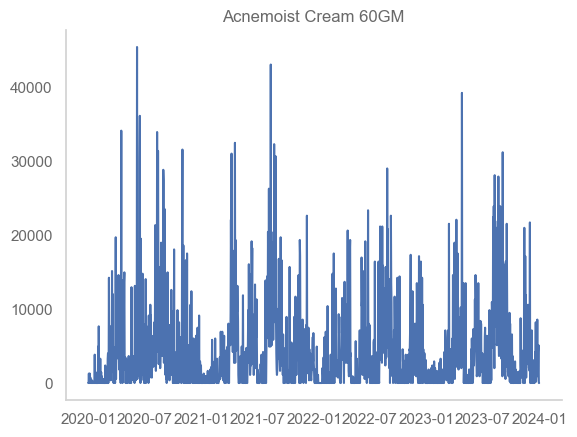

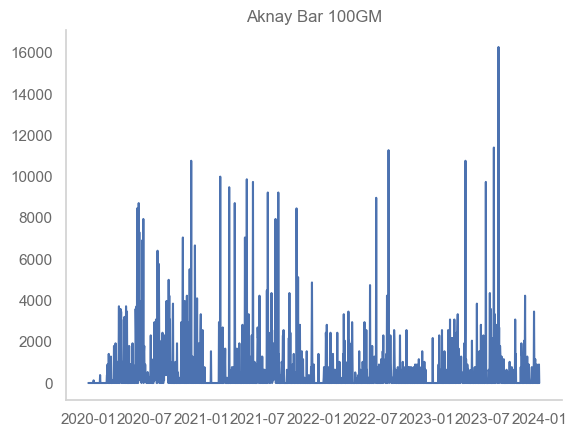

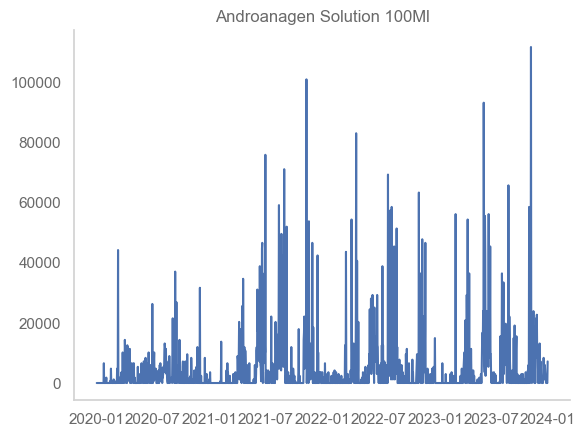

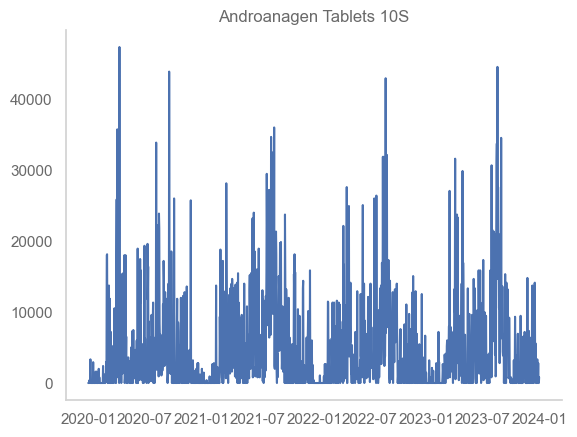

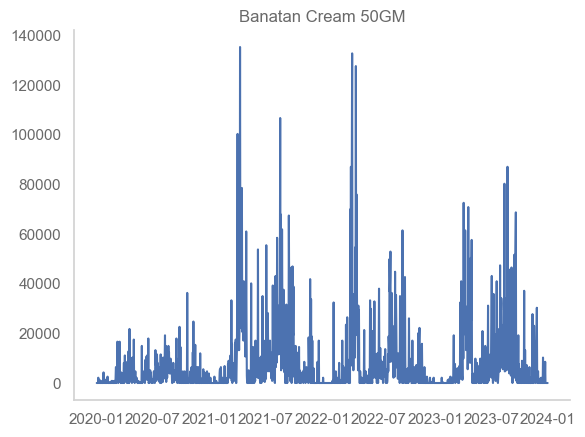

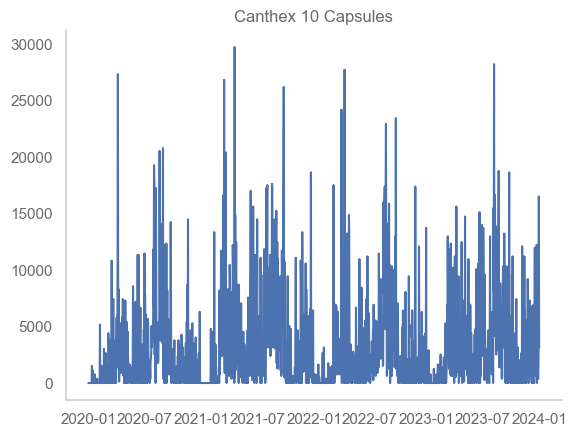

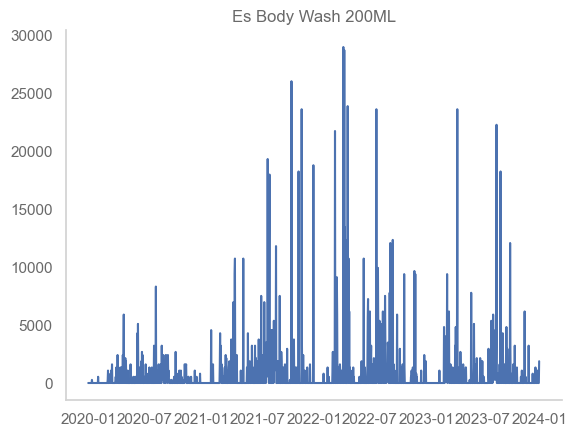

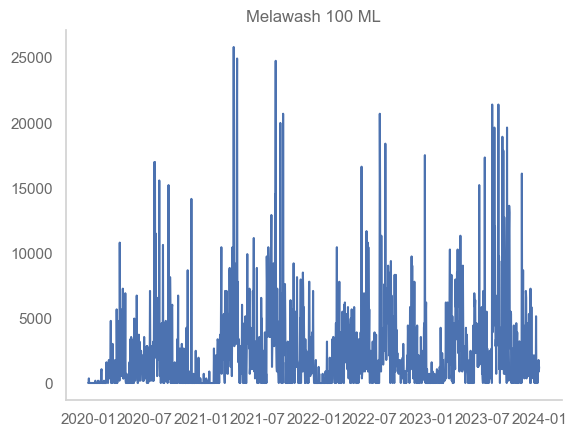

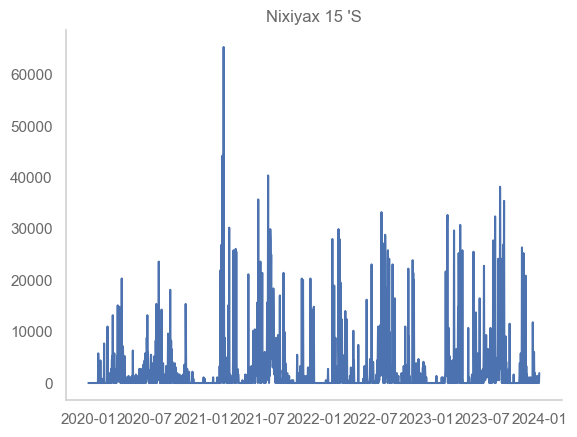

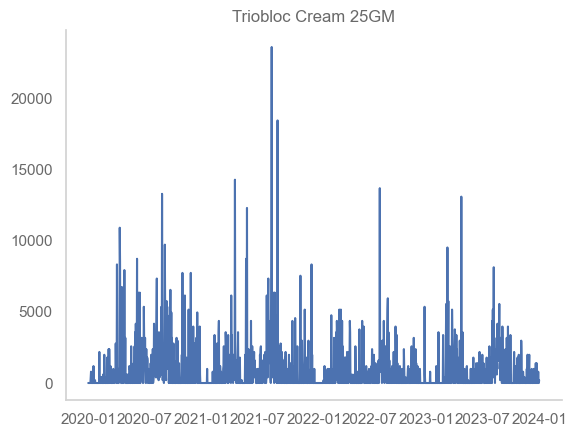

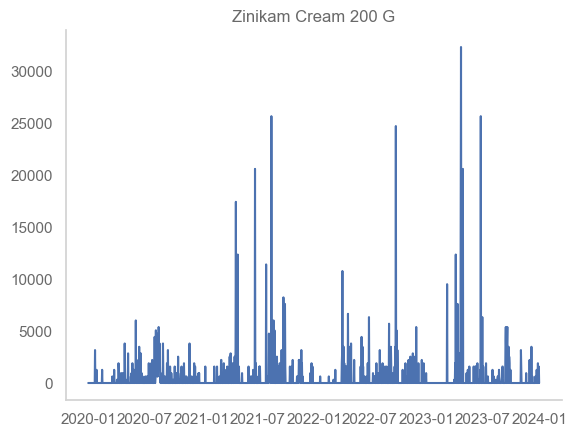

In [16]:
for column in total_sales_df.columns:
    plt.plot(total_sales_df[column])
    plt.title(column)
    plt.show()

In [17]:
missing_data(total_sales_df).head()

,Total,Percent,Types
products,,,
Acnemoist Cream 60GM,0,0.00,float64
Aknay Bar 100GM,0,0.00,float64
Androanagen Solution 100Ml,0,0.00,float64
Androanagen Tablets 10S,0,0.00,float64
Banatan Cream 50GM,0,0.00,float64


In [18]:
old_len = len(total_sales_df.columns)

#Keep categories with avg daily sales greater than $1000
total_sales_df = total_sales_df[total_sales_df.columns[total_sales_df.apply(np.mean,axis='rows') > 1000]]

print("Dropping "+ str(old_len-len(total_sales_df.columns))+" columns due to insufficient data volume.")

Dropping 4 columns due to insufficient data volume.


In [19]:
#Get percentage of rows for each category that is at 0

(total_sales_df == 0).astype(int).sum(axis=0)/len(total_sales_df.sum(axis=0))

products
Acnemoist Cream 60GM          55.29
Androanagen Solution 100Ml   105.57
Androanagen Tablets 10S       62.71
Banatan Cream 50GM            69.86
Canthex 10 Capsules           61.14
Melawash 100 ML               53.57
Nixiyax 15 'S                119.86
dtype: float64

In [20]:
print(total_sales_df.columns)

Index(['Acnemoist Cream 60GM', 'Androanagen Solution 100Ml',
       'Androanagen Tablets 10S', 'Banatan Cream 50GM', 'Canthex 10 Capsules',
       'Melawash 100 ML', 'Nixiyax 15 'S'],
      dtype='object', name='products')


In [21]:
#Need to break out each into it's own dataframe for prediction since each will have different rows affected
prediction_df_list = []

#Cleaning up dataframe using z-score to remove outliers which heavily bias the model
for column in total_sales_df.columns:
    df_clean = total_sales_df[[column]].reset_index()
    
    z = np.abs(stats.zscore(df_clean[column]))
    outlier_index = np.where(z > 2.7)[0] #As 99.7% of the data points lie between 3 standard deviations (Gaussian Distribution)
    print("Dropping "+str(len(outlier_index))+" rows for following category: "+column)
    df_clean.drop(index=outlier_index,inplace=True)
    df_clean.set_index('date', inplace=True)
    prediction_df_list.append(df_clean)

Dropping 43 rows for following category: Acnemoist Cream 60GM
Dropping 46 rows for following category: Androanagen Solution 100Ml
Dropping 39 rows for following category: Androanagen Tablets 10S
Dropping 37 rows for following category: Banatan Cream 50GM
Dropping 40 rows for following category: Canthex 10 Capsules
Dropping 35 rows for following category: Melawash 100 ML
Dropping 62 rows for following category: Nixiyax 15 'S


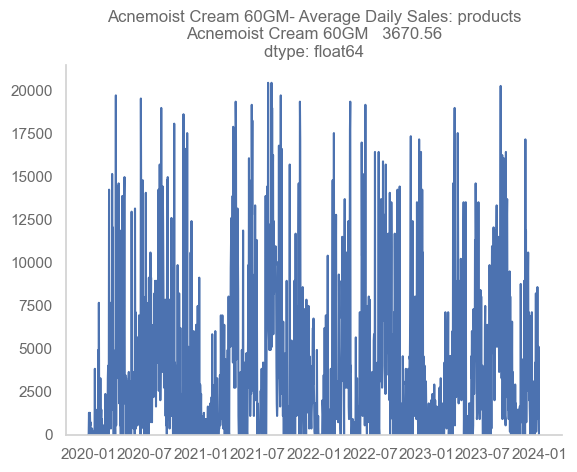

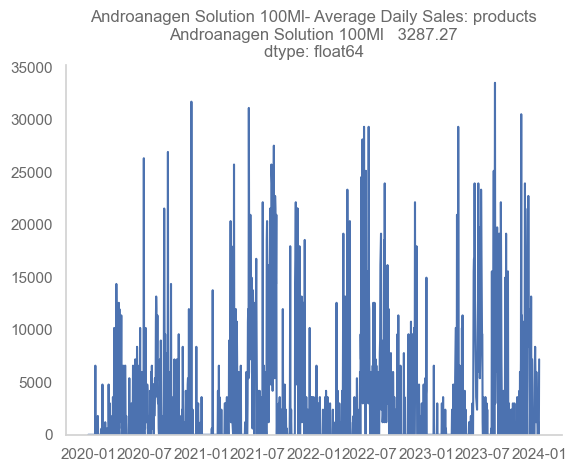

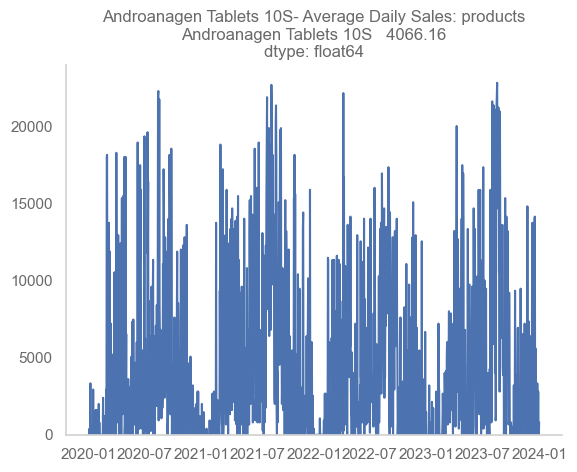

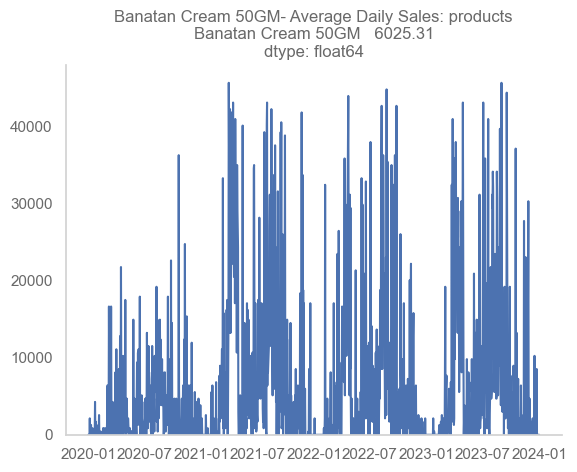

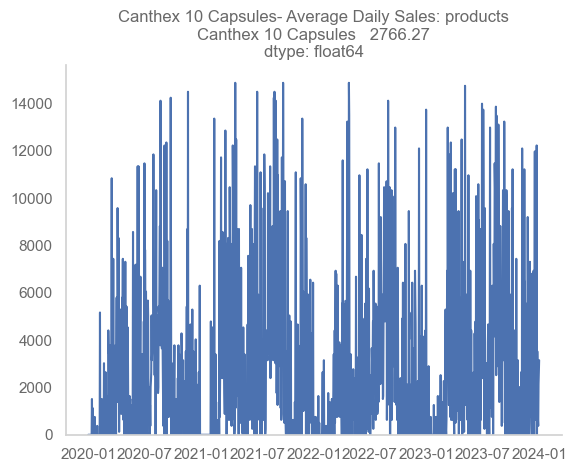

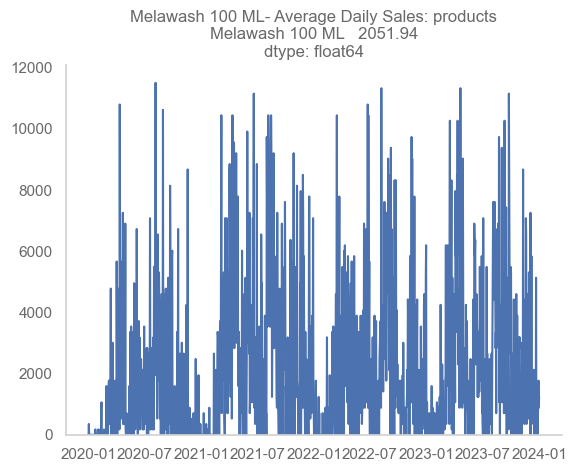

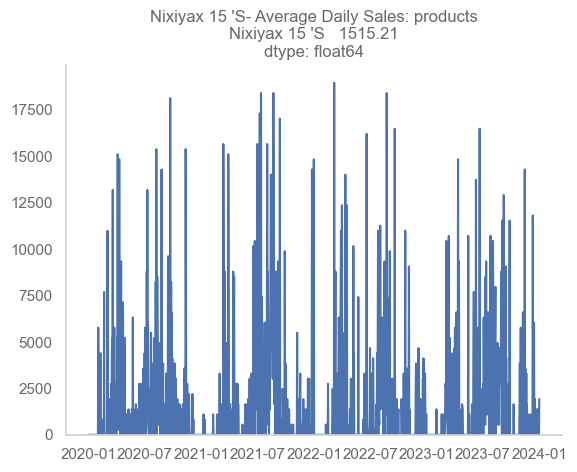

In [22]:
for i in range(len(prediction_df_list)):
    plt.plot(prediction_df_list[i])
    plt.title(prediction_df_list[i].columns[0]+'- Average Daily Sales: '+str(prediction_df_list[i].mean()))
    plt.ylim(ymin=0)
    plt.show()

In [23]:
#lets break it down by thirds for low, mid, high
avg_daily_sales = total_sales_df.apply(np.mean, axis=0).sort_values()
low, mid = np.percentile(total_sales_df.apply(np.mean, axis=0).sort_values(),[33,66])

In [24]:
low_vol_columns = avg_daily_sales[avg_daily_sales<=low].index.tolist()
mid_vol_columns = avg_daily_sales[(avg_daily_sales>low) & (avg_daily_sales<mid)].index
high_vol_columns = avg_daily_sales[avg_daily_sales>=mid].index

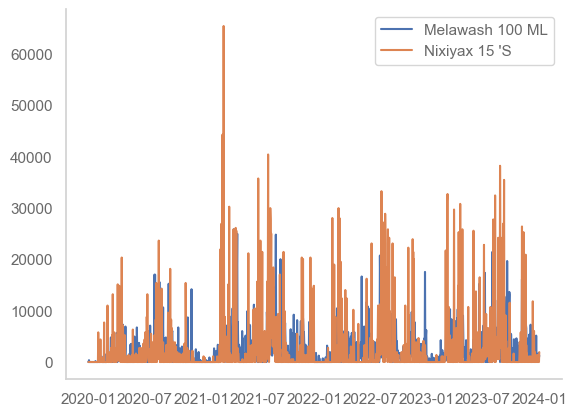

In [25]:
#total_sales_df[low_vol_columns].plot.line()
plt.plot(total_sales_df[low_vol_columns])
plt.legend(low_vol_columns, loc='best') #, bbox_to_anchor=(1.1, 1.1))
plt.show()

In [26]:
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
print(changepoint_prior_scale_range)

[0.001, 0.12575, 0.2505, 0.37525, 0.5]


In [27]:
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()

#seasonality_mode_options = ['additive', 'multiplicative']
#changepoint_range_range = list(np.linspace(0.5, 0.95, num=5))

In [28]:
start_time = time.time()

dicts = {}

for feature in total_sales_df.columns:
  
    category_df = total_sales_df[feature].copy().reset_index()
    category_df.columns = ["ds", "y"]

    category_df[["y"]] = category_df[["y"]].apply(pd.to_numeric)
    category_df["ds"] = pd.to_datetime(category_df["ds"])
    
    param_grid = {  
        "changepoint_prior_scale": changepoint_prior_scale_range,
        "seasonality_prior_scale": seasonality_prior_scale_range }
        #'holidays_prior_scale': holidays_prior_scale_range,
        #'seasonality_mode': seasonality_mode_options,
        #'changepoint_range': changepoint_range_range,

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = [] 

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(category_df)  # Fit model with given params
        df_cv = cross_validation(m, initial="365 days", period="30 days", horizon = "30 days") #took parallel out
        df_p = performance_metrics(df_cv, rolling_window=1)
        print(df_p)
        mapes.append(df_p["mape"].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results["mape"] = mapes
    
    print(feature)
    print(tuning_results.head())

    params_dict = dict(tuning_results.sort_values("mape").reset_index(drop=True).iloc[0])
    params_dict["column"] = feature 
    
    dicts[feature] = params_dict

print("--- %s seconds ---" % (time.time() - start_time)) #about 18 minutes

21:03:03 - cmdstanpy - INFO - Chain [1] start processing
21:03:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:03:03 - cmdstanpy - INFO - Chain [1] start processing
21:03:03 - cmdstanpy - INFO - Chain [1] done processing
21:03:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:03:04 - cmdstanpy - INFO - Chain [1] start processing
21:03:04 - cmdstanpy - INFO - Chain [1] done processing
21:03:04 - cmdstanpy - INFO - Chain [1] start processing
21:03:04 - cmdstanpy - INFO - Chain [1] done processing
21:03:04 - cmdstanpy - INFO - Chain [1] start processing
21:03:04 - cmdstanpy - INFO - Chain [1] done processing
21:03:04 - cmdstanpy - INFO - Chain [1] start processing
21:03:05 - cmdstanpy - INFO - Chain [1] done processing
21:03:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:03:05 - cmdstanpy - INFO - Chain [1] start processing
21:03:05 - cmdstanpy - INFO - Chain [1] done processing
21:03:05 -

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 28260969.81 5316.10 4153.82 1158.60   1.69   1.06      0.89


21:03:17 - cmdstanpy - INFO - Chain [1] start processing
21:03:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:03:17 - cmdstanpy - INFO - Chain [1] start processing
21:03:17 - cmdstanpy - INFO - Chain [1] done processing
21:03:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:03:17 - cmdstanpy - INFO - Chain [1] start processing
21:03:17 - cmdstanpy - INFO - Chain [1] done processing
21:03:18 - cmdstanpy - INFO - Chain [1] start processing
21:03:18 - cmdstanpy - INFO - Chain [1] done processing
21:03:18 - cmdstanpy - INFO - Chain [1] start processing
21:03:18 - cmdstanpy - INFO - Chain [1] done processing
21:03:18 - cmdstanpy - INFO - Chain [1] start processing
21:03:18 - cmdstanpy - INFO - Chain [1] done processing
21:03:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:03:18 - cmdstanpy - INFO - Chain [1] start processing
21:03:20 - cmdstanpy - INFO - Chain [1] done processing
21:03:20 -

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 29739460.22 5453.39 4143.57 1034.42   1.40   1.07      0.84


21:03:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:03:31 - cmdstanpy - INFO - Chain [1] start processing
21:03:31 - cmdstanpy - INFO - Chain [1] done processing
21:03:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:03:31 - cmdstanpy - INFO - Chain [1] start processing
21:03:32 - cmdstanpy - INFO - Chain [1] done processing
21:03:32 - cmdstanpy - INFO - Chain [1] start processing
21:03:32 - cmdstanpy - INFO - Chain [1] done processing
21:03:32 - cmdstanpy - INFO - Chain [1] start processing
21:03:32 - cmdstanpy - INFO - Chain [1] done processing
21:03:32 - cmdstanpy - INFO - Chain [1] start processing
21:03:32 - cmdstanpy - INFO - Chain [1] done processing
21:03:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:03:32 - cmdstanpy - INFO - Chain [1] start processing
21:03:34 - cmdstanpy - INFO - Chain [1] done processing
21:03:34 -

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 29975591.75 5475.00 4184.01 1047.59   1.45   1.07      0.84


21:03:46 - cmdstanpy - INFO - Chain [1] start processing
21:03:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:03:46 - cmdstanpy - INFO - Chain [1] start processing
21:03:46 - cmdstanpy - INFO - Chain [1] done processing
21:03:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:03:47 - cmdstanpy - INFO - Chain [1] start processing
21:03:47 - cmdstanpy - INFO - Chain [1] done processing
21:03:48 - cmdstanpy - INFO - Chain [1] start processing
21:03:48 - cmdstanpy - INFO - Chain [1] done processing
21:03:48 - cmdstanpy - INFO - Chain [1] start processing
21:03:48 - cmdstanpy - INFO - Chain [1] done processing
21:03:48 - cmdstanpy - INFO - Chain [1] start processing
21:03:48 - cmdstanpy - INFO - Chain [1] done processing
21:03:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:03:48 - cmdstanpy - INFO - Chain [1] start processing
21:03:48 - cmdstanpy - INFO - Chain [1] done processing
21:03:49 -

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 29996450.60 5476.90 4193.91 1047.76   1.49   1.07      0.84


21:04:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:04:03 - cmdstanpy - INFO - Chain [1] start processing
21:04:03 - cmdstanpy - INFO - Chain [1] done processing
21:04:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:04:03 - cmdstanpy - INFO - Chain [1] start processing
21:04:05 - cmdstanpy - INFO - Chain [1] done processing
21:04:05 - cmdstanpy - INFO - Chain [1] start processing
21:04:05 - cmdstanpy - INFO - Chain [1] done processing
21:04:05 - cmdstanpy - INFO - Chain [1] start processing
21:04:05 - cmdstanpy - INFO - Chain [1] done processing
21:04:06 - cmdstanpy - INFO - Chain [1] start processing
21:04:06 - cmdstanpy - INFO - Chain [1] done processing
21:04:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:04:06 - cmdstanpy - INFO - Chain [1] start processing
21:04:06 - cmdstanpy - INFO - Chain [1] done processing
21:04:06 -

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 29899296.10 5468.02 4177.92 1037.65   1.50   1.07      0.83


21:04:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:04:20 - cmdstanpy - INFO - Chain [1] start processing
21:04:20 - cmdstanpy - INFO - Chain [1] done processing
21:04:20 - cmdstanpy - INFO - Chain [1] start processing
21:04:20 - cmdstanpy - INFO - Chain [1] done processing
21:04:20 - cmdstanpy - INFO - Chain [1] start processing
21:04:20 - cmdstanpy - INFO - Chain [1] done processing
21:04:21 - cmdstanpy - INFO - Chain [1] start processing
21:04:21 - cmdstanpy - INFO - Chain [1] done processing
21:04:21 - cmdstanpy - INFO - Chain [1] start processing
21:04:21 - cmdstanpy - INFO - Chain [1] done processing
21:04:21 - cmdstanpy - INFO - Chain [1] start processing
21:04:21 - cmdstanpy - INFO - Chain [1] done processing
21:04:21 - cmdstanpy - INFO - Chain [1] start processing
21:04:21 - cmdstanpy - INFO - Chain [1] done processing
21:04:21 - cmdstanpy - INFO - Chain [1] start processing
21:04:21 - cmdstanpy - INFO - Chain [1] done processing
21:04:22 - cmdstanpy - INFO - Chain [1] start processing
21:04:22 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 26073409.75 5106.21 3472.79 703.00   0.90   1.07      0.90


21:04:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:04:30 - cmdstanpy - INFO - Chain [1] start processing
21:04:30 - cmdstanpy - INFO - Chain [1] done processing
21:04:30 - cmdstanpy - INFO - Chain [1] start processing
21:04:30 - cmdstanpy - INFO - Chain [1] done processing
21:04:30 - cmdstanpy - INFO - Chain [1] start processing
21:04:30 - cmdstanpy - INFO - Chain [1] done processing
21:04:30 - cmdstanpy - INFO - Chain [1] start processing
21:04:30 - cmdstanpy - INFO - Chain [1] done processing
21:04:30 - cmdstanpy - INFO - Chain [1] start processing
21:04:31 - cmdstanpy - INFO - Chain [1] done processing
21:04:31 - cmdstanpy - INFO - Chain [1] start processing
21:04:31 - cmdstanpy - INFO - Chain [1] done processing
21:04:31 - cmdstanpy - INFO - Chain [1] start processing
21:04:31 - cmdstanpy - INFO - Chain [1] done processing
21:04:31 - cmdstanpy - INFO - Chain [1] start processing
21:04:31 - cmdstanpy - INFO - Chain [1] done processing
21:04:31 - cmdstanpy - INFO - Chain [1] start processing
21:04:31 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 24606239.47 4960.47 3373.91 607.12   0.89   1.06      0.88


21:04:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:04:40 - cmdstanpy - INFO - Chain [1] start processing
21:04:40 - cmdstanpy - INFO - Chain [1] done processing
21:04:40 - cmdstanpy - INFO - Chain [1] start processing
21:04:40 - cmdstanpy - INFO - Chain [1] done processing
21:04:40 - cmdstanpy - INFO - Chain [1] start processing
21:04:40 - cmdstanpy - INFO - Chain [1] done processing
21:04:40 - cmdstanpy - INFO - Chain [1] start processing
21:04:40 - cmdstanpy - INFO - Chain [1] done processing
21:04:40 - cmdstanpy - INFO - Chain [1] start processing
21:04:40 - cmdstanpy - INFO - Chain [1] done processing
21:04:41 - cmdstanpy - INFO - Chain [1] start processing
21:04:41 - cmdstanpy - INFO - Chain [1] done processing
21:04:41 - cmdstanpy - INFO - Chain [1] start processing
21:04:41 - cmdstanpy - INFO - Chain [1] done processing
21:04:41 - cmdstanpy - INFO - Chain [1] start processing
21:04:41 - cmdstanpy - INFO - Chain [1] done processing
21:04:41 - cmdstanpy - INFO - Chain [1] start processing
21:04:41 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 24600864.26 4959.93 3373.99 608.69   0.89   1.06      0.88


21:04:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:04:49 - cmdstanpy - INFO - Chain [1] start processing
21:04:49 - cmdstanpy - INFO - Chain [1] done processing
21:04:49 - cmdstanpy - INFO - Chain [1] start processing
21:04:50 - cmdstanpy - INFO - Chain [1] done processing
21:04:50 - cmdstanpy - INFO - Chain [1] start processing
21:04:50 - cmdstanpy - INFO - Chain [1] done processing
21:04:50 - cmdstanpy - INFO - Chain [1] start processing
21:04:50 - cmdstanpy - INFO - Chain [1] done processing
21:04:50 - cmdstanpy - INFO - Chain [1] start processing
21:04:50 - cmdstanpy - INFO - Chain [1] done processing
21:04:50 - cmdstanpy - INFO - Chain [1] start processing
21:04:50 - cmdstanpy - INFO - Chain [1] done processing
21:04:51 - cmdstanpy - INFO - Chain [1] start processing
21:04:51 - cmdstanpy - INFO - Chain [1] done processing
21:04:51 - cmdstanpy - INFO - Chain [1] start processing
21:04:51 - cmdstanpy - INFO - Chain [1] done processing
21:04:51 - cmdstanpy - INFO - Chain [1] start processing
21:04:51 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 24609303.97 4960.78 3375.51 609.67   0.89   1.06      0.88


21:04:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:04:59 - cmdstanpy - INFO - Chain [1] start processing
21:04:59 - cmdstanpy - INFO - Chain [1] done processing
21:04:59 - cmdstanpy - INFO - Chain [1] start processing
21:04:59 - cmdstanpy - INFO - Chain [1] done processing
21:04:59 - cmdstanpy - INFO - Chain [1] start processing
21:05:00 - cmdstanpy - INFO - Chain [1] done processing
21:05:00 - cmdstanpy - INFO - Chain [1] start processing
21:05:00 - cmdstanpy - INFO - Chain [1] done processing
21:05:00 - cmdstanpy - INFO - Chain [1] start processing
21:05:00 - cmdstanpy - INFO - Chain [1] done processing
21:05:00 - cmdstanpy - INFO - Chain [1] start processing
21:05:00 - cmdstanpy - INFO - Chain [1] done processing
21:05:00 - cmdstanpy - INFO - Chain [1] start processing
21:05:00 - cmdstanpy - INFO - Chain [1] done processing
21:05:01 - cmdstanpy - INFO - Chain [1] start processing
21:05:01 - cmdstanpy - INFO - Chain [1] done processing
21:05:01 - cmdstanpy - INFO - Chain [1] start processing
21:05:01 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 24586540.86 4958.48 3373.88 608.13   0.89   1.06      0.89


21:05:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:05:09 - cmdstanpy - INFO - Chain [1] start processing
21:05:09 - cmdstanpy - INFO - Chain [1] done processing
21:05:09 - cmdstanpy - INFO - Chain [1] start processing
21:05:09 - cmdstanpy - INFO - Chain [1] done processing
21:05:09 - cmdstanpy - INFO - Chain [1] start processing
21:05:09 - cmdstanpy - INFO - Chain [1] done processing
21:05:10 - cmdstanpy - INFO - Chain [1] start processing
21:05:10 - cmdstanpy - INFO - Chain [1] done processing
21:05:10 - cmdstanpy - INFO - Chain [1] start processing
21:05:10 - cmdstanpy - INFO - Chain [1] done processing
21:05:10 - cmdstanpy - INFO - Chain [1] start processing
21:05:10 - cmdstanpy - INFO - Chain [1] done processing
21:05:10 - cmdstanpy - INFO - Chain [1] start processing
21:05:10 - cmdstanpy - INFO - Chain [1] done processing
21:05:10 - cmdstanpy - INFO - Chain [1] start processing
21:05:11 - cmdstanpy - INFO - Chain [1] done processing
21:05:11 - cmdstanpy - INFO - Chain [1] start processing
21:05:11 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 26788679.28 5175.78 3564.29 721.85   0.96   1.09      0.89


21:05:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:05:19 - cmdstanpy - INFO - Chain [1] start processing
21:05:19 - cmdstanpy - INFO - Chain [1] done processing
21:05:19 - cmdstanpy - INFO - Chain [1] start processing
21:05:19 - cmdstanpy - INFO - Chain [1] done processing
21:05:19 - cmdstanpy - INFO - Chain [1] start processing
21:05:19 - cmdstanpy - INFO - Chain [1] done processing
21:05:20 - cmdstanpy - INFO - Chain [1] start processing
21:05:20 - cmdstanpy - INFO - Chain [1] done processing
21:05:20 - cmdstanpy - INFO - Chain [1] start processing
21:05:20 - cmdstanpy - INFO - Chain [1] done processing
21:05:20 - cmdstanpy - INFO - Chain [1] start processing
21:05:20 - cmdstanpy - INFO - Chain [1] done processing
21:05:20 - cmdstanpy - INFO - Chain [1] start processing
21:05:20 - cmdstanpy - INFO - Chain [1] done processing
21:05:20 - cmdstanpy - INFO - Chain [1] start processing
21:05:20 - cmdstanpy - INFO - Chain [1] done processing
21:05:21 - cmdstanpy - INFO - Chain [1] start processing
21:05:21 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 24699464.15 4969.86 3373.42 604.05   0.92   1.07      0.89


21:05:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:05:29 - cmdstanpy - INFO - Chain [1] start processing
21:05:29 - cmdstanpy - INFO - Chain [1] done processing
21:05:29 - cmdstanpy - INFO - Chain [1] start processing
21:05:29 - cmdstanpy - INFO - Chain [1] done processing
21:05:29 - cmdstanpy - INFO - Chain [1] start processing
21:05:29 - cmdstanpy - INFO - Chain [1] done processing
21:05:29 - cmdstanpy - INFO - Chain [1] start processing
21:05:29 - cmdstanpy - INFO - Chain [1] done processing
21:05:29 - cmdstanpy - INFO - Chain [1] start processing
21:05:29 - cmdstanpy - INFO - Chain [1] done processing
21:05:29 - cmdstanpy - INFO - Chain [1] start processing
21:05:30 - cmdstanpy - INFO - Chain [1] done processing
21:05:30 - cmdstanpy - INFO - Chain [1] start processing
21:05:30 - cmdstanpy - INFO - Chain [1] done processing
21:05:30 - cmdstanpy - INFO - Chain [1] start processing
21:05:30 - cmdstanpy - INFO - Chain [1] done processing
21:05:30 - cmdstanpy - INFO - Chain [1] start processing
21:05:30 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 24710660.44 4970.98 3377.11 606.29   0.91   1.06      0.88


21:05:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:05:38 - cmdstanpy - INFO - Chain [1] start processing
21:05:38 - cmdstanpy - INFO - Chain [1] done processing
21:05:38 - cmdstanpy - INFO - Chain [1] start processing
21:05:38 - cmdstanpy - INFO - Chain [1] done processing
21:05:39 - cmdstanpy - INFO - Chain [1] start processing
21:05:39 - cmdstanpy - INFO - Chain [1] done processing
21:05:39 - cmdstanpy - INFO - Chain [1] start processing
21:05:39 - cmdstanpy - INFO - Chain [1] done processing
21:05:39 - cmdstanpy - INFO - Chain [1] start processing
21:05:39 - cmdstanpy - INFO - Chain [1] done processing
21:05:39 - cmdstanpy - INFO - Chain [1] start processing
21:05:39 - cmdstanpy - INFO - Chain [1] done processing
21:05:39 - cmdstanpy - INFO - Chain [1] start processing
21:05:39 - cmdstanpy - INFO - Chain [1] done processing
21:05:40 - cmdstanpy - INFO - Chain [1] start processing
21:05:40 - cmdstanpy - INFO - Chain [1] done processing
21:05:40 - cmdstanpy - INFO - Chain [1] start processing
21:05:40 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 24707176.35 4970.63 3375.95 606.14   0.91   1.06      0.88


21:05:48 - cmdstanpy - INFO - Chain [1] start processing
21:05:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:05:48 - cmdstanpy - INFO - Chain [1] start processing
21:05:48 - cmdstanpy - INFO - Chain [1] done processing
21:05:48 - cmdstanpy - INFO - Chain [1] start processing
21:05:48 - cmdstanpy - INFO - Chain [1] done processing
21:05:48 - cmdstanpy - INFO - Chain [1] start processing
21:05:48 - cmdstanpy - INFO - Chain [1] done processing
21:05:48 - cmdstanpy - INFO - Chain [1] start processing
21:05:48 - cmdstanpy - INFO - Chain [1] done processing
21:05:49 - cmdstanpy - INFO - Chain [1] start processing
21:05:49 - cmdstanpy - INFO - Chain [1] done processing
21:05:49 - cmdstanpy - INFO - Chain [1] start processing
21:05:49 - cmdstanpy - INFO - Chain [1] done processing
21:05:49 - cmdstanpy - INFO - Chain [1] start processing
21:05:49 - cmdstanpy - INFO - Chain [1] done processing
21:05:49 - cmdstanpy - INFO - Chain [1] start processing
21:05:49 - cmdstanpy - INFO - Chain [1] done processing
21:05:49 - cmdstanpy - INFO - Chain [1] start processing
21:05:49 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 24689188.11 4968.82 3374.16 606.35   0.91   1.06      0.88


21:05:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:05:57 - cmdstanpy - INFO - Chain [1] start processing
21:05:57 - cmdstanpy - INFO - Chain [1] done processing
21:05:58 - cmdstanpy - INFO - Chain [1] start processing
21:05:58 - cmdstanpy - INFO - Chain [1] done processing
21:05:58 - cmdstanpy - INFO - Chain [1] start processing
21:05:58 - cmdstanpy - INFO - Chain [1] done processing
21:05:58 - cmdstanpy - INFO - Chain [1] start processing
21:05:58 - cmdstanpy - INFO - Chain [1] done processing
21:05:58 - cmdstanpy - INFO - Chain [1] start processing
21:05:58 - cmdstanpy - INFO - Chain [1] done processing
21:05:59 - cmdstanpy - INFO - Chain [1] start processing
21:05:59 - cmdstanpy - INFO - Chain [1] done processing
21:05:59 - cmdstanpy - INFO - Chain [1] start processing
21:05:59 - cmdstanpy - INFO - Chain [1] done processing
21:05:59 - cmdstanpy - INFO - Chain [1] start processing
21:05:59 - cmdstanpy - INFO - Chain [1] done processing
21:05:59 - cmdstanpy - INFO - Chain [1] start processing
21:05:59 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 27170147.93 5212.50 3602.76 735.04   1.00   1.10      0.90


21:06:08 - cmdstanpy - INFO - Chain [1] start processing
21:06:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:06:08 - cmdstanpy - INFO - Chain [1] start processing
21:06:08 - cmdstanpy - INFO - Chain [1] done processing
21:06:08 - cmdstanpy - INFO - Chain [1] start processing
21:06:08 - cmdstanpy - INFO - Chain [1] done processing
21:06:08 - cmdstanpy - INFO - Chain [1] start processing
21:06:08 - cmdstanpy - INFO - Chain [1] done processing
21:06:08 - cmdstanpy - INFO - Chain [1] start processing
21:06:08 - cmdstanpy - INFO - Chain [1] done processing
21:06:09 - cmdstanpy - INFO - Chain [1] start processing
21:06:09 - cmdstanpy - INFO - Chain [1] done processing
21:06:09 - cmdstanpy - INFO - Chain [1] start processing
21:06:09 - cmdstanpy - INFO - Chain [1] done processing
21:06:09 - cmdstanpy - INFO - Chain [1] start processing
21:06:09 - cmdstanpy - INFO - Chain [1] done processing
21:06:09 - cmdstanpy - INFO - Chain [1] start processing
21:06:09 - cmdstanpy - INFO - Chain [1] done processing
21:06:10 - cmdstanpy - INFO - Chain [1] start processing
21:06:10 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 24753593.69 4975.30 3378.60 613.49   0.93   1.06      0.88


21:06:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:06:18 - cmdstanpy - INFO - Chain [1] start processing
21:06:18 - cmdstanpy - INFO - Chain [1] done processing
21:06:18 - cmdstanpy - INFO - Chain [1] start processing
21:06:18 - cmdstanpy - INFO - Chain [1] done processing
21:06:18 - cmdstanpy - INFO - Chain [1] start processing
21:06:18 - cmdstanpy - INFO - Chain [1] done processing
21:06:18 - cmdstanpy - INFO - Chain [1] start processing
21:06:18 - cmdstanpy - INFO - Chain [1] done processing
21:06:18 - cmdstanpy - INFO - Chain [1] start processing
21:06:18 - cmdstanpy - INFO - Chain [1] done processing
21:06:19 - cmdstanpy - INFO - Chain [1] start processing
21:06:19 - cmdstanpy - INFO - Chain [1] done processing
21:06:19 - cmdstanpy - INFO - Chain [1] start processing
21:06:19 - cmdstanpy - INFO - Chain [1] done processing
21:06:19 - cmdstanpy - INFO - Chain [1] start processing
21:06:19 - cmdstanpy - INFO - Chain [1] done processing
21:06:19 - cmdstanpy - INFO - Chain [1] start processing
21:06:19 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 24783495.83 4978.30 3380.88 614.66   0.94   1.06      0.88


21:06:27 - cmdstanpy - INFO - Chain [1] start processing
21:06:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:06:27 - cmdstanpy - INFO - Chain [1] start processing
21:06:27 - cmdstanpy - INFO - Chain [1] done processing
21:06:28 - cmdstanpy - INFO - Chain [1] start processing
21:06:28 - cmdstanpy - INFO - Chain [1] done processing
21:06:28 - cmdstanpy - INFO - Chain [1] start processing
21:06:28 - cmdstanpy - INFO - Chain [1] done processing
21:06:28 - cmdstanpy - INFO - Chain [1] start processing
21:06:28 - cmdstanpy - INFO - Chain [1] done processing
21:06:28 - cmdstanpy - INFO - Chain [1] start processing
21:06:28 - cmdstanpy - INFO - Chain [1] done processing
21:06:28 - cmdstanpy - INFO - Chain [1] start processing
21:06:28 - cmdstanpy - INFO - Chain [1] done processing
21:06:29 - cmdstanpy - INFO - Chain [1] start processing
21:06:29 - cmdstanpy - INFO - Chain [1] done processing
21:06:29 - cmdstanpy - INFO - Chain [1] start processing
21:06:29 - cmdstanpy - INFO - Chain [1] done processing
21:06:29 - cmdstanpy - INFO - Chain [1] start processing
21:06:29 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 24771249.86 4977.07 3379.82 613.45   0.93   1.06      0.88


21:06:37 - cmdstanpy - INFO - Chain [1] start processing
21:06:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:06:37 - cmdstanpy - INFO - Chain [1] start processing
21:06:37 - cmdstanpy - INFO - Chain [1] done processing
21:06:37 - cmdstanpy - INFO - Chain [1] start processing
21:06:37 - cmdstanpy - INFO - Chain [1] done processing
21:06:38 - cmdstanpy - INFO - Chain [1] start processing
21:06:38 - cmdstanpy - INFO - Chain [1] done processing
21:06:38 - cmdstanpy - INFO - Chain [1] start processing
21:06:38 - cmdstanpy - INFO - Chain [1] done processing
21:06:38 - cmdstanpy - INFO - Chain [1] start processing
21:06:38 - cmdstanpy - INFO - Chain [1] done processing
21:06:38 - cmdstanpy - INFO - Chain [1] start processing
21:06:38 - cmdstanpy - INFO - Chain [1] done processing
21:06:38 - cmdstanpy - INFO - Chain [1] start processing
21:06:38 - cmdstanpy - INFO - Chain [1] done processing
21:06:39 - cmdstanpy - INFO - Chain [1] start processing
21:06:39 - cmdstanpy - INFO - Chain [1] done processing
21:06:39 - cmdstanpy - INFO - Chain [1] start processing
21:06:39 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 24751352.81 4975.07 3379.26 614.14   0.93   1.06      0.88


21:06:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:06:47 - cmdstanpy - INFO - Chain [1] start processing
21:06:47 - cmdstanpy - INFO - Chain [1] done processing
21:06:47 - cmdstanpy - INFO - Chain [1] start processing
21:06:47 - cmdstanpy - INFO - Chain [1] done processing
21:06:47 - cmdstanpy - INFO - Chain [1] start processing
21:06:47 - cmdstanpy - INFO - Chain [1] done processing
21:06:48 - cmdstanpy - INFO - Chain [1] start processing
21:06:48 - cmdstanpy - INFO - Chain [1] done processing
21:06:48 - cmdstanpy - INFO - Chain [1] start processing
21:06:48 - cmdstanpy - INFO - Chain [1] done processing
21:06:48 - cmdstanpy - INFO - Chain [1] start processing
21:06:48 - cmdstanpy - INFO - Chain [1] done processing
21:06:48 - cmdstanpy - INFO - Chain [1] start processing
21:06:48 - cmdstanpy - INFO - Chain [1] done processing
21:06:49 - cmdstanpy - INFO - Chain [1] start processing
21:06:49 - cmdstanpy - INFO - Chain [1] done processing
21:06:49 - cmdstanpy - INFO - Chain [1] start processing
21:06:49 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 27220360.97 5217.31 3631.20 752.05   1.04   1.10      0.89


21:06:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:06:58 - cmdstanpy - INFO - Chain [1] start processing
21:06:58 - cmdstanpy - INFO - Chain [1] done processing
21:06:58 - cmdstanpy - INFO - Chain [1] start processing
21:06:58 - cmdstanpy - INFO - Chain [1] done processing
21:06:58 - cmdstanpy - INFO - Chain [1] start processing
21:06:58 - cmdstanpy - INFO - Chain [1] done processing
21:06:58 - cmdstanpy - INFO - Chain [1] start processing
21:06:58 - cmdstanpy - INFO - Chain [1] done processing
21:06:59 - cmdstanpy - INFO - Chain [1] start processing
21:06:59 - cmdstanpy - INFO - Chain [1] done processing
21:06:59 - cmdstanpy - INFO - Chain [1] start processing
21:06:59 - cmdstanpy - INFO - Chain [1] done processing
21:06:59 - cmdstanpy - INFO - Chain [1] start processing
21:06:59 - cmdstanpy - INFO - Chain [1] done processing
21:06:59 - cmdstanpy - INFO - Chain [1] start processing
21:06:59 - cmdstanpy - INFO - Chain [1] done processing
21:07:00 - cmdstanpy - INFO - Chain [1] start processing
21:07:00 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 24857536.55 4985.73 3384.60 617.04   0.94   1.06      0.88


21:07:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:07:08 - cmdstanpy - INFO - Chain [1] start processing
21:07:08 - cmdstanpy - INFO - Chain [1] done processing
21:07:08 - cmdstanpy - INFO - Chain [1] start processing
21:07:08 - cmdstanpy - INFO - Chain [1] done processing
21:07:08 - cmdstanpy - INFO - Chain [1] start processing
21:07:08 - cmdstanpy - INFO - Chain [1] done processing
21:07:08 - cmdstanpy - INFO - Chain [1] start processing
21:07:08 - cmdstanpy - INFO - Chain [1] done processing
21:07:09 - cmdstanpy - INFO - Chain [1] start processing
21:07:09 - cmdstanpy - INFO - Chain [1] done processing
21:07:09 - cmdstanpy - INFO - Chain [1] start processing
21:07:09 - cmdstanpy - INFO - Chain [1] done processing
21:07:09 - cmdstanpy - INFO - Chain [1] start processing
21:07:09 - cmdstanpy - INFO - Chain [1] done processing
21:07:09 - cmdstanpy - INFO - Chain [1] start processing
21:07:09 - cmdstanpy - INFO - Chain [1] done processing
21:07:09 - cmdstanpy - INFO - Chain [1] start processing
21:07:10 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 24841742.11 4984.15 3384.55 617.09   0.94   1.06      0.88


21:07:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:07:18 - cmdstanpy - INFO - Chain [1] start processing
21:07:18 - cmdstanpy - INFO - Chain [1] done processing
21:07:18 - cmdstanpy - INFO - Chain [1] start processing
21:07:18 - cmdstanpy - INFO - Chain [1] done processing
21:07:18 - cmdstanpy - INFO - Chain [1] start processing
21:07:18 - cmdstanpy - INFO - Chain [1] done processing
21:07:18 - cmdstanpy - INFO - Chain [1] start processing
21:07:18 - cmdstanpy - INFO - Chain [1] done processing
21:07:19 - cmdstanpy - INFO - Chain [1] start processing
21:07:19 - cmdstanpy - INFO - Chain [1] done processing
21:07:19 - cmdstanpy - INFO - Chain [1] start processing
21:07:19 - cmdstanpy - INFO - Chain [1] done processing
21:07:19 - cmdstanpy - INFO - Chain [1] start processing
21:07:19 - cmdstanpy - INFO - Chain [1] done processing
21:07:19 - cmdstanpy - INFO - Chain [1] start processing
21:07:19 - cmdstanpy - INFO - Chain [1] done processing
21:07:20 - cmdstanpy - INFO - Chain [1] start processing
21:07:20 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 24857551.21 4985.73 3384.34 616.67   0.95   1.06      0.88


21:07:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:07:28 - cmdstanpy - INFO - Chain [1] start processing
21:07:28 - cmdstanpy - INFO - Chain [1] done processing
21:07:28 - cmdstanpy - INFO - Chain [1] start processing
21:07:28 - cmdstanpy - INFO - Chain [1] done processing
21:07:28 - cmdstanpy - INFO - Chain [1] start processing
21:07:28 - cmdstanpy - INFO - Chain [1] done processing
21:07:28 - cmdstanpy - INFO - Chain [1] start processing
21:07:28 - cmdstanpy - INFO - Chain [1] done processing
21:07:29 - cmdstanpy - INFO - Chain [1] start processing
21:07:29 - cmdstanpy - INFO - Chain [1] done processing
21:07:29 - cmdstanpy - INFO - Chain [1] start processing
21:07:29 - cmdstanpy - INFO - Chain [1] done processing
21:07:29 - cmdstanpy - INFO - Chain [1] start processing
21:07:29 - cmdstanpy - INFO - Chain [1] done processing
21:07:29 - cmdstanpy - INFO - Chain [1] start processing
21:07:29 - cmdstanpy - INFO - Chain [1] done processing
21:07:29 - cmdstanpy - INFO - Chain [1] start processing
21:07:30 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 24859733.64 4985.95 3387.47 617.63   0.95   1.06      0.88
Acnemoist Cream 60GM
   changepoint_prior_scale  seasonality_prior_scale    mape
0                     0.00                     0.01 1158.60
1                     0.00                     2.51 1034.42
2                     0.00                     5.00 1047.59
3                     0.00                     7.50 1047.76
4                     0.00                    10.00 1037.65


21:07:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:07:38 - cmdstanpy - INFO - Chain [1] start processing
21:07:38 - cmdstanpy - INFO - Chain [1] done processing
21:07:38 - cmdstanpy - INFO - Chain [1] start processing
21:07:38 - cmdstanpy - INFO - Chain [1] done processing
21:07:38 - cmdstanpy - INFO - Chain [1] start processing
21:07:38 - cmdstanpy - INFO - Chain [1] done processing
21:07:38 - cmdstanpy - INFO - Chain [1] start processing
21:07:38 - cmdstanpy - INFO - Chain [1] done processing
21:07:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:07:38 - cmdstanpy - INFO - Chain [1] start processing
21:07:39 - cmdstanpy - INFO - Chain [1] done processing
21:07:39 - cmdstanpy - INFO - Chain [1] start processing
21:07:39 - cmdstanpy - INFO - Chain [1] done processing
21:07:39 - cmdstanpy - INFO - Chain [1] start processing
21:07:39 - cmdstanpy - INFO - Chain [1] done processing
21:07:39 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 129055529.88 11360.26 6503.35 2362.38 800.25   1.38      0.89


21:07:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:07:51 - cmdstanpy - INFO - Chain [1] start processing
21:07:51 - cmdstanpy - INFO - Chain [1] done processing
21:07:51 - cmdstanpy - INFO - Chain [1] start processing
21:07:51 - cmdstanpy - INFO - Chain [1] done processing
21:07:51 - cmdstanpy - INFO - Chain [1] start processing
21:07:51 - cmdstanpy - INFO - Chain [1] done processing
21:07:51 - cmdstanpy - INFO - Chain [1] start processing
21:07:51 - cmdstanpy - INFO - Chain [1] done processing
21:07:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:07:51 - cmdstanpy - INFO - Chain [1] start processing
21:07:52 - cmdstanpy - INFO - Chain [1] done processing
21:07:52 - cmdstanpy - INFO - Chain [1] start processing
21:07:52 - cmdstanpy - INFO - Chain [1] done processing
21:07:52 - cmdstanpy - INFO - Chain [1] start processing
21:07:52 - cmdstanpy - INFO - Chain [1] done processing
21:07:52 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 130158998.54 11408.72 6465.44 2239.36 154.41   1.39      0.88


21:08:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:08:04 - cmdstanpy - INFO - Chain [1] start processing
21:08:04 - cmdstanpy - INFO - Chain [1] done processing
21:08:05 - cmdstanpy - INFO - Chain [1] start processing
21:08:05 - cmdstanpy - INFO - Chain [1] done processing
21:08:05 - cmdstanpy - INFO - Chain [1] start processing
21:08:05 - cmdstanpy - INFO - Chain [1] done processing
21:08:05 - cmdstanpy - INFO - Chain [1] start processing
21:08:05 - cmdstanpy - INFO - Chain [1] done processing
21:08:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:08:05 - cmdstanpy - INFO - Chain [1] start processing
21:08:05 - cmdstanpy - INFO - Chain [1] done processing
21:08:06 - cmdstanpy - INFO - Chain [1] start processing
21:08:06 - cmdstanpy - INFO - Chain [1] done processing
21:08:06 - cmdstanpy - INFO - Chain [1] start processing
21:08:06 - cmdstanpy - INFO - Chain [1] done processing
21:08:06 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 130629924.64 11429.34 6492.88 2249.47 153.09   1.40      0.87


21:08:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:08:18 - cmdstanpy - INFO - Chain [1] start processing
21:08:18 - cmdstanpy - INFO - Chain [1] done processing
21:08:18 - cmdstanpy - INFO - Chain [1] start processing
21:08:18 - cmdstanpy - INFO - Chain [1] done processing
21:08:18 - cmdstanpy - INFO - Chain [1] start processing
21:08:19 - cmdstanpy - INFO - Chain [1] done processing
21:08:19 - cmdstanpy - INFO - Chain [1] start processing
21:08:19 - cmdstanpy - INFO - Chain [1] done processing
21:08:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:08:19 - cmdstanpy - INFO - Chain [1] start processing
21:08:19 - cmdstanpy - INFO - Chain [1] done processing
21:08:19 - cmdstanpy - INFO - Chain [1] start processing
21:08:19 - cmdstanpy - INFO - Chain [1] done processing
21:08:20 - cmdstanpy - INFO - Chain [1] start processing
21:08:20 - cmdstanpy - INFO - Chain [1] done processing
21:08:20 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 129400862.57 11375.45 6491.44 2255.27 153.68   1.39      0.87


21:08:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:08:31 - cmdstanpy - INFO - Chain [1] start processing
21:08:31 - cmdstanpy - INFO - Chain [1] done processing
21:08:32 - cmdstanpy - INFO - Chain [1] start processing
21:08:32 - cmdstanpy - INFO - Chain [1] done processing
21:08:32 - cmdstanpy - INFO - Chain [1] start processing
21:08:32 - cmdstanpy - INFO - Chain [1] done processing
21:08:32 - cmdstanpy - INFO - Chain [1] start processing
21:08:32 - cmdstanpy - INFO - Chain [1] done processing
21:08:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:08:32 - cmdstanpy - INFO - Chain [1] start processing
21:08:33 - cmdstanpy - INFO - Chain [1] done processing
21:08:33 - cmdstanpy - INFO - Chain [1] start processing
21:08:33 - cmdstanpy - INFO - Chain [1] done processing
21:08:33 - cmdstanpy - INFO - Chain [1] start processing
21:08:33 - cmdstanpy - INFO - Chain [1] done processing
21:08:33 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 129310972.43 11371.50 6444.76 2214.93 106.35   1.39      0.87


21:08:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:08:45 - cmdstanpy - INFO - Chain [1] start processing
21:08:46 - cmdstanpy - INFO - Chain [1] done processing
21:08:46 - cmdstanpy - INFO - Chain [1] start processing
21:08:46 - cmdstanpy - INFO - Chain [1] done processing
21:08:46 - cmdstanpy - INFO - Chain [1] start processing
21:08:46 - cmdstanpy - INFO - Chain [1] done processing
21:08:46 - cmdstanpy - INFO - Chain [1] start processing
21:08:46 - cmdstanpy - INFO - Chain [1] done processing
21:08:46 - cmdstanpy - INFO - Chain [1] start processing
21:08:46 - cmdstanpy - INFO - Chain [1] done processing
21:08:46 - cmdstanpy - INFO - Chain [1] start processing
21:08:47 - cmdstanpy - INFO - Chain [1] done processing
21:08:47 - cmdstanpy - INFO - Chain [1] start processing
21:08:47 - cmdstanpy - INFO - Chain [1] done processing
21:08:47 - cmdstanpy - INFO - Chain [1] start processing
21:08:47 - cmdstanpy - INFO - Chain [1] done processing
21:08:47 - cmdstanpy - INFO - Chain [1] start processing
21:08:47 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 132775350.72 11522.82 6234.69 2027.28  64.01   1.41      0.83


21:08:55 - cmdstanpy - INFO - Chain [1] start processing
21:08:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:08:56 - cmdstanpy - INFO - Chain [1] start processing
21:08:56 - cmdstanpy - INFO - Chain [1] done processing
21:08:56 - cmdstanpy - INFO - Chain [1] start processing
21:08:56 - cmdstanpy - INFO - Chain [1] done processing
21:08:56 - cmdstanpy - INFO - Chain [1] start processing
21:08:56 - cmdstanpy - INFO - Chain [1] done processing
21:08:56 - cmdstanpy - INFO - Chain [1] start processing
21:08:56 - cmdstanpy - INFO - Chain [1] done processing
21:08:56 - cmdstanpy - INFO - Chain [1] start processing
21:08:56 - cmdstanpy - INFO - Chain [1] done processing
21:08:57 - cmdstanpy - INFO - Chain [1] start processing
21:08:57 - cmdstanpy - INFO - Chain [1] done processing
21:08:57 - cmdstanpy - INFO - Chain [1] start processing
21:08:57 - cmdstanpy - INFO - Chain [1] done processing
21:08:57 - cmdstanpy - INFO - Chain [1] start processing
21:08:57 - cmdstanpy - INFO - Chain [1] done processing
21:08:57 - cmdstanpy - INFO - Chain [1] start processing
21:08:57 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 130092944.72 11405.83 6169.48 1981.46  85.44   1.40      0.83


21:09:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:09:05 - cmdstanpy - INFO - Chain [1] start processing
21:09:05 - cmdstanpy - INFO - Chain [1] done processing
21:09:06 - cmdstanpy - INFO - Chain [1] start processing
21:09:06 - cmdstanpy - INFO - Chain [1] done processing
21:09:06 - cmdstanpy - INFO - Chain [1] start processing
21:09:06 - cmdstanpy - INFO - Chain [1] done processing
21:09:06 - cmdstanpy - INFO - Chain [1] start processing
21:09:06 - cmdstanpy - INFO - Chain [1] done processing
21:09:06 - cmdstanpy - INFO - Chain [1] start processing
21:09:06 - cmdstanpy - INFO - Chain [1] done processing
21:09:06 - cmdstanpy - INFO - Chain [1] start processing
21:09:07 - cmdstanpy - INFO - Chain [1] done processing
21:09:07 - cmdstanpy - INFO - Chain [1] start processing
21:09:07 - cmdstanpy - INFO - Chain [1] done processing
21:09:07 - cmdstanpy - INFO - Chain [1] start processing
21:09:07 - cmdstanpy - INFO - Chain [1] done processing
21:09:07 - cmdstanpy - INFO - Chain [1] start processing
21:09:07 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 130138258.37 11407.82 6174.21 1984.58  85.06   1.40      0.83


21:09:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:09:16 - cmdstanpy - INFO - Chain [1] start processing
21:09:16 - cmdstanpy - INFO - Chain [1] done processing
21:09:16 - cmdstanpy - INFO - Chain [1] start processing
21:09:16 - cmdstanpy - INFO - Chain [1] done processing
21:09:16 - cmdstanpy - INFO - Chain [1] start processing
21:09:16 - cmdstanpy - INFO - Chain [1] done processing
21:09:16 - cmdstanpy - INFO - Chain [1] start processing
21:09:16 - cmdstanpy - INFO - Chain [1] done processing
21:09:16 - cmdstanpy - INFO - Chain [1] start processing
21:09:16 - cmdstanpy - INFO - Chain [1] done processing
21:09:17 - cmdstanpy - INFO - Chain [1] start processing
21:09:17 - cmdstanpy - INFO - Chain [1] done processing
21:09:17 - cmdstanpy - INFO - Chain [1] start processing
21:09:17 - cmdstanpy - INFO - Chain [1] done processing
21:09:17 - cmdstanpy - INFO - Chain [1] start processing
21:09:17 - cmdstanpy - INFO - Chain [1] done processing
21:09:17 - cmdstanpy - INFO - Chain [1] start processing
21:09:17 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 130183825.63 11409.81 6181.04 1989.84  83.51   1.40      0.83


21:09:27 - cmdstanpy - INFO - Chain [1] start processing
21:09:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:09:28 - cmdstanpy - INFO - Chain [1] start processing
21:09:28 - cmdstanpy - INFO - Chain [1] done processing
21:09:28 - cmdstanpy - INFO - Chain [1] start processing
21:09:28 - cmdstanpy - INFO - Chain [1] done processing
21:09:28 - cmdstanpy - INFO - Chain [1] start processing
21:09:28 - cmdstanpy - INFO - Chain [1] done processing
21:09:28 - cmdstanpy - INFO - Chain [1] start processing
21:09:28 - cmdstanpy - INFO - Chain [1] done processing
21:09:28 - cmdstanpy - INFO - Chain [1] start processing
21:09:28 - cmdstanpy - INFO - Chain [1] done processing
21:09:29 - cmdstanpy - INFO - Chain [1] start processing
21:09:29 - cmdstanpy - INFO - Chain [1] done processing
21:09:29 - cmdstanpy - INFO - Chain [1] start processing
21:09:29 - cmdstanpy - INFO - Chain [1] done processing
21:09:29 - cmdstanpy - INFO - Chain [1] start processing
21:09:29 - cmdstanpy - INFO - Chain [1] done processing
21:09:29 - cmdstanpy - INFO - Chain [1] start processing
21:09:29 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 130212202.21 11411.06 6172.96 1980.23  74.97   1.40      0.83


21:09:37 - cmdstanpy - INFO - Chain [1] start processing
21:09:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:09:37 - cmdstanpy - INFO - Chain [1] start processing
21:09:37 - cmdstanpy - INFO - Chain [1] done processing
21:09:38 - cmdstanpy - INFO - Chain [1] start processing
21:09:38 - cmdstanpy - INFO - Chain [1] done processing
21:09:38 - cmdstanpy - INFO - Chain [1] start processing
21:09:38 - cmdstanpy - INFO - Chain [1] done processing
21:09:38 - cmdstanpy - INFO - Chain [1] start processing
21:09:38 - cmdstanpy - INFO - Chain [1] done processing
21:09:38 - cmdstanpy - INFO - Chain [1] start processing
21:09:38 - cmdstanpy - INFO - Chain [1] done processing
21:09:38 - cmdstanpy - INFO - Chain [1] start processing
21:09:39 - cmdstanpy - INFO - Chain [1] done processing
21:09:39 - cmdstanpy - INFO - Chain [1] start processing
21:09:39 - cmdstanpy - INFO - Chain [1] done processing
21:09:39 - cmdstanpy - INFO - Chain [1] start processing
21:09:39 - cmdstanpy - INFO - Chain [1] done processing
21:09:39 - cmdstanpy - INFO - Chain [1] start processing
21:09:39 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 134073895.01 11579.03 6277.53 2020.14  33.33   1.42      0.82


21:09:48 - cmdstanpy - INFO - Chain [1] start processing
21:09:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:09:48 - cmdstanpy - INFO - Chain [1] start processing
21:09:48 - cmdstanpy - INFO - Chain [1] done processing
21:09:48 - cmdstanpy - INFO - Chain [1] start processing
21:09:48 - cmdstanpy - INFO - Chain [1] done processing
21:09:48 - cmdstanpy - INFO - Chain [1] start processing
21:09:48 - cmdstanpy - INFO - Chain [1] done processing
21:09:48 - cmdstanpy - INFO - Chain [1] start processing
21:09:48 - cmdstanpy - INFO - Chain [1] done processing
21:09:49 - cmdstanpy - INFO - Chain [1] start processing
21:09:49 - cmdstanpy - INFO - Chain [1] done processing
21:09:49 - cmdstanpy - INFO - Chain [1] start processing
21:09:49 - cmdstanpy - INFO - Chain [1] done processing
21:09:49 - cmdstanpy - INFO - Chain [1] start processing
21:09:49 - cmdstanpy - INFO - Chain [1] done processing
21:09:49 - cmdstanpy - INFO - Chain [1] start processing
21:09:49 - cmdstanpy - INFO - Chain [1] done processing
21:09:50 - cmdstanpy - INFO - Chain [1] start processing
21:09:50 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 131188657.40 11453.76 6168.05 1930.30  45.68   1.41      0.82


21:09:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:09:58 - cmdstanpy - INFO - Chain [1] start processing
21:09:58 - cmdstanpy - INFO - Chain [1] done processing
21:09:58 - cmdstanpy - INFO - Chain [1] start processing
21:09:58 - cmdstanpy - INFO - Chain [1] done processing
21:09:58 - cmdstanpy - INFO - Chain [1] start processing
21:09:58 - cmdstanpy - INFO - Chain [1] done processing
21:09:59 - cmdstanpy - INFO - Chain [1] start processing
21:09:59 - cmdstanpy - INFO - Chain [1] done processing
21:09:59 - cmdstanpy - INFO - Chain [1] start processing
21:09:59 - cmdstanpy - INFO - Chain [1] done processing
21:09:59 - cmdstanpy - INFO - Chain [1] start processing
21:09:59 - cmdstanpy - INFO - Chain [1] done processing
21:09:59 - cmdstanpy - INFO - Chain [1] start processing
21:09:59 - cmdstanpy - INFO - Chain [1] done processing
21:09:59 - cmdstanpy - INFO - Chain [1] start processing
21:10:00 - cmdstanpy - INFO - Chain [1] done processing
21:10:00 - cmdstanpy - INFO - Chain [1] start processing
21:10:00 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 131097210.74 11449.77 6177.06 1943.66  43.56   1.40      0.82


21:10:08 - cmdstanpy - INFO - Chain [1] start processing
21:10:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:10:08 - cmdstanpy - INFO - Chain [1] start processing
21:10:08 - cmdstanpy - INFO - Chain [1] done processing
21:10:08 - cmdstanpy - INFO - Chain [1] start processing
21:10:08 - cmdstanpy - INFO - Chain [1] done processing
21:10:09 - cmdstanpy - INFO - Chain [1] start processing
21:10:09 - cmdstanpy - INFO - Chain [1] done processing
21:10:09 - cmdstanpy - INFO - Chain [1] start processing
21:10:09 - cmdstanpy - INFO - Chain [1] done processing
21:10:09 - cmdstanpy - INFO - Chain [1] start processing
21:10:09 - cmdstanpy - INFO - Chain [1] done processing
21:10:09 - cmdstanpy - INFO - Chain [1] start processing
21:10:09 - cmdstanpy - INFO - Chain [1] done processing
21:10:10 - cmdstanpy - INFO - Chain [1] start processing
21:10:10 - cmdstanpy - INFO - Chain [1] done processing
21:10:10 - cmdstanpy - INFO - Chain [1] start processing
21:10:10 - cmdstanpy - INFO - Chain [1] done processing
21:10:10 - cmdstanpy - INFO - Chain [1] start processing
21:10:10 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 131166470.31 11452.79 6192.26 1954.04  52.54   1.40      0.82


21:10:18 - cmdstanpy - INFO - Chain [1] start processing
21:10:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:10:18 - cmdstanpy - INFO - Chain [1] start processing
21:10:19 - cmdstanpy - INFO - Chain [1] done processing
21:10:19 - cmdstanpy - INFO - Chain [1] start processing
21:10:19 - cmdstanpy - INFO - Chain [1] done processing
21:10:19 - cmdstanpy - INFO - Chain [1] start processing
21:10:19 - cmdstanpy - INFO - Chain [1] done processing
21:10:19 - cmdstanpy - INFO - Chain [1] start processing
21:10:19 - cmdstanpy - INFO - Chain [1] done processing
21:10:19 - cmdstanpy - INFO - Chain [1] start processing
21:10:19 - cmdstanpy - INFO - Chain [1] done processing
21:10:20 - cmdstanpy - INFO - Chain [1] start processing
21:10:20 - cmdstanpy - INFO - Chain [1] done processing
21:10:20 - cmdstanpy - INFO - Chain [1] start processing
21:10:20 - cmdstanpy - INFO - Chain [1] done processing
21:10:20 - cmdstanpy - INFO - Chain [1] start processing
21:10:20 - cmdstanpy - INFO - Chain [1] done processing
21:10:20 - cmdstanpy - INFO - Chain [1] start processing
21:10:20 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 131416638.51 11463.71 6189.30 1944.01  72.00   1.41      0.82


21:10:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:10:29 - cmdstanpy - INFO - Chain [1] start processing
21:10:29 - cmdstanpy - INFO - Chain [1] done processing
21:10:29 - cmdstanpy - INFO - Chain [1] start processing
21:10:29 - cmdstanpy - INFO - Chain [1] done processing
21:10:29 - cmdstanpy - INFO - Chain [1] start processing
21:10:29 - cmdstanpy - INFO - Chain [1] done processing
21:10:29 - cmdstanpy - INFO - Chain [1] start processing
21:10:29 - cmdstanpy - INFO - Chain [1] done processing
21:10:30 - cmdstanpy - INFO - Chain [1] start processing
21:10:30 - cmdstanpy - INFO - Chain [1] done processing
21:10:30 - cmdstanpy - INFO - Chain [1] start processing
21:10:30 - cmdstanpy - INFO - Chain [1] done processing
21:10:30 - cmdstanpy - INFO - Chain [1] start processing
21:10:30 - cmdstanpy - INFO - Chain [1] done processing
21:10:30 - cmdstanpy - INFO - Chain [1] start processing
21:10:30 - cmdstanpy - INFO - Chain [1] done processing
21:10:31 - cmdstanpy - INFO - Chain [1] start processing
21:10:31 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 135031359.62 11620.30 6314.25 2029.20  34.56   1.42      0.82


21:10:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:10:39 - cmdstanpy - INFO - Chain [1] start processing
21:10:39 - cmdstanpy - INFO - Chain [1] done processing
21:10:39 - cmdstanpy - INFO - Chain [1] start processing
21:10:39 - cmdstanpy - INFO - Chain [1] done processing
21:10:40 - cmdstanpy - INFO - Chain [1] start processing
21:10:40 - cmdstanpy - INFO - Chain [1] done processing
21:10:40 - cmdstanpy - INFO - Chain [1] start processing
21:10:40 - cmdstanpy - INFO - Chain [1] done processing
21:10:40 - cmdstanpy - INFO - Chain [1] start processing
21:10:40 - cmdstanpy - INFO - Chain [1] done processing
21:10:40 - cmdstanpy - INFO - Chain [1] start processing
21:10:40 - cmdstanpy - INFO - Chain [1] done processing
21:10:40 - cmdstanpy - INFO - Chain [1] start processing
21:10:40 - cmdstanpy - INFO - Chain [1] done processing
21:10:41 - cmdstanpy - INFO - Chain [1] start processing
21:10:41 - cmdstanpy - INFO - Chain [1] done processing
21:10:41 - cmdstanpy - INFO - Chain [1] start processing
21:10:41 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 132762560.17 11522.26 6208.60 1923.58  34.72   1.41      0.81


21:10:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:10:50 - cmdstanpy - INFO - Chain [1] start processing
21:10:50 - cmdstanpy - INFO - Chain [1] done processing
21:10:50 - cmdstanpy - INFO - Chain [1] start processing
21:10:50 - cmdstanpy - INFO - Chain [1] done processing
21:10:50 - cmdstanpy - INFO - Chain [1] start processing
21:10:50 - cmdstanpy - INFO - Chain [1] done processing
21:10:50 - cmdstanpy - INFO - Chain [1] start processing
21:10:50 - cmdstanpy - INFO - Chain [1] done processing
21:10:50 - cmdstanpy - INFO - Chain [1] start processing
21:10:50 - cmdstanpy - INFO - Chain [1] done processing
21:10:51 - cmdstanpy - INFO - Chain [1] start processing
21:10:51 - cmdstanpy - INFO - Chain [1] done processing
21:10:51 - cmdstanpy - INFO - Chain [1] start processing
21:10:51 - cmdstanpy - INFO - Chain [1] done processing
21:10:51 - cmdstanpy - INFO - Chain [1] start processing
21:10:51 - cmdstanpy - INFO - Chain [1] done processing
21:10:51 - cmdstanpy - INFO - Chain [1] start processing
21:10:52 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 132614806.61 11515.85 6212.50 1925.43  54.90   1.41      0.82


21:11:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:11:00 - cmdstanpy - INFO - Chain [1] start processing
21:11:00 - cmdstanpy - INFO - Chain [1] done processing
21:11:00 - cmdstanpy - INFO - Chain [1] start processing
21:11:00 - cmdstanpy - INFO - Chain [1] done processing
21:11:00 - cmdstanpy - INFO - Chain [1] start processing
21:11:01 - cmdstanpy - INFO - Chain [1] done processing
21:11:01 - cmdstanpy - INFO - Chain [1] start processing
21:11:01 - cmdstanpy - INFO - Chain [1] done processing
21:11:01 - cmdstanpy - INFO - Chain [1] start processing
21:11:01 - cmdstanpy - INFO - Chain [1] done processing
21:11:01 - cmdstanpy - INFO - Chain [1] start processing
21:11:01 - cmdstanpy - INFO - Chain [1] done processing
21:11:01 - cmdstanpy - INFO - Chain [1] start processing
21:11:01 - cmdstanpy - INFO - Chain [1] done processing
21:11:02 - cmdstanpy - INFO - Chain [1] start processing
21:11:02 - cmdstanpy - INFO - Chain [1] done processing
21:11:02 - cmdstanpy - INFO - Chain [1] start processing
21:11:02 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 132607295.31 11515.52 6210.74 1925.27  68.40   1.41      0.81


21:11:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:11:10 - cmdstanpy - INFO - Chain [1] start processing
21:11:10 - cmdstanpy - INFO - Chain [1] done processing
21:11:10 - cmdstanpy - INFO - Chain [1] start processing
21:11:10 - cmdstanpy - INFO - Chain [1] done processing
21:11:11 - cmdstanpy - INFO - Chain [1] start processing
21:11:11 - cmdstanpy - INFO - Chain [1] done processing
21:11:11 - cmdstanpy - INFO - Chain [1] start processing
21:11:11 - cmdstanpy - INFO - Chain [1] done processing
21:11:11 - cmdstanpy - INFO - Chain [1] start processing
21:11:11 - cmdstanpy - INFO - Chain [1] done processing
21:11:11 - cmdstanpy - INFO - Chain [1] start processing
21:11:11 - cmdstanpy - INFO - Chain [1] done processing
21:11:11 - cmdstanpy - INFO - Chain [1] start processing
21:11:12 - cmdstanpy - INFO - Chain [1] done processing
21:11:12 - cmdstanpy - INFO - Chain [1] start processing
21:11:12 - cmdstanpy - INFO - Chain [1] done processing
21:11:12 - cmdstanpy - INFO - Chain [1] start processing
21:11:12 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 132722852.36 11520.54 6223.34 1934.46  64.25   1.41      0.82


21:11:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:11:21 - cmdstanpy - INFO - Chain [1] start processing
21:11:21 - cmdstanpy - INFO - Chain [1] done processing
21:11:21 - cmdstanpy - INFO - Chain [1] start processing
21:11:21 - cmdstanpy - INFO - Chain [1] done processing
21:11:21 - cmdstanpy - INFO - Chain [1] start processing
21:11:21 - cmdstanpy - INFO - Chain [1] done processing
21:11:21 - cmdstanpy - INFO - Chain [1] start processing
21:11:21 - cmdstanpy - INFO - Chain [1] done processing
21:11:21 - cmdstanpy - INFO - Chain [1] start processing
21:11:21 - cmdstanpy - INFO - Chain [1] done processing
21:11:22 - cmdstanpy - INFO - Chain [1] start processing
21:11:22 - cmdstanpy - INFO - Chain [1] done processing
21:11:22 - cmdstanpy - INFO - Chain [1] start processing
21:11:22 - cmdstanpy - INFO - Chain [1] done processing
21:11:22 - cmdstanpy - INFO - Chain [1] start processing
21:11:22 - cmdstanpy - INFO - Chain [1] done processing
21:11:22 - cmdstanpy - INFO - Chain [1] start processing
21:11:22 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 136083604.64 11665.49 6345.47 2027.16  28.86   1.43      0.82


21:11:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:11:33 - cmdstanpy - INFO - Chain [1] start processing
21:11:33 - cmdstanpy - INFO - Chain [1] done processing
21:11:34 - cmdstanpy - INFO - Chain [1] start processing
21:11:34 - cmdstanpy - INFO - Chain [1] done processing
21:11:34 - cmdstanpy - INFO - Chain [1] start processing
21:11:34 - cmdstanpy - INFO - Chain [1] done processing
21:11:34 - cmdstanpy - INFO - Chain [1] start processing
21:11:34 - cmdstanpy - INFO - Chain [1] done processing
21:11:34 - cmdstanpy - INFO - Chain [1] start processing
21:11:34 - cmdstanpy - INFO - Chain [1] done processing
21:11:34 - cmdstanpy - INFO - Chain [1] start processing
21:11:35 - cmdstanpy - INFO - Chain [1] done processing
21:11:35 - cmdstanpy - INFO - Chain [1] start processing
21:11:35 - cmdstanpy - INFO - Chain [1] done processing
21:11:35 - cmdstanpy - INFO - Chain [1] start processing
21:11:35 - cmdstanpy - INFO - Chain [1] done processing
21:11:35 - cmdstanpy - INFO - Chain [1] start processing
21:11:35 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 135515411.46 11641.11 6323.09 1962.65  55.53   1.42      0.80


21:11:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:11:44 - cmdstanpy - INFO - Chain [1] start processing
21:11:44 - cmdstanpy - INFO - Chain [1] done processing
21:11:44 - cmdstanpy - INFO - Chain [1] start processing
21:11:44 - cmdstanpy - INFO - Chain [1] done processing
21:11:44 - cmdstanpy - INFO - Chain [1] start processing
21:11:44 - cmdstanpy - INFO - Chain [1] done processing
21:11:45 - cmdstanpy - INFO - Chain [1] start processing
21:11:45 - cmdstanpy - INFO - Chain [1] done processing
21:11:45 - cmdstanpy - INFO - Chain [1] start processing
21:11:45 - cmdstanpy - INFO - Chain [1] done processing
21:11:45 - cmdstanpy - INFO - Chain [1] start processing
21:11:45 - cmdstanpy - INFO - Chain [1] done processing
21:11:46 - cmdstanpy - INFO - Chain [1] start processing
21:11:46 - cmdstanpy - INFO - Chain [1] done processing
21:11:46 - cmdstanpy - INFO - Chain [1] start processing
21:11:46 - cmdstanpy - INFO - Chain [1] done processing
21:11:46 - cmdstanpy - INFO - Chain [1] start processing
21:11:46 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 135387325.75 11635.61 6320.15 1959.13  46.54   1.42      0.80


21:11:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:11:55 - cmdstanpy - INFO - Chain [1] start processing
21:11:55 - cmdstanpy - INFO - Chain [1] done processing
21:11:55 - cmdstanpy - INFO - Chain [1] start processing
21:11:55 - cmdstanpy - INFO - Chain [1] done processing
21:11:56 - cmdstanpy - INFO - Chain [1] start processing
21:11:56 - cmdstanpy - INFO - Chain [1] done processing
21:11:56 - cmdstanpy - INFO - Chain [1] start processing
21:11:56 - cmdstanpy - INFO - Chain [1] done processing
21:11:56 - cmdstanpy - INFO - Chain [1] start processing
21:11:56 - cmdstanpy - INFO - Chain [1] done processing
21:11:56 - cmdstanpy - INFO - Chain [1] start processing
21:11:56 - cmdstanpy - INFO - Chain [1] done processing
21:11:57 - cmdstanpy - INFO - Chain [1] start processing
21:11:57 - cmdstanpy - INFO - Chain [1] done processing
21:11:57 - cmdstanpy - INFO - Chain [1] start processing
21:11:57 - cmdstanpy - INFO - Chain [1] done processing
21:11:57 - cmdstanpy - INFO - Chain [1] start processing
21:11:57 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 135541552.15 11642.23 6322.17 1958.26  56.71   1.42      0.80


21:12:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:12:06 - cmdstanpy - INFO - Chain [1] start processing
21:12:06 - cmdstanpy - INFO - Chain [1] done processing
21:12:06 - cmdstanpy - INFO - Chain [1] start processing
21:12:06 - cmdstanpy - INFO - Chain [1] done processing
21:12:07 - cmdstanpy - INFO - Chain [1] start processing
21:12:07 - cmdstanpy - INFO - Chain [1] done processing
21:12:07 - cmdstanpy - INFO - Chain [1] start processing
21:12:07 - cmdstanpy - INFO - Chain [1] done processing
21:12:07 - cmdstanpy - INFO - Chain [1] start processing
21:12:07 - cmdstanpy - INFO - Chain [1] done processing
21:12:07 - cmdstanpy - INFO - Chain [1] start processing
21:12:07 - cmdstanpy - INFO - Chain [1] done processing
21:12:07 - cmdstanpy - INFO - Chain [1] start processing
21:12:07 - cmdstanpy - INFO - Chain [1] done processing
21:12:08 - cmdstanpy - INFO - Chain [1] start processing
21:12:08 - cmdstanpy - INFO - Chain [1] done processing
21:12:08 - cmdstanpy - INFO - Chain [1] start processing
21:12:08 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 135490173.16 11640.02 6322.92 1961.30  56.21   1.42      0.80
Androanagen Solution 100Ml
   changepoint_prior_scale  seasonality_prior_scale    mape
0                     0.00                     0.01 2362.38
1                     0.00                     2.51 2239.36
2                     0.00                     5.00 2249.47
3                     0.00                     7.50 2255.27
4                     0.00                    10.00 2214.93


21:12:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:12:17 - cmdstanpy - INFO - Chain [1] start processing
21:12:17 - cmdstanpy - INFO - Chain [1] done processing
21:12:17 - cmdstanpy - INFO - Chain [1] start processing
21:12:17 - cmdstanpy - INFO - Chain [1] done processing
21:12:17 - cmdstanpy - INFO - Chain [1] start processing
21:12:17 - cmdstanpy - INFO - Chain [1] done processing
21:12:18 - cmdstanpy - INFO - Chain [1] start processing
21:12:18 - cmdstanpy - INFO - Chain [1] done processing
21:12:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:12:18 - cmdstanpy - INFO - Chain [1] start processing
21:12:19 - cmdstanpy - INFO - Chain [1] done processing
21:12:19 - cmdstanpy - INFO - Chain [1] start processing
21:12:19 - cmdstanpy - INFO - Chain [1] done processing
21:12:19 - cmdstanpy - INFO - Chain [1] start processing
21:12:19 - cmdstanpy - INFO - Chain [1] done processing
21:12:19 - cmdstanpy - ERROR - Chain [1] error: error

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 38240334.18 6183.88 4919.80 1363.49   1.81   1.12      0.85


21:12:29 - cmdstanpy - INFO - Chain [1] start processing
21:12:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:12:29 - cmdstanpy - INFO - Chain [1] start processing
21:12:30 - cmdstanpy - INFO - Chain [1] done processing
21:12:30 - cmdstanpy - INFO - Chain [1] start processing
21:12:30 - cmdstanpy - INFO - Chain [1] done processing
21:12:30 - cmdstanpy - INFO - Chain [1] start processing
21:12:30 - cmdstanpy - INFO - Chain [1] done processing
21:12:30 - cmdstanpy - INFO - Chain [1] start processing
21:12:30 - cmdstanpy - INFO - Chain [1] done processing
21:12:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:12:30 - cmdstanpy - INFO - Chain [1] start processing
21:12:31 - cmdstanpy - INFO - Chain [1] done processing
21:12:31 - cmdstanpy - INFO - Chain [1] start processing
21:12:31 - cmdstanpy - INFO - Chain [1] done processing
21:12:31 - cmdstanpy - INFO - Chain [1] start processing
21:12:31 - cmdstanpy - INFO - Chain [1] done processing
21:12:31 - cmdstanpy - ERROR - Chain [1] error: error

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 38229410.45 6182.99 4879.08 1267.37   1.76   1.12      0.82


21:12:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:12:42 - cmdstanpy - INFO - Chain [1] start processing
21:12:42 - cmdstanpy - INFO - Chain [1] done processing
21:12:42 - cmdstanpy - INFO - Chain [1] start processing
21:12:42 - cmdstanpy - INFO - Chain [1] done processing
21:12:42 - cmdstanpy - INFO - Chain [1] start processing
21:12:42 - cmdstanpy - INFO - Chain [1] done processing
21:12:42 - cmdstanpy - INFO - Chain [1] start processing
21:12:42 - cmdstanpy - INFO - Chain [1] done processing
21:12:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:12:42 - cmdstanpy - INFO - Chain [1] start processing
21:12:43 - cmdstanpy - INFO - Chain [1] done processing
21:12:43 - cmdstanpy - INFO - Chain [1] start processing
21:12:43 - cmdstanpy - INFO - Chain [1] done processing
21:12:44 - cmdstanpy - INFO - Chain [1] start processing
21:12:44 - cmdstanpy - INFO - Chain [1] done processing
21:12:44 - cmdstanpy - ERROR - Chain [1] error: error

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 37904168.59 6156.64 4848.56 1250.93   1.76   1.11      0.83


21:12:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:12:54 - cmdstanpy - INFO - Chain [1] start processing
21:12:54 - cmdstanpy - INFO - Chain [1] done processing
21:12:54 - cmdstanpy - INFO - Chain [1] start processing
21:12:54 - cmdstanpy - INFO - Chain [1] done processing
21:12:55 - cmdstanpy - INFO - Chain [1] start processing
21:12:55 - cmdstanpy - INFO - Chain [1] done processing
21:12:55 - cmdstanpy - INFO - Chain [1] start processing
21:12:55 - cmdstanpy - INFO - Chain [1] done processing
21:12:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:12:55 - cmdstanpy - INFO - Chain [1] start processing
21:12:56 - cmdstanpy - INFO - Chain [1] done processing
21:12:56 - cmdstanpy - INFO - Chain [1] start processing
21:12:56 - cmdstanpy - INFO - Chain [1] done processing
21:12:56 - cmdstanpy - INFO - Chain [1] start processing
21:12:56 - cmdstanpy - INFO - Chain [1] done processing
21:12:56 - cmdstanpy - ERROR - Chain [1] error: error

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 38146638.43 6176.30 4893.89 1289.57   1.81   1.11      0.82


21:13:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:13:06 - cmdstanpy - INFO - Chain [1] start processing
21:13:06 - cmdstanpy - INFO - Chain [1] done processing
21:13:07 - cmdstanpy - INFO - Chain [1] start processing
21:13:07 - cmdstanpy - INFO - Chain [1] done processing
21:13:07 - cmdstanpy - INFO - Chain [1] start processing
21:13:07 - cmdstanpy - INFO - Chain [1] done processing
21:13:07 - cmdstanpy - INFO - Chain [1] start processing
21:13:07 - cmdstanpy - INFO - Chain [1] done processing
21:13:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:13:07 - cmdstanpy - INFO - Chain [1] start processing
21:13:08 - cmdstanpy - INFO - Chain [1] done processing
21:13:08 - cmdstanpy - INFO - Chain [1] start processing
21:13:08 - cmdstanpy - INFO - Chain [1] done processing
21:13:08 - cmdstanpy - INFO - Chain [1] start processing
21:13:08 - cmdstanpy - INFO - Chain [1] done processing
21:13:08 - cmdstanpy - ERROR - Chain [1] error: error

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 38302113.29 6188.87 4877.54 1263.31   1.76   1.12      0.82


21:13:19 - cmdstanpy - INFO - Chain [1] start processing
21:13:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:13:19 - cmdstanpy - INFO - Chain [1] start processing
21:13:19 - cmdstanpy - INFO - Chain [1] done processing
21:13:19 - cmdstanpy - INFO - Chain [1] start processing
21:13:19 - cmdstanpy - INFO - Chain [1] done processing
21:13:20 - cmdstanpy - INFO - Chain [1] start processing
21:13:20 - cmdstanpy - INFO - Chain [1] done processing
21:13:20 - cmdstanpy - INFO - Chain [1] start processing
21:13:20 - cmdstanpy - INFO - Chain [1] done processing
21:13:20 - cmdstanpy - INFO - Chain [1] start processing
21:13:20 - cmdstanpy - INFO - Chain [1] done processing
21:13:20 - cmdstanpy - INFO - Chain [1] start processing
21:13:20 - cmdstanpy - INFO - Chain [1] done processing
21:13:20 - cmdstanpy - INFO - Chain [1] start processing
21:13:21 - cmdstanpy - INFO - Chain [1] done processing
21:13:21 - cmdstanpy - INFO - Chain [1] start processing
21:13:21 - cmdstanpy - INFO - Chain [1] done processing
21:13:21 - cmdstanpy - INFO - Chain [1] start processing
21:13:21 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 37417494.98 6116.98 4226.74 836.53   0.96   1.14      0.83


21:13:29 - cmdstanpy - INFO - Chain [1] start processing
21:13:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:13:30 - cmdstanpy - INFO - Chain [1] start processing
21:13:30 - cmdstanpy - INFO - Chain [1] done processing
21:13:30 - cmdstanpy - INFO - Chain [1] start processing
21:13:30 - cmdstanpy - INFO - Chain [1] done processing
21:13:30 - cmdstanpy - INFO - Chain [1] start processing
21:13:30 - cmdstanpy - INFO - Chain [1] done processing
21:13:30 - cmdstanpy - INFO - Chain [1] start processing
21:13:30 - cmdstanpy - INFO - Chain [1] done processing
21:13:30 - cmdstanpy - INFO - Chain [1] start processing
21:13:30 - cmdstanpy - INFO - Chain [1] done processing
21:13:31 - cmdstanpy - INFO - Chain [1] start processing
21:13:31 - cmdstanpy - INFO - Chain [1] done processing
21:13:31 - cmdstanpy - INFO - Chain [1] start processing
21:13:31 - cmdstanpy - INFO - Chain [1] done processing
21:13:31 - cmdstanpy - INFO - Chain [1] start processing
21:13:31 - cmdstanpy - INFO - Chain [1] done processing
21:13:31 - cmdstanpy - INFO - Chain [1] start processing
21:13:31 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 34204262.98 5848.44 4115.14 761.38   1.05   1.14      0.85


21:13:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:13:40 - cmdstanpy - INFO - Chain [1] start processing
21:13:40 - cmdstanpy - INFO - Chain [1] done processing
21:13:40 - cmdstanpy - INFO - Chain [1] start processing
21:13:40 - cmdstanpy - INFO - Chain [1] done processing
21:13:40 - cmdstanpy - INFO - Chain [1] start processing
21:13:40 - cmdstanpy - INFO - Chain [1] done processing
21:13:40 - cmdstanpy - INFO - Chain [1] start processing
21:13:40 - cmdstanpy - INFO - Chain [1] done processing
21:13:40 - cmdstanpy - INFO - Chain [1] start processing
21:13:40 - cmdstanpy - INFO - Chain [1] done processing
21:13:41 - cmdstanpy - INFO - Chain [1] start processing
21:13:41 - cmdstanpy - INFO - Chain [1] done processing
21:13:41 - cmdstanpy - INFO - Chain [1] start processing
21:13:41 - cmdstanpy - INFO - Chain [1] done processing
21:13:41 - cmdstanpy - INFO - Chain [1] start processing
21:13:41 - cmdstanpy - INFO - Chain [1] done processing
21:13:41 - cmdstanpy - INFO - Chain [1] start processing
21:13:41 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 34190506.02 5847.26 4114.35 760.06   1.04   1.14      0.85


21:13:49 - cmdstanpy - INFO - Chain [1] start processing
21:13:50 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:13:50 - cmdstanpy - INFO - Chain [1] start processing
21:13:50 - cmdstanpy - INFO - Chain [1] done processing
21:13:50 - cmdstanpy - INFO - Chain [1] start processing
21:13:50 - cmdstanpy - INFO - Chain [1] done processing
21:13:50 - cmdstanpy - INFO - Chain [1] start processing
21:13:50 - cmdstanpy - INFO - Chain [1] done processing
21:13:50 - cmdstanpy - INFO - Chain [1] start processing
21:13:50 - cmdstanpy - INFO - Chain [1] done processing
21:13:51 - cmdstanpy - INFO - Chain [1] start processing
21:13:51 - cmdstanpy - INFO - Chain [1] done processing
21:13:51 - cmdstanpy - INFO - Chain [1] start processing
21:13:51 - cmdstanpy - INFO - Chain [1] done processing
21:13:51 - cmdstanpy - INFO - Chain [1] start processing
21:13:51 - cmdstanpy - INFO - Chain [1] done processing
21:13:51 - cmdstanpy - INFO - Chain [1] start processing
21:13:51 - cmdstanpy - INFO - Chain [1] done processing
21:13:51 - cmdstanpy - INFO - Chain [1] start processing
21:13:52 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 34218257.80 5849.64 4121.65 767.87   1.05   1.14      0.84


21:14:00 - cmdstanpy - INFO - Chain [1] start processing
21:14:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:14:00 - cmdstanpy - INFO - Chain [1] start processing
21:14:00 - cmdstanpy - INFO - Chain [1] done processing
21:14:00 - cmdstanpy - INFO - Chain [1] start processing
21:14:00 - cmdstanpy - INFO - Chain [1] done processing
21:14:00 - cmdstanpy - INFO - Chain [1] start processing
21:14:00 - cmdstanpy - INFO - Chain [1] done processing
21:14:00 - cmdstanpy - INFO - Chain [1] start processing
21:14:00 - cmdstanpy - INFO - Chain [1] done processing
21:14:01 - cmdstanpy - INFO - Chain [1] start processing
21:14:01 - cmdstanpy - INFO - Chain [1] done processing
21:14:01 - cmdstanpy - INFO - Chain [1] start processing
21:14:01 - cmdstanpy - INFO - Chain [1] done processing
21:14:01 - cmdstanpy - INFO - Chain [1] start processing
21:14:01 - cmdstanpy - INFO - Chain [1] done processing
21:14:01 - cmdstanpy - INFO - Chain [1] start processing
21:14:01 - cmdstanpy - INFO - Chain [1] done processing
21:14:02 - cmdstanpy - INFO - Chain [1] start processing
21:14:02 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 34222420.38 5849.99 4117.85 765.20   1.04   1.14      0.85


21:14:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:14:10 - cmdstanpy - INFO - Chain [1] start processing
21:14:10 - cmdstanpy - INFO - Chain [1] done processing
21:14:10 - cmdstanpy - INFO - Chain [1] start processing
21:14:10 - cmdstanpy - INFO - Chain [1] done processing
21:14:10 - cmdstanpy - INFO - Chain [1] start processing
21:14:10 - cmdstanpy - INFO - Chain [1] done processing
21:14:10 - cmdstanpy - INFO - Chain [1] start processing
21:14:10 - cmdstanpy - INFO - Chain [1] done processing
21:14:11 - cmdstanpy - INFO - Chain [1] start processing
21:14:11 - cmdstanpy - INFO - Chain [1] done processing
21:14:11 - cmdstanpy - INFO - Chain [1] start processing
21:14:11 - cmdstanpy - INFO - Chain [1] done processing
21:14:11 - cmdstanpy - INFO - Chain [1] start processing
21:14:11 - cmdstanpy - INFO - Chain [1] done processing
21:14:11 - cmdstanpy - INFO - Chain [1] start processing
21:14:11 - cmdstanpy - INFO - Chain [1] done processing
21:14:12 - cmdstanpy - INFO - Chain [1] start processing
21:14:12 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 38365401.90 6193.98 4368.54 913.11   1.18   1.16      0.83


21:14:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:14:21 - cmdstanpy - INFO - Chain [1] start processing
21:14:21 - cmdstanpy - INFO - Chain [1] done processing
21:14:21 - cmdstanpy - INFO - Chain [1] start processing
21:14:21 - cmdstanpy - INFO - Chain [1] done processing
21:14:21 - cmdstanpy - INFO - Chain [1] start processing
21:14:21 - cmdstanpy - INFO - Chain [1] done processing
21:14:21 - cmdstanpy - INFO - Chain [1] start processing
21:14:21 - cmdstanpy - INFO - Chain [1] done processing
21:14:21 - cmdstanpy - INFO - Chain [1] start processing
21:14:21 - cmdstanpy - INFO - Chain [1] done processing
21:14:22 - cmdstanpy - INFO - Chain [1] start processing
21:14:22 - cmdstanpy - INFO - Chain [1] done processing
21:14:22 - cmdstanpy - INFO - Chain [1] start processing
21:14:22 - cmdstanpy - INFO - Chain [1] done processing
21:14:22 - cmdstanpy - INFO - Chain [1] start processing
21:14:22 - cmdstanpy - INFO - Chain [1] done processing
21:14:22 - cmdstanpy - INFO - Chain [1] start processing
21:14:22 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 34260573.66 5853.25 4101.71 732.86   1.05   1.15      0.84


21:14:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:14:31 - cmdstanpy - INFO - Chain [1] start processing
21:14:31 - cmdstanpy - INFO - Chain [1] done processing
21:14:31 - cmdstanpy - INFO - Chain [1] start processing
21:14:31 - cmdstanpy - INFO - Chain [1] done processing
21:14:31 - cmdstanpy - INFO - Chain [1] start processing
21:14:31 - cmdstanpy - INFO - Chain [1] done processing
21:14:31 - cmdstanpy - INFO - Chain [1] start processing
21:14:32 - cmdstanpy - INFO - Chain [1] done processing
21:14:32 - cmdstanpy - INFO - Chain [1] start processing
21:14:32 - cmdstanpy - INFO - Chain [1] done processing
21:14:32 - cmdstanpy - INFO - Chain [1] start processing
21:14:32 - cmdstanpy - INFO - Chain [1] done processing
21:14:32 - cmdstanpy - INFO - Chain [1] start processing
21:14:32 - cmdstanpy - INFO - Chain [1] done processing
21:14:32 - cmdstanpy - INFO - Chain [1] start processing
21:14:32 - cmdstanpy - INFO - Chain [1] done processing
21:14:33 - cmdstanpy - INFO - Chain [1] start processing
21:14:33 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 34200843.43 5848.15 4096.94 733.55   1.05   1.14      0.85


21:14:41 - cmdstanpy - INFO - Chain [1] start processing
21:14:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:14:41 - cmdstanpy - INFO - Chain [1] start processing
21:14:41 - cmdstanpy - INFO - Chain [1] done processing
21:14:41 - cmdstanpy - INFO - Chain [1] start processing
21:14:41 - cmdstanpy - INFO - Chain [1] done processing
21:14:41 - cmdstanpy - INFO - Chain [1] start processing
21:14:42 - cmdstanpy - INFO - Chain [1] done processing
21:14:42 - cmdstanpy - INFO - Chain [1] start processing
21:14:42 - cmdstanpy - INFO - Chain [1] done processing
21:14:42 - cmdstanpy - INFO - Chain [1] start processing
21:14:42 - cmdstanpy - INFO - Chain [1] done processing
21:14:42 - cmdstanpy - INFO - Chain [1] start processing
21:14:42 - cmdstanpy - INFO - Chain [1] done processing
21:14:42 - cmdstanpy - INFO - Chain [1] start processing
21:14:42 - cmdstanpy - INFO - Chain [1] done processing
21:14:43 - cmdstanpy - INFO - Chain [1] start processing
21:14:43 - cmdstanpy - INFO - Chain [1] done processing
21:14:43 - cmdstanpy - INFO - Chain [1] start processing
21:14:43 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 34218521.90 5849.66 4096.31 731.77   1.04   1.14      0.84


21:14:51 - cmdstanpy - INFO - Chain [1] start processing
21:14:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:14:51 - cmdstanpy - INFO - Chain [1] start processing
21:14:51 - cmdstanpy - INFO - Chain [1] done processing
21:14:52 - cmdstanpy - INFO - Chain [1] start processing
21:14:52 - cmdstanpy - INFO - Chain [1] done processing
21:14:52 - cmdstanpy - INFO - Chain [1] start processing
21:14:52 - cmdstanpy - INFO - Chain [1] done processing
21:14:52 - cmdstanpy - INFO - Chain [1] start processing
21:14:52 - cmdstanpy - INFO - Chain [1] done processing
21:14:52 - cmdstanpy - INFO - Chain [1] start processing
21:14:52 - cmdstanpy - INFO - Chain [1] done processing
21:14:52 - cmdstanpy - INFO - Chain [1] start processing
21:14:52 - cmdstanpy - INFO - Chain [1] done processing
21:14:53 - cmdstanpy - INFO - Chain [1] start processing
21:14:53 - cmdstanpy - INFO - Chain [1] done processing
21:14:53 - cmdstanpy - INFO - Chain [1] start processing
21:14:53 - cmdstanpy - INFO - Chain [1] done processing
21:14:53 - cmdstanpy - INFO - Chain [1] start processing
21:14:53 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 34249433.73 5852.30 4101.02 732.21   1.04   1.15      0.85


21:15:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:15:01 - cmdstanpy - INFO - Chain [1] start processing
21:15:01 - cmdstanpy - INFO - Chain [1] done processing
21:15:02 - cmdstanpy - INFO - Chain [1] start processing
21:15:02 - cmdstanpy - INFO - Chain [1] done processing
21:15:02 - cmdstanpy - INFO - Chain [1] start processing
21:15:02 - cmdstanpy - INFO - Chain [1] done processing
21:15:02 - cmdstanpy - INFO - Chain [1] start processing
21:15:02 - cmdstanpy - INFO - Chain [1] done processing
21:15:02 - cmdstanpy - INFO - Chain [1] start processing
21:15:02 - cmdstanpy - INFO - Chain [1] done processing
21:15:03 - cmdstanpy - INFO - Chain [1] start processing
21:15:03 - cmdstanpy - INFO - Chain [1] done processing
21:15:03 - cmdstanpy - INFO - Chain [1] start processing
21:15:03 - cmdstanpy - INFO - Chain [1] done processing
21:15:03 - cmdstanpy - INFO - Chain [1] start processing
21:15:03 - cmdstanpy - INFO - Chain [1] done processing
21:15:03 - cmdstanpy - INFO - Chain [1] start processing
21:15:03 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 39101347.31 6253.11 4462.22 961.74   1.16   1.16      0.82


21:15:13 - cmdstanpy - INFO - Chain [1] start processing
21:15:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:15:13 - cmdstanpy - INFO - Chain [1] start processing
21:15:13 - cmdstanpy - INFO - Chain [1] done processing
21:15:13 - cmdstanpy - INFO - Chain [1] start processing
21:15:13 - cmdstanpy - INFO - Chain [1] done processing
21:15:13 - cmdstanpy - INFO - Chain [1] start processing
21:15:13 - cmdstanpy - INFO - Chain [1] done processing
21:15:14 - cmdstanpy - INFO - Chain [1] start processing
21:15:14 - cmdstanpy - INFO - Chain [1] done processing
21:15:14 - cmdstanpy - INFO - Chain [1] start processing
21:15:14 - cmdstanpy - INFO - Chain [1] done processing
21:15:14 - cmdstanpy - INFO - Chain [1] start processing
21:15:14 - cmdstanpy - INFO - Chain [1] done processing
21:15:14 - cmdstanpy - INFO - Chain [1] start processing
21:15:14 - cmdstanpy - INFO - Chain [1] done processing
21:15:14 - cmdstanpy - INFO - Chain [1] start processing
21:15:14 - cmdstanpy - INFO - Chain [1] done processing
21:15:15 - cmdstanpy - INFO - Chain [1] start processing
21:15:15 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 34323406.87 5858.62 4100.60 728.44   1.08   1.15      0.85


21:15:23 - cmdstanpy - INFO - Chain [1] start processing
21:15:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:15:23 - cmdstanpy - INFO - Chain [1] start processing
21:15:23 - cmdstanpy - INFO - Chain [1] done processing
21:15:24 - cmdstanpy - INFO - Chain [1] start processing
21:15:24 - cmdstanpy - INFO - Chain [1] done processing
21:15:24 - cmdstanpy - INFO - Chain [1] start processing
21:15:24 - cmdstanpy - INFO - Chain [1] done processing
21:15:24 - cmdstanpy - INFO - Chain [1] start processing
21:15:24 - cmdstanpy - INFO - Chain [1] done processing
21:15:24 - cmdstanpy - INFO - Chain [1] start processing
21:15:24 - cmdstanpy - INFO - Chain [1] done processing
21:15:24 - cmdstanpy - INFO - Chain [1] start processing
21:15:24 - cmdstanpy - INFO - Chain [1] done processing
21:15:25 - cmdstanpy - INFO - Chain [1] start processing
21:15:25 - cmdstanpy - INFO - Chain [1] done processing
21:15:25 - cmdstanpy - INFO - Chain [1] start processing
21:15:25 - cmdstanpy - INFO - Chain [1] done processing
21:15:25 - cmdstanpy - INFO - Chain [1] start processing
21:15:25 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 34335931.58 5859.69 4099.47 727.70   1.08   1.15      0.85


21:15:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:15:34 - cmdstanpy - INFO - Chain [1] start processing
21:15:34 - cmdstanpy - INFO - Chain [1] done processing
21:15:34 - cmdstanpy - INFO - Chain [1] start processing
21:15:34 - cmdstanpy - INFO - Chain [1] done processing
21:15:34 - cmdstanpy - INFO - Chain [1] start processing
21:15:34 - cmdstanpy - INFO - Chain [1] done processing
21:15:34 - cmdstanpy - INFO - Chain [1] start processing
21:15:34 - cmdstanpy - INFO - Chain [1] done processing
21:15:34 - cmdstanpy - INFO - Chain [1] start processing
21:15:34 - cmdstanpy - INFO - Chain [1] done processing
21:15:35 - cmdstanpy - INFO - Chain [1] start processing
21:15:35 - cmdstanpy - INFO - Chain [1] done processing
21:15:35 - cmdstanpy - INFO - Chain [1] start processing
21:15:35 - cmdstanpy - INFO - Chain [1] done processing
21:15:35 - cmdstanpy - INFO - Chain [1] start processing
21:15:35 - cmdstanpy - INFO - Chain [1] done processing
21:15:35 - cmdstanpy - INFO - Chain [1] start processing
21:15:35 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 34290682.56 5855.82 4098.92 727.40   1.08   1.15      0.85


21:15:44 - cmdstanpy - INFO - Chain [1] start processing
21:15:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:15:44 - cmdstanpy - INFO - Chain [1] start processing
21:15:44 - cmdstanpy - INFO - Chain [1] done processing
21:15:44 - cmdstanpy - INFO - Chain [1] start processing
21:15:44 - cmdstanpy - INFO - Chain [1] done processing
21:15:45 - cmdstanpy - INFO - Chain [1] start processing
21:15:45 - cmdstanpy - INFO - Chain [1] done processing
21:15:45 - cmdstanpy - INFO - Chain [1] start processing
21:15:45 - cmdstanpy - INFO - Chain [1] done processing
21:15:45 - cmdstanpy - INFO - Chain [1] start processing
21:15:45 - cmdstanpy - INFO - Chain [1] done processing
21:15:45 - cmdstanpy - INFO - Chain [1] start processing
21:15:45 - cmdstanpy - INFO - Chain [1] done processing
21:15:45 - cmdstanpy - INFO - Chain [1] start processing
21:15:45 - cmdstanpy - INFO - Chain [1] done processing
21:15:46 - cmdstanpy - INFO - Chain [1] start processing
21:15:46 - cmdstanpy - INFO - Chain [1] done processing
21:15:46 - cmdstanpy - INFO - Chain [1] start processing
21:15:46 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 34294395.54 5856.14 4097.79 727.68   1.07   1.15      0.85


21:15:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:15:55 - cmdstanpy - INFO - Chain [1] start processing
21:15:55 - cmdstanpy - INFO - Chain [1] done processing
21:15:55 - cmdstanpy - INFO - Chain [1] start processing
21:15:55 - cmdstanpy - INFO - Chain [1] done processing
21:15:55 - cmdstanpy - INFO - Chain [1] start processing
21:15:55 - cmdstanpy - INFO - Chain [1] done processing
21:15:55 - cmdstanpy - INFO - Chain [1] start processing
21:15:55 - cmdstanpy - INFO - Chain [1] done processing
21:15:55 - cmdstanpy - INFO - Chain [1] start processing
21:15:56 - cmdstanpy - INFO - Chain [1] done processing
21:15:56 - cmdstanpy - INFO - Chain [1] start processing
21:15:56 - cmdstanpy - INFO - Chain [1] done processing
21:15:56 - cmdstanpy - INFO - Chain [1] start processing
21:15:56 - cmdstanpy - INFO - Chain [1] done processing
21:15:56 - cmdstanpy - INFO - Chain [1] start processing
21:15:56 - cmdstanpy - INFO - Chain [1] done processing
21:15:56 - cmdstanpy - INFO - Chain [1] start processing
21:15:56 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 39857931.26 6313.31 4516.41 977.43   1.20   1.17      0.81


21:16:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:16:06 - cmdstanpy - INFO - Chain [1] start processing
21:16:06 - cmdstanpy - INFO - Chain [1] done processing
21:16:06 - cmdstanpy - INFO - Chain [1] start processing
21:16:06 - cmdstanpy - INFO - Chain [1] done processing
21:16:06 - cmdstanpy - INFO - Chain [1] start processing
21:16:07 - cmdstanpy - INFO - Chain [1] done processing
21:16:07 - cmdstanpy - INFO - Chain [1] start processing
21:16:07 - cmdstanpy - INFO - Chain [1] done processing
21:16:07 - cmdstanpy - INFO - Chain [1] start processing
21:16:07 - cmdstanpy - INFO - Chain [1] done processing
21:16:07 - cmdstanpy - INFO - Chain [1] start processing
21:16:07 - cmdstanpy - INFO - Chain [1] done processing
21:16:07 - cmdstanpy - INFO - Chain [1] start processing
21:16:07 - cmdstanpy - INFO - Chain [1] done processing
21:16:08 - cmdstanpy - INFO - Chain [1] start processing
21:16:08 - cmdstanpy - INFO - Chain [1] done processing
21:16:08 - cmdstanpy - INFO - Chain [1] start processing
21:16:08 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 34342527.28 5860.25 4107.11 725.61   1.07   1.15      0.85


21:16:17 - cmdstanpy - INFO - Chain [1] start processing
21:16:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:16:17 - cmdstanpy - INFO - Chain [1] start processing
21:16:17 - cmdstanpy - INFO - Chain [1] done processing
21:16:17 - cmdstanpy - INFO - Chain [1] start processing
21:16:17 - cmdstanpy - INFO - Chain [1] done processing
21:16:17 - cmdstanpy - INFO - Chain [1] start processing
21:16:17 - cmdstanpy - INFO - Chain [1] done processing
21:16:17 - cmdstanpy - INFO - Chain [1] start processing
21:16:17 - cmdstanpy - INFO - Chain [1] done processing
21:16:18 - cmdstanpy - INFO - Chain [1] start processing
21:16:18 - cmdstanpy - INFO - Chain [1] done processing
21:16:18 - cmdstanpy - INFO - Chain [1] start processing
21:16:18 - cmdstanpy - INFO - Chain [1] done processing
21:16:18 - cmdstanpy - INFO - Chain [1] start processing
21:16:18 - cmdstanpy - INFO - Chain [1] done processing
21:16:18 - cmdstanpy - INFO - Chain [1] start processing
21:16:18 - cmdstanpy - INFO - Chain [1] done processing
21:16:19 - cmdstanpy - INFO - Chain [1] start processing
21:16:19 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 34340831.12 5860.11 4108.99 727.72   1.08   1.15      0.84


21:16:27 - cmdstanpy - INFO - Chain [1] start processing
21:16:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:16:28 - cmdstanpy - INFO - Chain [1] start processing
21:16:28 - cmdstanpy - INFO - Chain [1] done processing
21:16:28 - cmdstanpy - INFO - Chain [1] start processing
21:16:28 - cmdstanpy - INFO - Chain [1] done processing
21:16:28 - cmdstanpy - INFO - Chain [1] start processing
21:16:28 - cmdstanpy - INFO - Chain [1] done processing
21:16:28 - cmdstanpy - INFO - Chain [1] start processing
21:16:28 - cmdstanpy - INFO - Chain [1] done processing
21:16:28 - cmdstanpy - INFO - Chain [1] start processing
21:16:28 - cmdstanpy - INFO - Chain [1] done processing
21:16:29 - cmdstanpy - INFO - Chain [1] start processing
21:16:29 - cmdstanpy - INFO - Chain [1] done processing
21:16:29 - cmdstanpy - INFO - Chain [1] start processing
21:16:29 - cmdstanpy - INFO - Chain [1] done processing
21:16:29 - cmdstanpy - INFO - Chain [1] start processing
21:16:29 - cmdstanpy - INFO - Chain [1] done processing
21:16:29 - cmdstanpy - INFO - Chain [1] start processing
21:16:29 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 34324240.13 5858.69 4105.40 726.47   1.08   1.15      0.85


21:16:38 - cmdstanpy - INFO - Chain [1] start processing
21:16:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:16:38 - cmdstanpy - INFO - Chain [1] start processing
21:16:39 - cmdstanpy - INFO - Chain [1] done processing
21:16:39 - cmdstanpy - INFO - Chain [1] start processing
21:16:39 - cmdstanpy - INFO - Chain [1] done processing
21:16:39 - cmdstanpy - INFO - Chain [1] start processing
21:16:39 - cmdstanpy - INFO - Chain [1] done processing
21:16:39 - cmdstanpy - INFO - Chain [1] start processing
21:16:39 - cmdstanpy - INFO - Chain [1] done processing
21:16:39 - cmdstanpy - INFO - Chain [1] start processing
21:16:39 - cmdstanpy - INFO - Chain [1] done processing
21:16:40 - cmdstanpy - INFO - Chain [1] start processing
21:16:40 - cmdstanpy - INFO - Chain [1] done processing
21:16:40 - cmdstanpy - INFO - Chain [1] start processing
21:16:40 - cmdstanpy - INFO - Chain [1] done processing
21:16:40 - cmdstanpy - INFO - Chain [1] start processing
21:16:40 - cmdstanpy - INFO - Chain [1] done processing
21:16:40 - cmdstanpy - INFO - Chain [1] start processing
21:16:40 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 34330785.69 5859.25 4105.93 725.15   1.08   1.15      0.84
Androanagen Tablets 10S
   changepoint_prior_scale  seasonality_prior_scale    mape
0                     0.00                     0.01 1363.49
1                     0.00                     2.51 1267.37
2                     0.00                     5.00 1250.93
3                     0.00                     7.50 1289.57
4                     0.00                    10.00 1263.31


21:16:49 - cmdstanpy - INFO - Chain [1] start processing
21:16:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:16:49 - cmdstanpy - INFO - Chain [1] start processing
21:16:49 - cmdstanpy - INFO - Chain [1] done processing
21:16:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:16:49 - cmdstanpy - INFO - Chain [1] start processing
21:16:50 - cmdstanpy - INFO - Chain [1] done processing
21:16:50 - cmdstanpy - INFO - Chain [1] start processing
21:16:50 - cmdstanpy - INFO - Chain [1] done processing
21:16:50 - cmdstanpy - INFO - Chain [1] start processing
21:16:50 - cmdstanpy - INFO - Chain [1] done processing
21:16:50 - cmdstanpy - INFO - Chain [1] start processing
21:16:50 - cmdstanpy - INFO - Chain [1] done processing
21:16:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:16:50 - cmdstanpy - INFO - Chain [1] start processing
21:16:51 - cmdstanpy - INFO - Chain [1] done processing
21:16:51 -

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 211320084.32 14536.85 9451.65 2182.88   2.42   1.22      0.85


21:17:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:17:01 - cmdstanpy - INFO - Chain [1] start processing
21:17:01 - cmdstanpy - INFO - Chain [1] done processing
21:17:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:17:01 - cmdstanpy - INFO - Chain [1] start processing
21:17:02 - cmdstanpy - INFO - Chain [1] done processing
21:17:02 - cmdstanpy - INFO - Chain [1] start processing
21:17:02 - cmdstanpy - INFO - Chain [1] done processing
21:17:02 - cmdstanpy - INFO - Chain [1] start processing
21:17:02 - cmdstanpy - INFO - Chain [1] done processing
21:17:02 - cmdstanpy - INFO - Chain [1] start processing
21:17:02 - cmdstanpy - INFO - Chain [1] done processing
21:17:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:17:02 - cmdstanpy - INFO - Chain [1] start processing
21:17:03 - cmdstanpy - INFO - Chain [1] done processing
21:17:03 -

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 206112294.76 14356.61 9087.95 1867.21   2.32   1.22      0.85


21:17:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:17:12 - cmdstanpy - INFO - Chain [1] start processing
21:17:12 - cmdstanpy - INFO - Chain [1] done processing
21:17:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:17:12 - cmdstanpy - INFO - Chain [1] start processing
21:17:13 - cmdstanpy - INFO - Chain [1] done processing
21:17:13 - cmdstanpy - INFO - Chain [1] start processing
21:17:13 - cmdstanpy - INFO - Chain [1] done processing
21:17:13 - cmdstanpy - INFO - Chain [1] start processing
21:17:13 - cmdstanpy - INFO - Chain [1] done processing
21:17:13 - cmdstanpy - INFO - Chain [1] start processing
21:17:14 - cmdstanpy - INFO - Chain [1] done processing
21:17:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:17:14 - cmdstanpy - INFO - Chain [1] start processing
21:17:14 - cmdstanpy - INFO - Chain [1] done processing
21:17:14 -

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 208586553.29 14442.53 9183.92 1882.92   2.33   1.22      0.85


21:17:23 - cmdstanpy - INFO - Chain [1] start processing
21:17:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:17:23 - cmdstanpy - INFO - Chain [1] start processing
21:17:24 - cmdstanpy - INFO - Chain [1] done processing
21:17:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:17:24 - cmdstanpy - INFO - Chain [1] start processing
21:17:24 - cmdstanpy - INFO - Chain [1] done processing
21:17:24 - cmdstanpy - INFO - Chain [1] start processing
21:17:24 - cmdstanpy - INFO - Chain [1] done processing
21:17:24 - cmdstanpy - INFO - Chain [1] start processing
21:17:24 - cmdstanpy - INFO - Chain [1] done processing
21:17:24 - cmdstanpy - INFO - Chain [1] start processing
21:17:24 - cmdstanpy - INFO - Chain [1] done processing
21:17:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:17:25 - cmdstanpy - INFO - Chain [1] start processing
21:17:25 - cmdstanpy - INFO - Chain [1] done processing
21:17:25 -

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 207649434.72 14410.05 9141.75 1882.14   2.33   1.22      0.85


21:17:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:17:34 - cmdstanpy - INFO - Chain [1] start processing
21:17:34 - cmdstanpy - INFO - Chain [1] done processing
21:17:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:17:34 - cmdstanpy - INFO - Chain [1] start processing
21:17:35 - cmdstanpy - INFO - Chain [1] done processing
21:17:35 - cmdstanpy - INFO - Chain [1] start processing
21:17:35 - cmdstanpy - INFO - Chain [1] done processing
21:17:35 - cmdstanpy - INFO - Chain [1] start processing
21:17:35 - cmdstanpy - INFO - Chain [1] done processing
21:17:35 - cmdstanpy - INFO - Chain [1] start processing
21:17:35 - cmdstanpy - INFO - Chain [1] done processing
21:17:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:17:35 - cmdstanpy - INFO - Chain [1] start processing
21:17:36 - cmdstanpy - INFO - Chain [1] done processing
21:17:36 -

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 208156781.50 14427.64 9158.75 1881.17   2.32   1.22      0.84


21:17:45 - cmdstanpy - INFO - Chain [1] start processing
21:17:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:17:45 - cmdstanpy - INFO - Chain [1] start processing
21:17:45 - cmdstanpy - INFO - Chain [1] done processing
21:17:46 - cmdstanpy - INFO - Chain [1] start processing
21:17:46 - cmdstanpy - INFO - Chain [1] done processing
21:17:46 - cmdstanpy - INFO - Chain [1] start processing
21:17:46 - cmdstanpy - INFO - Chain [1] done processing
21:17:46 - cmdstanpy - INFO - Chain [1] start processing
21:17:46 - cmdstanpy - INFO - Chain [1] done processing
21:17:46 - cmdstanpy - INFO - Chain [1] start processing
21:17:46 - cmdstanpy - INFO - Chain [1] done processing
21:17:46 - cmdstanpy - INFO - Chain [1] start processing
21:17:47 - cmdstanpy - INFO - Chain [1] done processing
21:17:47 - cmdstanpy - INFO - Chain [1] start processing
21:17:47 - cmdstanpy - INFO - Chain [1] done processing
21:17:47 - cmdstanpy - INFO - Chain [1] start processing
21:17:47 - cmdstanpy - INFO - Chain [1] done processing
21:17:47 - cmdstanpy - INFO - Chain [1] start processing
21:17:47 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 235786021.32 15355.33 8977.51 1573.23   1.93   1.25      0.80


21:17:56 - cmdstanpy - INFO - Chain [1] start processing
21:17:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:17:56 - cmdstanpy - INFO - Chain [1] start processing
21:17:56 - cmdstanpy - INFO - Chain [1] done processing
21:17:56 - cmdstanpy - INFO - Chain [1] start processing
21:17:56 - cmdstanpy - INFO - Chain [1] done processing
21:17:56 - cmdstanpy - INFO - Chain [1] start processing
21:17:56 - cmdstanpy - INFO - Chain [1] done processing
21:17:56 - cmdstanpy - INFO - Chain [1] start processing
21:17:56 - cmdstanpy - INFO - Chain [1] done processing
21:17:57 - cmdstanpy - INFO - Chain [1] start processing
21:17:57 - cmdstanpy - INFO - Chain [1] done processing
21:17:57 - cmdstanpy - INFO - Chain [1] start processing
21:17:57 - cmdstanpy - INFO - Chain [1] done processing
21:17:57 - cmdstanpy - INFO - Chain [1] start processing
21:17:57 - cmdstanpy - INFO - Chain [1] done processing
21:17:57 - cmdstanpy - INFO - Chain [1] start processing
21:17:57 - cmdstanpy - INFO - Chain [1] done processing
21:17:58 - cmdstanpy - INFO - Chain [1] start processing
21:17:58 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 224029734.19 14967.62 8563.14 1358.19   1.89   1.23      0.81


21:18:06 - cmdstanpy - INFO - Chain [1] start processing
21:18:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:18:06 - cmdstanpy - INFO - Chain [1] start processing
21:18:06 - cmdstanpy - INFO - Chain [1] done processing
21:18:07 - cmdstanpy - INFO - Chain [1] start processing
21:18:07 - cmdstanpy - INFO - Chain [1] done processing
21:18:07 - cmdstanpy - INFO - Chain [1] start processing
21:18:07 - cmdstanpy - INFO - Chain [1] done processing
21:18:07 - cmdstanpy - INFO - Chain [1] start processing
21:18:07 - cmdstanpy - INFO - Chain [1] done processing
21:18:07 - cmdstanpy - INFO - Chain [1] start processing
21:18:07 - cmdstanpy - INFO - Chain [1] done processing
21:18:07 - cmdstanpy - INFO - Chain [1] start processing
21:18:07 - cmdstanpy - INFO - Chain [1] done processing
21:18:08 - cmdstanpy - INFO - Chain [1] start processing
21:18:08 - cmdstanpy - INFO - Chain [1] done processing
21:18:08 - cmdstanpy - INFO - Chain [1] start processing
21:18:08 - cmdstanpy - INFO - Chain [1] done processing
21:18:08 - cmdstanpy - INFO - Chain [1] start processing
21:18:08 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 224430560.69 14981.01 8556.46 1339.57   1.83   1.23      0.81


21:18:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:18:17 - cmdstanpy - INFO - Chain [1] start processing
21:18:17 - cmdstanpy - INFO - Chain [1] done processing
21:18:17 - cmdstanpy - INFO - Chain [1] start processing
21:18:17 - cmdstanpy - INFO - Chain [1] done processing
21:18:17 - cmdstanpy - INFO - Chain [1] start processing
21:18:17 - cmdstanpy - INFO - Chain [1] done processing
21:18:18 - cmdstanpy - INFO - Chain [1] start processing
21:18:18 - cmdstanpy - INFO - Chain [1] done processing
21:18:18 - cmdstanpy - INFO - Chain [1] start processing
21:18:18 - cmdstanpy - INFO - Chain [1] done processing
21:18:18 - cmdstanpy - INFO - Chain [1] start processing
21:18:18 - cmdstanpy - INFO - Chain [1] done processing
21:18:18 - cmdstanpy - INFO - Chain [1] start processing
21:18:18 - cmdstanpy - INFO - Chain [1] done processing
21:18:19 - cmdstanpy - INFO - Chain [1] start processing
21:18:19 - cmdstanpy - INFO - Chain [1] done processing
21:18:19 - cmdstanpy - INFO - Chain [1] start processing
21:18:19 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 224720805.37 14990.69 8585.59 1372.49   1.83   1.23      0.81


21:18:27 - cmdstanpy - INFO - Chain [1] start processing
21:18:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:18:27 - cmdstanpy - INFO - Chain [1] start processing
21:18:28 - cmdstanpy - INFO - Chain [1] done processing
21:18:28 - cmdstanpy - INFO - Chain [1] start processing
21:18:28 - cmdstanpy - INFO - Chain [1] done processing
21:18:28 - cmdstanpy - INFO - Chain [1] start processing
21:18:28 - cmdstanpy - INFO - Chain [1] done processing
21:18:28 - cmdstanpy - INFO - Chain [1] start processing
21:18:28 - cmdstanpy - INFO - Chain [1] done processing
21:18:28 - cmdstanpy - INFO - Chain [1] start processing
21:18:28 - cmdstanpy - INFO - Chain [1] done processing
21:18:29 - cmdstanpy - INFO - Chain [1] start processing
21:18:29 - cmdstanpy - INFO - Chain [1] done processing
21:18:29 - cmdstanpy - INFO - Chain [1] start processing
21:18:29 - cmdstanpy - INFO - Chain [1] done processing
21:18:29 - cmdstanpy - INFO - Chain [1] start processing
21:18:29 - cmdstanpy - INFO - Chain [1] done processing
21:18:29 - cmdstanpy - INFO - Chain [1] start processing
21:18:29 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 223666562.51 14955.49 8583.15 1374.24   1.89   1.23      0.81


21:18:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:18:38 - cmdstanpy - INFO - Chain [1] start processing
21:18:38 - cmdstanpy - INFO - Chain [1] done processing
21:18:38 - cmdstanpy - INFO - Chain [1] start processing
21:18:38 - cmdstanpy - INFO - Chain [1] done processing
21:18:39 - cmdstanpy - INFO - Chain [1] start processing
21:18:39 - cmdstanpy - INFO - Chain [1] done processing
21:18:39 - cmdstanpy - INFO - Chain [1] start processing
21:18:39 - cmdstanpy - INFO - Chain [1] done processing
21:18:39 - cmdstanpy - INFO - Chain [1] start processing
21:18:39 - cmdstanpy - INFO - Chain [1] done processing
21:18:39 - cmdstanpy - INFO - Chain [1] start processing
21:18:39 - cmdstanpy - INFO - Chain [1] done processing
21:18:40 - cmdstanpy - INFO - Chain [1] start processing
21:18:40 - cmdstanpy - INFO - Chain [1] done processing
21:18:40 - cmdstanpy - INFO - Chain [1] start processing
21:18:40 - cmdstanpy - INFO - Chain [1] done processing
21:18:40 - cmdstanpy - INFO - Chain [1] start processing
21:18:40 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 243954424.58 15619.04 9239.11 1678.94   2.09   1.26      0.81


21:18:49 - cmdstanpy - INFO - Chain [1] start processing
21:18:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:18:50 - cmdstanpy - INFO - Chain [1] start processing
21:18:50 - cmdstanpy - INFO - Chain [1] done processing
21:18:50 - cmdstanpy - INFO - Chain [1] start processing
21:18:50 - cmdstanpy - INFO - Chain [1] done processing
21:18:50 - cmdstanpy - INFO - Chain [1] start processing
21:18:50 - cmdstanpy - INFO - Chain [1] done processing
21:18:50 - cmdstanpy - INFO - Chain [1] start processing
21:18:50 - cmdstanpy - INFO - Chain [1] done processing
21:18:50 - cmdstanpy - INFO - Chain [1] start processing
21:18:50 - cmdstanpy - INFO - Chain [1] done processing
21:18:51 - cmdstanpy - INFO - Chain [1] start processing
21:18:51 - cmdstanpy - INFO - Chain [1] done processing
21:18:51 - cmdstanpy - INFO - Chain [1] start processing
21:18:51 - cmdstanpy - INFO - Chain [1] done processing
21:18:51 - cmdstanpy - INFO - Chain [1] start processing
21:18:51 - cmdstanpy - INFO - Chain [1] done processing
21:18:51 - cmdstanpy - INFO - Chain [1] start processing
21:18:51 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 245966033.82 15683.30 8997.51 1494.63   1.87   1.25      0.80


21:19:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:19:01 - cmdstanpy - INFO - Chain [1] start processing
21:19:01 - cmdstanpy - INFO - Chain [1] done processing
21:19:01 - cmdstanpy - INFO - Chain [1] start processing
21:19:01 - cmdstanpy - INFO - Chain [1] done processing
21:19:01 - cmdstanpy - INFO - Chain [1] start processing
21:19:01 - cmdstanpy - INFO - Chain [1] done processing
21:19:01 - cmdstanpy - INFO - Chain [1] start processing
21:19:01 - cmdstanpy - INFO - Chain [1] done processing
21:19:02 - cmdstanpy - INFO - Chain [1] start processing
21:19:02 - cmdstanpy - INFO - Chain [1] done processing
21:19:02 - cmdstanpy - INFO - Chain [1] start processing
21:19:02 - cmdstanpy - INFO - Chain [1] done processing
21:19:02 - cmdstanpy - INFO - Chain [1] start processing
21:19:02 - cmdstanpy - INFO - Chain [1] done processing
21:19:02 - cmdstanpy - INFO - Chain [1] start processing
21:19:02 - cmdstanpy - INFO - Chain [1] done processing
21:19:03 - cmdstanpy - INFO - Chain [1] start processing
21:19:03 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 251023128.62 15843.71 9069.73 1511.32   1.88   1.25      0.80


21:19:14 - cmdstanpy - INFO - Chain [1] start processing
21:19:14 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:19:14 - cmdstanpy - INFO - Chain [1] start processing
21:19:14 - cmdstanpy - INFO - Chain [1] done processing
21:19:14 - cmdstanpy - INFO - Chain [1] start processing
21:19:14 - cmdstanpy - INFO - Chain [1] done processing
21:19:14 - cmdstanpy - INFO - Chain [1] start processing
21:19:14 - cmdstanpy - INFO - Chain [1] done processing
21:19:15 - cmdstanpy - INFO - Chain [1] start processing
21:19:15 - cmdstanpy - INFO - Chain [1] done processing
21:19:15 - cmdstanpy - INFO - Chain [1] start processing
21:19:15 - cmdstanpy - INFO - Chain [1] done processing
21:19:15 - cmdstanpy - INFO - Chain [1] start processing
21:19:15 - cmdstanpy - INFO - Chain [1] done processing
21:19:15 - cmdstanpy - INFO - Chain [1] start processing
21:19:15 - cmdstanpy - INFO - Chain [1] done processing
21:19:16 - cmdstanpy - INFO - Chain [1] start processing
21:19:16 - cmdstanpy - INFO - Chain [1] done processing
21:19:16 - cmdstanpy - INFO - Chain [1] start processing
21:19:16 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 250904703.02 15839.97 9048.46 1511.12   1.82   1.25      0.80


21:19:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:19:25 - cmdstanpy - INFO - Chain [1] start processing
21:19:25 - cmdstanpy - INFO - Chain [1] done processing
21:19:25 - cmdstanpy - INFO - Chain [1] start processing
21:19:25 - cmdstanpy - INFO - Chain [1] done processing
21:19:26 - cmdstanpy - INFO - Chain [1] start processing
21:19:26 - cmdstanpy - INFO - Chain [1] done processing
21:19:26 - cmdstanpy - INFO - Chain [1] start processing
21:19:26 - cmdstanpy - INFO - Chain [1] done processing
21:19:26 - cmdstanpy - INFO - Chain [1] start processing
21:19:26 - cmdstanpy - INFO - Chain [1] done processing
21:19:26 - cmdstanpy - INFO - Chain [1] start processing
21:19:26 - cmdstanpy - INFO - Chain [1] done processing
21:19:27 - cmdstanpy - INFO - Chain [1] start processing
21:19:27 - cmdstanpy - INFO - Chain [1] done processing
21:19:27 - cmdstanpy - INFO - Chain [1] start processing
21:19:27 - cmdstanpy - INFO - Chain [1] done processing
21:19:27 - cmdstanpy - INFO - Chain [1] start processing
21:19:27 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 252232371.15 15881.83 9073.66 1513.05   1.87   1.25      0.80


21:19:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:19:37 - cmdstanpy - INFO - Chain [1] start processing
21:19:37 - cmdstanpy - INFO - Chain [1] done processing
21:19:37 - cmdstanpy - INFO - Chain [1] start processing
21:19:37 - cmdstanpy - INFO - Chain [1] done processing
21:19:37 - cmdstanpy - INFO - Chain [1] start processing
21:19:37 - cmdstanpy - INFO - Chain [1] done processing
21:19:37 - cmdstanpy - INFO - Chain [1] start processing
21:19:37 - cmdstanpy - INFO - Chain [1] done processing
21:19:37 - cmdstanpy - INFO - Chain [1] start processing
21:19:38 - cmdstanpy - INFO - Chain [1] done processing
21:19:38 - cmdstanpy - INFO - Chain [1] start processing
21:19:38 - cmdstanpy - INFO - Chain [1] done processing
21:19:38 - cmdstanpy - INFO - Chain [1] start processing
21:19:38 - cmdstanpy - INFO - Chain [1] done processing
21:19:38 - cmdstanpy - INFO - Chain [1] start processing
21:19:38 - cmdstanpy - INFO - Chain [1] done processing
21:19:39 - cmdstanpy - INFO - Chain [1] start processing
21:19:39 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 251695891.72 15864.93 9567.54 1805.34   2.30   1.28      0.79


21:19:48 - cmdstanpy - INFO - Chain [1] start processing
21:19:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:19:48 - cmdstanpy - INFO - Chain [1] start processing
21:19:48 - cmdstanpy - INFO - Chain [1] done processing
21:19:48 - cmdstanpy - INFO - Chain [1] start processing
21:19:48 - cmdstanpy - INFO - Chain [1] done processing
21:19:48 - cmdstanpy - INFO - Chain [1] start processing
21:19:48 - cmdstanpy - INFO - Chain [1] done processing
21:19:49 - cmdstanpy - INFO - Chain [1] start processing
21:19:49 - cmdstanpy - INFO - Chain [1] done processing
21:19:49 - cmdstanpy - INFO - Chain [1] start processing
21:19:49 - cmdstanpy - INFO - Chain [1] done processing
21:19:49 - cmdstanpy - INFO - Chain [1] start processing
21:19:49 - cmdstanpy - INFO - Chain [1] done processing
21:19:49 - cmdstanpy - INFO - Chain [1] start processing
21:19:49 - cmdstanpy - INFO - Chain [1] done processing
21:19:50 - cmdstanpy - INFO - Chain [1] start processing
21:19:50 - cmdstanpy - INFO - Chain [1] done processing
21:19:50 - cmdstanpy - INFO - Chain [1] start processing
21:19:50 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 264510717.35 16263.79 9398.15 1673.54   1.89   1.28      0.79


21:19:59 - cmdstanpy - INFO - Chain [1] start processing
21:20:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:20:00 - cmdstanpy - INFO - Chain [1] start processing
21:20:00 - cmdstanpy - INFO - Chain [1] done processing
21:20:00 - cmdstanpy - INFO - Chain [1] start processing
21:20:00 - cmdstanpy - INFO - Chain [1] done processing
21:20:00 - cmdstanpy - INFO - Chain [1] start processing
21:20:00 - cmdstanpy - INFO - Chain [1] done processing
21:20:00 - cmdstanpy - INFO - Chain [1] start processing
21:20:01 - cmdstanpy - INFO - Chain [1] done processing
21:20:01 - cmdstanpy - INFO - Chain [1] start processing
21:20:01 - cmdstanpy - INFO - Chain [1] done processing
21:20:01 - cmdstanpy - INFO - Chain [1] start processing
21:20:01 - cmdstanpy - INFO - Chain [1] done processing
21:20:01 - cmdstanpy - INFO - Chain [1] start processing
21:20:01 - cmdstanpy - INFO - Chain [1] done processing
21:20:01 - cmdstanpy - INFO - Chain [1] start processing
21:20:02 - cmdstanpy - INFO - Chain [1] done processing
21:20:02 - cmdstanpy - INFO - Chain [1] start processing
21:20:02 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 263318154.81 16227.08 9395.23 1701.01   1.92   1.28      0.79


21:20:11 - cmdstanpy - INFO - Chain [1] start processing
21:20:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:20:12 - cmdstanpy - INFO - Chain [1] start processing
21:20:12 - cmdstanpy - INFO - Chain [1] done processing
21:20:12 - cmdstanpy - INFO - Chain [1] start processing
21:20:12 - cmdstanpy - INFO - Chain [1] done processing
21:20:12 - cmdstanpy - INFO - Chain [1] start processing
21:20:12 - cmdstanpy - INFO - Chain [1] done processing
21:20:12 - cmdstanpy - INFO - Chain [1] start processing
21:20:12 - cmdstanpy - INFO - Chain [1] done processing
21:20:12 - cmdstanpy - INFO - Chain [1] start processing
21:20:13 - cmdstanpy - INFO - Chain [1] done processing
21:20:13 - cmdstanpy - INFO - Chain [1] start processing
21:20:13 - cmdstanpy - INFO - Chain [1] done processing
21:20:13 - cmdstanpy - INFO - Chain [1] start processing
21:20:13 - cmdstanpy - INFO - Chain [1] done processing
21:20:13 - cmdstanpy - INFO - Chain [1] start processing
21:20:13 - cmdstanpy - INFO - Chain [1] done processing
21:20:14 - cmdstanpy - INFO - Chain [1] start processing
21:20:14 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 266131923.13 16313.55 9457.89 1698.10   1.92   1.28      0.78


21:20:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:20:23 - cmdstanpy - INFO - Chain [1] start processing
21:20:23 - cmdstanpy - INFO - Chain [1] done processing
21:20:23 - cmdstanpy - INFO - Chain [1] start processing
21:20:23 - cmdstanpy - INFO - Chain [1] done processing
21:20:24 - cmdstanpy - INFO - Chain [1] start processing
21:20:24 - cmdstanpy - INFO - Chain [1] done processing
21:20:24 - cmdstanpy - INFO - Chain [1] start processing
21:20:24 - cmdstanpy - INFO - Chain [1] done processing
21:20:24 - cmdstanpy - INFO - Chain [1] start processing
21:20:24 - cmdstanpy - INFO - Chain [1] done processing
21:20:24 - cmdstanpy - INFO - Chain [1] start processing
21:20:24 - cmdstanpy - INFO - Chain [1] done processing
21:20:24 - cmdstanpy - INFO - Chain [1] start processing
21:20:25 - cmdstanpy - INFO - Chain [1] done processing
21:20:25 - cmdstanpy - INFO - Chain [1] start processing
21:20:25 - cmdstanpy - INFO - Chain [1] done processing
21:20:25 - cmdstanpy - INFO - Chain [1] start processing
21:20:25 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 266412009.33 16322.13 9476.87 1693.16   2.00   1.29      0.78


21:20:34 - cmdstanpy - INFO - Chain [1] start processing
21:20:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:20:35 - cmdstanpy - INFO - Chain [1] start processing
21:20:35 - cmdstanpy - INFO - Chain [1] done processing
21:20:35 - cmdstanpy - INFO - Chain [1] start processing
21:20:35 - cmdstanpy - INFO - Chain [1] done processing
21:20:35 - cmdstanpy - INFO - Chain [1] start processing
21:20:35 - cmdstanpy - INFO - Chain [1] done processing
21:20:35 - cmdstanpy - INFO - Chain [1] start processing
21:20:36 - cmdstanpy - INFO - Chain [1] done processing
21:20:36 - cmdstanpy - INFO - Chain [1] start processing
21:20:36 - cmdstanpy - INFO - Chain [1] done processing
21:20:36 - cmdstanpy - INFO - Chain [1] start processing
21:20:36 - cmdstanpy - INFO - Chain [1] done processing
21:20:36 - cmdstanpy - INFO - Chain [1] start processing
21:20:36 - cmdstanpy - INFO - Chain [1] done processing
21:20:36 - cmdstanpy - INFO - Chain [1] start processing
21:20:37 - cmdstanpy - INFO - Chain [1] done processing
21:20:37 - cmdstanpy - INFO - Chain [1] start processing
21:20:37 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 257092910.43 16034.12 9792.79 1891.50   2.42   1.30      0.79


21:20:47 - cmdstanpy - INFO - Chain [1] start processing
21:20:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:20:47 - cmdstanpy - INFO - Chain [1] start processing
21:20:47 - cmdstanpy - INFO - Chain [1] done processing
21:20:47 - cmdstanpy - INFO - Chain [1] start processing
21:20:47 - cmdstanpy - INFO - Chain [1] done processing
21:20:47 - cmdstanpy - INFO - Chain [1] start processing
21:20:47 - cmdstanpy - INFO - Chain [1] done processing
21:20:48 - cmdstanpy - INFO - Chain [1] start processing
21:20:48 - cmdstanpy - INFO - Chain [1] done processing
21:20:48 - cmdstanpy - INFO - Chain [1] start processing
21:20:48 - cmdstanpy - INFO - Chain [1] done processing
21:20:48 - cmdstanpy - INFO - Chain [1] start processing
21:20:48 - cmdstanpy - INFO - Chain [1] done processing
21:20:48 - cmdstanpy - INFO - Chain [1] start processing
21:20:48 - cmdstanpy - INFO - Chain [1] done processing
21:20:49 - cmdstanpy - INFO - Chain [1] start processing
21:20:49 - cmdstanpy - INFO - Chain [1] done processing
21:20:49 - cmdstanpy - INFO - Chain [1] start processing
21:20:49 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 268472425.94 16385.13 9432.52 1783.75   1.79   1.25      0.79


21:20:59 - cmdstanpy - INFO - Chain [1] start processing
21:20:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:20:59 - cmdstanpy - INFO - Chain [1] start processing
21:20:59 - cmdstanpy - INFO - Chain [1] done processing
21:20:59 - cmdstanpy - INFO - Chain [1] start processing
21:20:59 - cmdstanpy - INFO - Chain [1] done processing
21:21:00 - cmdstanpy - INFO - Chain [1] start processing
21:21:00 - cmdstanpy - INFO - Chain [1] done processing
21:21:00 - cmdstanpy - INFO - Chain [1] start processing
21:21:00 - cmdstanpy - INFO - Chain [1] done processing
21:21:00 - cmdstanpy - INFO - Chain [1] start processing
21:21:00 - cmdstanpy - INFO - Chain [1] done processing
21:21:00 - cmdstanpy - INFO - Chain [1] start processing
21:21:00 - cmdstanpy - INFO - Chain [1] done processing
21:21:01 - cmdstanpy - INFO - Chain [1] start processing
21:21:01 - cmdstanpy - INFO - Chain [1] done processing
21:21:01 - cmdstanpy - INFO - Chain [1] start processing
21:21:01 - cmdstanpy - INFO - Chain [1] done processing
21:21:01 - cmdstanpy - INFO - Chain [1] start processing
21:21:01 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 282657547.55 16812.42 9571.70 1833.80   1.80   1.25      0.80


21:21:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:21:12 - cmdstanpy - INFO - Chain [1] start processing
21:21:12 - cmdstanpy - INFO - Chain [1] done processing
21:21:12 - cmdstanpy - INFO - Chain [1] start processing
21:21:12 - cmdstanpy - INFO - Chain [1] done processing
21:21:12 - cmdstanpy - INFO - Chain [1] start processing
21:21:12 - cmdstanpy - INFO - Chain [1] done processing
21:21:12 - cmdstanpy - INFO - Chain [1] start processing
21:21:12 - cmdstanpy - INFO - Chain [1] done processing
21:21:12 - cmdstanpy - INFO - Chain [1] start processing
21:21:12 - cmdstanpy - INFO - Chain [1] done processing
21:21:13 - cmdstanpy - INFO - Chain [1] start processing
21:21:13 - cmdstanpy - INFO - Chain [1] done processing
21:21:13 - cmdstanpy - INFO - Chain [1] start processing
21:21:13 - cmdstanpy - INFO - Chain [1] done processing
21:21:13 - cmdstanpy - INFO - Chain [1] start processing
21:21:13 - cmdstanpy - INFO - Chain [1] done processing
21:21:13 - cmdstanpy - INFO - Chain [1] start processing
21:21:14 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 272847072.37 16518.08 9492.64 1801.09   1.75   1.26      0.79


21:21:24 - cmdstanpy - INFO - Chain [1] start processing
21:21:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:21:24 - cmdstanpy - INFO - Chain [1] start processing
21:21:25 - cmdstanpy - INFO - Chain [1] done processing
21:21:25 - cmdstanpy - INFO - Chain [1] start processing
21:21:25 - cmdstanpy - INFO - Chain [1] done processing
21:21:25 - cmdstanpy - INFO - Chain [1] start processing
21:21:25 - cmdstanpy - INFO - Chain [1] done processing
21:21:25 - cmdstanpy - INFO - Chain [1] start processing
21:21:25 - cmdstanpy - INFO - Chain [1] done processing
21:21:25 - cmdstanpy - INFO - Chain [1] start processing
21:21:26 - cmdstanpy - INFO - Chain [1] done processing
21:21:26 - cmdstanpy - INFO - Chain [1] start processing
21:21:26 - cmdstanpy - INFO - Chain [1] done processing
21:21:26 - cmdstanpy - INFO - Chain [1] start processing
21:21:26 - cmdstanpy - INFO - Chain [1] done processing
21:21:27 - cmdstanpy - INFO - Chain [1] start processing
21:21:27 - cmdstanpy - INFO - Chain [1] done processing
21:21:27 - cmdstanpy - INFO - Chain [1] start processing
21:21:27 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae    mape  mdape  smape  coverage
0 30 days 273234461.97 16529.81 9524.07 1805.93   1.79   1.26      0.79
Banatan Cream 50GM
   changepoint_prior_scale  seasonality_prior_scale    mape
0                     0.00                     0.01 2182.88
1                     0.00                     2.51 1867.21
2                     0.00                     5.00 1882.92
3                     0.00                     7.50 1882.14
4                     0.00                    10.00 1881.17


21:21:39 - cmdstanpy - INFO - Chain [1] start processing
21:21:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:21:39 - cmdstanpy - INFO - Chain [1] start processing
21:21:39 - cmdstanpy - INFO - Chain [1] done processing
21:21:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:39 - cmdstanpy - INFO - Chain [1] start processing
21:21:40 - cmdstanpy - INFO - Chain [1] done processing
21:21:40 - cmdstanpy - INFO - Chain [1] start processing
21:21:40 - cmdstanpy - INFO - Chain [1] done processing
21:21:40 - cmdstanpy - INFO - Chain [1] start processing
21:21:40 - cmdstanpy - INFO - Chain [1] done processing
21:21:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:40 - cmdstanpy - INFO - Chain [1] start processing
21:21:41 - cmdstanpy - INFO - Chain [1] done processing
21:21:41 - cmdstanpy - INFO - Chain [1] start processing
21:21:41 - cmdstanpy - INFO - Chain [1] done processing
21:21:41 -

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 18180414.52 4263.85 3295.06 852.40   1.33   1.07      0.85


21:21:57 - cmdstanpy - INFO - Chain [1] start processing
21:21:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:21:57 - cmdstanpy - INFO - Chain [1] start processing
21:21:57 - cmdstanpy - INFO - Chain [1] done processing
21:21:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:57 - cmdstanpy - INFO - Chain [1] start processing
21:21:58 - cmdstanpy - INFO - Chain [1] done processing
21:21:58 - cmdstanpy - INFO - Chain [1] start processing
21:21:58 - cmdstanpy - INFO - Chain [1] done processing
21:21:58 - cmdstanpy - INFO - Chain [1] start processing
21:21:58 - cmdstanpy - INFO - Chain [1] done processing
21:21:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:58 - cmdstanpy - INFO - Chain [1] start processing
21:21:59 - cmdstanpy - INFO - Chain [1] done processing
21:21:59 - cmdstanpy - INFO - Chain [1] start processing
21:21:59 - cmdstanpy - INFO - Chain [1] done processing
21:21:59 -

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 17933843.42 4234.84 3184.25 715.98   1.22   1.06      0.80


21:22:12 - cmdstanpy - INFO - Chain [1] start processing
21:22:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:22:12 - cmdstanpy - INFO - Chain [1] start processing
21:22:12 - cmdstanpy - INFO - Chain [1] done processing
21:22:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:12 - cmdstanpy - INFO - Chain [1] start processing
21:22:13 - cmdstanpy - INFO - Chain [1] done processing
21:22:13 - cmdstanpy - INFO - Chain [1] start processing
21:22:13 - cmdstanpy - INFO - Chain [1] done processing
21:22:13 - cmdstanpy - INFO - Chain [1] start processing
21:22:13 - cmdstanpy - INFO - Chain [1] done processing
21:22:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:13 - cmdstanpy - INFO - Chain [1] start processing
21:22:14 - cmdstanpy - INFO - Chain [1] done processing
21:22:14 - cmdstanpy - INFO - Chain [1] start processing
21:22:14 - cmdstanpy - INFO - Chain [1] done processing
21:22:14 -

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 17966301.46 4238.67 3189.51 716.59   1.23   1.06      0.80


21:22:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:22:27 - cmdstanpy - INFO - Chain [1] start processing
21:22:27 - cmdstanpy - INFO - Chain [1] done processing
21:22:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:27 - cmdstanpy - INFO - Chain [1] start processing
21:22:28 - cmdstanpy - INFO - Chain [1] done processing
21:22:28 - cmdstanpy - INFO - Chain [1] start processing
21:22:28 - cmdstanpy - INFO - Chain [1] done processing
21:22:28 - cmdstanpy - INFO - Chain [1] start processing
21:22:28 - cmdstanpy - INFO - Chain [1] done processing
21:22:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:28 - cmdstanpy - INFO - Chain [1] start processing
21:22:29 - cmdstanpy - INFO - Chain [1] done processing
21:22:29 - cmdstanpy - INFO - Chain [1] start processing
21:22:29 - cmdstanpy - INFO - Chain [1] done processing
21:22:29 -

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 17969091.21 4239.00 3187.47 718.33   1.22   1.06      0.80


21:22:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:22:42 - cmdstanpy - INFO - Chain [1] start processing
21:22:42 - cmdstanpy - INFO - Chain [1] done processing
21:22:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:42 - cmdstanpy - INFO - Chain [1] start processing
21:22:43 - cmdstanpy - INFO - Chain [1] done processing
21:22:43 - cmdstanpy - INFO - Chain [1] start processing
21:22:43 - cmdstanpy - INFO - Chain [1] done processing
21:22:43 - cmdstanpy - INFO - Chain [1] start processing
21:22:43 - cmdstanpy - INFO - Chain [1] done processing
21:22:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:43 - cmdstanpy - INFO - Chain [1] start processing
21:22:43 - cmdstanpy - INFO - Chain [1] done processing
21:22:44 - cmdstanpy - INFO - Chain [1] start processing
21:22:44 - cmdstanpy - INFO - Chain [1] done processing
21:22:44 -

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 17989205.48 4241.37 3180.44 711.96   1.23   1.06      0.80


21:22:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:22:57 - cmdstanpy - INFO - Chain [1] start processing
21:22:57 - cmdstanpy - INFO - Chain [1] done processing
21:22:57 - cmdstanpy - INFO - Chain [1] start processing
21:22:57 - cmdstanpy - INFO - Chain [1] done processing
21:22:57 - cmdstanpy - INFO - Chain [1] start processing
21:22:57 - cmdstanpy - INFO - Chain [1] done processing
21:22:58 - cmdstanpy - INFO - Chain [1] start processing
21:22:58 - cmdstanpy - INFO - Chain [1] done processing
21:22:58 - cmdstanpy - INFO - Chain [1] start processing
21:22:58 - cmdstanpy - INFO - Chain [1] done processing
21:22:58 - cmdstanpy - INFO - Chain [1] start processing
21:22:58 - cmdstanpy - INFO - Chain [1] done processing
21:22:58 - cmdstanpy - INFO - Chain [1] start processing
21:22:58 - cmdstanpy - INFO - Chain [1] done processing
21:22:58 - cmdstanpy - INFO - Chain [1] start processing
21:22:58 - cmdstanpy - INFO - Chain [1] done processing
21:22:59 - cmdstanpy - INFO - Chain [1] start processing
21:22:59 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 17942708.57 4235.88 2934.34 595.08   0.86   1.07      0.85


21:23:06 - cmdstanpy - INFO - Chain [1] start processing
21:23:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:23:07 - cmdstanpy - INFO - Chain [1] start processing
21:23:07 - cmdstanpy - INFO - Chain [1] done processing
21:23:07 - cmdstanpy - INFO - Chain [1] start processing
21:23:07 - cmdstanpy - INFO - Chain [1] done processing
21:23:07 - cmdstanpy - INFO - Chain [1] start processing
21:23:07 - cmdstanpy - INFO - Chain [1] done processing
21:23:07 - cmdstanpy - INFO - Chain [1] start processing
21:23:07 - cmdstanpy - INFO - Chain [1] done processing
21:23:08 - cmdstanpy - INFO - Chain [1] start processing
21:23:08 - cmdstanpy - INFO - Chain [1] done processing
21:23:08 - cmdstanpy - INFO - Chain [1] start processing
21:23:08 - cmdstanpy - INFO - Chain [1] done processing
21:23:08 - cmdstanpy - INFO - Chain [1] start processing
21:23:08 - cmdstanpy - INFO - Chain [1] done processing
21:23:08 - cmdstanpy - INFO - Chain [1] start processing
21:23:08 - cmdstanpy - INFO - Chain [1] done processing
21:23:08 - cmdstanpy - INFO - Chain [1] start processing
21:23:08 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 17045450.08 4128.61 2848.21 519.59   0.85   1.08      0.83


21:23:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:23:17 - cmdstanpy - INFO - Chain [1] start processing
21:23:17 - cmdstanpy - INFO - Chain [1] done processing
21:23:17 - cmdstanpy - INFO - Chain [1] start processing
21:23:17 - cmdstanpy - INFO - Chain [1] done processing
21:23:17 - cmdstanpy - INFO - Chain [1] start processing
21:23:17 - cmdstanpy - INFO - Chain [1] done processing
21:23:17 - cmdstanpy - INFO - Chain [1] start processing
21:23:17 - cmdstanpy - INFO - Chain [1] done processing
21:23:17 - cmdstanpy - INFO - Chain [1] start processing
21:23:17 - cmdstanpy - INFO - Chain [1] done processing
21:23:18 - cmdstanpy - INFO - Chain [1] start processing
21:23:18 - cmdstanpy - INFO - Chain [1] done processing
21:23:18 - cmdstanpy - INFO - Chain [1] start processing
21:23:18 - cmdstanpy - INFO - Chain [1] done processing
21:23:18 - cmdstanpy - INFO - Chain [1] start processing
21:23:18 - cmdstanpy - INFO - Chain [1] done processing
21:23:18 - cmdstanpy - INFO - Chain [1] start processing
21:23:18 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 17047183.09 4128.82 2846.78 518.36   0.85   1.08      0.84


21:23:27 - cmdstanpy - INFO - Chain [1] start processing
21:23:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:23:27 - cmdstanpy - INFO - Chain [1] start processing
21:23:27 - cmdstanpy - INFO - Chain [1] done processing
21:23:27 - cmdstanpy - INFO - Chain [1] start processing
21:23:27 - cmdstanpy - INFO - Chain [1] done processing
21:23:27 - cmdstanpy - INFO - Chain [1] start processing
21:23:27 - cmdstanpy - INFO - Chain [1] done processing
21:23:27 - cmdstanpy - INFO - Chain [1] start processing
21:23:27 - cmdstanpy - INFO - Chain [1] done processing
21:23:28 - cmdstanpy - INFO - Chain [1] start processing
21:23:28 - cmdstanpy - INFO - Chain [1] done processing
21:23:28 - cmdstanpy - INFO - Chain [1] start processing
21:23:28 - cmdstanpy - INFO - Chain [1] done processing
21:23:28 - cmdstanpy - INFO - Chain [1] start processing
21:23:28 - cmdstanpy - INFO - Chain [1] done processing
21:23:28 - cmdstanpy - INFO - Chain [1] start processing
21:23:28 - cmdstanpy - INFO - Chain [1] done processing
21:23:29 - cmdstanpy - INFO - Chain [1] start processing
21:23:29 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 17047401.82 4128.85 2848.05 519.17   0.85   1.08      0.84


21:23:39 - cmdstanpy - INFO - Chain [1] start processing
21:23:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:23:39 - cmdstanpy - INFO - Chain [1] start processing
21:23:39 - cmdstanpy - INFO - Chain [1] done processing
21:23:39 - cmdstanpy - INFO - Chain [1] start processing
21:23:39 - cmdstanpy - INFO - Chain [1] done processing
21:23:40 - cmdstanpy - INFO - Chain [1] start processing
21:23:40 - cmdstanpy - INFO - Chain [1] done processing
21:23:40 - cmdstanpy - INFO - Chain [1] start processing
21:23:40 - cmdstanpy - INFO - Chain [1] done processing
21:23:40 - cmdstanpy - INFO - Chain [1] start processing
21:23:40 - cmdstanpy - INFO - Chain [1] done processing
21:23:40 - cmdstanpy - INFO - Chain [1] start processing
21:23:40 - cmdstanpy - INFO - Chain [1] done processing
21:23:41 - cmdstanpy - INFO - Chain [1] start processing
21:23:41 - cmdstanpy - INFO - Chain [1] done processing
21:23:41 - cmdstanpy - INFO - Chain [1] start processing
21:23:41 - cmdstanpy - INFO - Chain [1] done processing
21:23:41 - cmdstanpy - INFO - Chain [1] start processing
21:23:41 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 17066990.93 4131.22 2852.22 519.84   0.85   1.08      0.84


21:23:50 - cmdstanpy - INFO - Chain [1] start processing
21:23:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:23:51 - cmdstanpy - INFO - Chain [1] start processing
21:23:51 - cmdstanpy - INFO - Chain [1] done processing
21:23:51 - cmdstanpy - INFO - Chain [1] start processing
21:23:51 - cmdstanpy - INFO - Chain [1] done processing
21:23:51 - cmdstanpy - INFO - Chain [1] start processing
21:23:51 - cmdstanpy - INFO - Chain [1] done processing
21:23:52 - cmdstanpy - INFO - Chain [1] start processing
21:23:52 - cmdstanpy - INFO - Chain [1] done processing
21:23:52 - cmdstanpy - INFO - Chain [1] start processing
21:23:52 - cmdstanpy - INFO - Chain [1] done processing
21:23:52 - cmdstanpy - INFO - Chain [1] start processing
21:23:52 - cmdstanpy - INFO - Chain [1] done processing
21:23:52 - cmdstanpy - INFO - Chain [1] start processing
21:23:53 - cmdstanpy - INFO - Chain [1] done processing
21:23:53 - cmdstanpy - INFO - Chain [1] start processing
21:23:53 - cmdstanpy - INFO - Chain [1] done processing
21:23:53 - cmdstanpy - INFO - Chain [1] start processing
21:23:53 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 18332732.79 4281.67 2999.04 610.52   0.91   1.09      0.82


21:24:03 - cmdstanpy - INFO - Chain [1] start processing
21:24:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:24:03 - cmdstanpy - INFO - Chain [1] start processing
21:24:03 - cmdstanpy - INFO - Chain [1] done processing
21:24:03 - cmdstanpy - INFO - Chain [1] start processing
21:24:03 - cmdstanpy - INFO - Chain [1] done processing
21:24:04 - cmdstanpy - INFO - Chain [1] start processing
21:24:04 - cmdstanpy - INFO - Chain [1] done processing
21:24:04 - cmdstanpy - INFO - Chain [1] start processing
21:24:04 - cmdstanpy - INFO - Chain [1] done processing
21:24:04 - cmdstanpy - INFO - Chain [1] start processing
21:24:04 - cmdstanpy - INFO - Chain [1] done processing
21:24:04 - cmdstanpy - INFO - Chain [1] start processing
21:24:04 - cmdstanpy - INFO - Chain [1] done processing
21:24:05 - cmdstanpy - INFO - Chain [1] start processing
21:24:05 - cmdstanpy - INFO - Chain [1] done processing
21:24:05 - cmdstanpy - INFO - Chain [1] start processing
21:24:05 - cmdstanpy - INFO - Chain [1] done processing
21:24:05 - cmdstanpy - INFO - Chain [1] start processing
21:24:05 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 17245159.22 4152.73 2877.13 528.11   0.89   1.07      0.83


21:24:14 - cmdstanpy - INFO - Chain [1] start processing
21:24:14 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:24:15 - cmdstanpy - INFO - Chain [1] start processing
21:24:15 - cmdstanpy - INFO - Chain [1] done processing
21:24:15 - cmdstanpy - INFO - Chain [1] start processing
21:24:15 - cmdstanpy - INFO - Chain [1] done processing
21:24:15 - cmdstanpy - INFO - Chain [1] start processing
21:24:15 - cmdstanpy - INFO - Chain [1] done processing
21:24:15 - cmdstanpy - INFO - Chain [1] start processing
21:24:15 - cmdstanpy - INFO - Chain [1] done processing
21:24:16 - cmdstanpy - INFO - Chain [1] start processing
21:24:16 - cmdstanpy - INFO - Chain [1] done processing
21:24:16 - cmdstanpy - INFO - Chain [1] start processing
21:24:16 - cmdstanpy - INFO - Chain [1] done processing
21:24:16 - cmdstanpy - INFO - Chain [1] start processing
21:24:16 - cmdstanpy - INFO - Chain [1] done processing
21:24:16 - cmdstanpy - INFO - Chain [1] start processing
21:24:17 - cmdstanpy - INFO - Chain [1] done processing
21:24:17 - cmdstanpy - INFO - Chain [1] start processing
21:24:17 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 17284793.71 4157.50 2881.81 529.04   0.89   1.08      0.83


21:24:25 - cmdstanpy - INFO - Chain [1] start processing
21:24:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:24:26 - cmdstanpy - INFO - Chain [1] start processing
21:24:26 - cmdstanpy - INFO - Chain [1] done processing
21:24:26 - cmdstanpy - INFO - Chain [1] start processing
21:24:26 - cmdstanpy - INFO - Chain [1] done processing
21:24:26 - cmdstanpy - INFO - Chain [1] start processing
21:24:26 - cmdstanpy - INFO - Chain [1] done processing
21:24:26 - cmdstanpy - INFO - Chain [1] start processing
21:24:26 - cmdstanpy - INFO - Chain [1] done processing
21:24:26 - cmdstanpy - INFO - Chain [1] start processing
21:24:26 - cmdstanpy - INFO - Chain [1] done processing
21:24:27 - cmdstanpy - INFO - Chain [1] start processing
21:24:27 - cmdstanpy - INFO - Chain [1] done processing
21:24:27 - cmdstanpy - INFO - Chain [1] start processing
21:24:27 - cmdstanpy - INFO - Chain [1] done processing
21:24:27 - cmdstanpy - INFO - Chain [1] start processing
21:24:27 - cmdstanpy - INFO - Chain [1] done processing
21:24:27 - cmdstanpy - INFO - Chain [1] start processing
21:24:27 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 17277287.09 4156.60 2882.10 529.85   0.89   1.07      0.83


21:24:36 - cmdstanpy - INFO - Chain [1] start processing
21:24:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:24:36 - cmdstanpy - INFO - Chain [1] start processing
21:24:36 - cmdstanpy - INFO - Chain [1] done processing
21:24:36 - cmdstanpy - INFO - Chain [1] start processing
21:24:37 - cmdstanpy - INFO - Chain [1] done processing
21:24:37 - cmdstanpy - INFO - Chain [1] start processing
21:24:37 - cmdstanpy - INFO - Chain [1] done processing
21:24:37 - cmdstanpy - INFO - Chain [1] start processing
21:24:37 - cmdstanpy - INFO - Chain [1] done processing
21:24:37 - cmdstanpy - INFO - Chain [1] start processing
21:24:37 - cmdstanpy - INFO - Chain [1] done processing
21:24:37 - cmdstanpy - INFO - Chain [1] start processing
21:24:37 - cmdstanpy - INFO - Chain [1] done processing
21:24:38 - cmdstanpy - INFO - Chain [1] start processing
21:24:38 - cmdstanpy - INFO - Chain [1] done processing
21:24:38 - cmdstanpy - INFO - Chain [1] start processing
21:24:38 - cmdstanpy - INFO - Chain [1] done processing
21:24:38 - cmdstanpy - INFO - Chain [1] start processing
21:24:38 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 17208600.36 4148.33 2873.30 528.61   0.89   1.07      0.84


21:24:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:24:47 - cmdstanpy - INFO - Chain [1] start processing
21:24:47 - cmdstanpy - INFO - Chain [1] done processing
21:24:47 - cmdstanpy - INFO - Chain [1] start processing
21:24:47 - cmdstanpy - INFO - Chain [1] done processing
21:24:47 - cmdstanpy - INFO - Chain [1] start processing
21:24:47 - cmdstanpy - INFO - Chain [1] done processing
21:24:48 - cmdstanpy - INFO - Chain [1] start processing
21:24:48 - cmdstanpy - INFO - Chain [1] done processing
21:24:48 - cmdstanpy - INFO - Chain [1] start processing
21:24:48 - cmdstanpy - INFO - Chain [1] done processing
21:24:48 - cmdstanpy - INFO - Chain [1] start processing
21:24:48 - cmdstanpy - INFO - Chain [1] done processing
21:24:48 - cmdstanpy - INFO - Chain [1] start processing
21:24:48 - cmdstanpy - INFO - Chain [1] done processing
21:24:49 - cmdstanpy - INFO - Chain [1] start processing
21:24:49 - cmdstanpy - INFO - Chain [1] done processing
21:24:49 - cmdstanpy - INFO - Chain [1] start processing
21:24:49 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 18466152.08 4297.23 3024.96 616.68   0.95   1.10      0.81


21:24:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:24:58 - cmdstanpy - INFO - Chain [1] start processing
21:24:58 - cmdstanpy - INFO - Chain [1] done processing
21:24:59 - cmdstanpy - INFO - Chain [1] start processing
21:24:59 - cmdstanpy - INFO - Chain [1] done processing
21:24:59 - cmdstanpy - INFO - Chain [1] start processing
21:24:59 - cmdstanpy - INFO - Chain [1] done processing
21:24:59 - cmdstanpy - INFO - Chain [1] start processing
21:24:59 - cmdstanpy - INFO - Chain [1] done processing
21:24:59 - cmdstanpy - INFO - Chain [1] start processing
21:24:59 - cmdstanpy - INFO - Chain [1] done processing
21:25:00 - cmdstanpy - INFO - Chain [1] start processing
21:25:00 - cmdstanpy - INFO - Chain [1] done processing
21:25:00 - cmdstanpy - INFO - Chain [1] start processing
21:25:00 - cmdstanpy - INFO - Chain [1] done processing
21:25:00 - cmdstanpy - INFO - Chain [1] start processing
21:25:00 - cmdstanpy - INFO - Chain [1] done processing
21:25:00 - cmdstanpy - INFO - Chain [1] start processing
21:25:00 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 17381136.33 4169.07 2877.53 516.13   0.87   1.07      0.83


21:25:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:25:10 - cmdstanpy - INFO - Chain [1] start processing
21:25:10 - cmdstanpy - INFO - Chain [1] done processing
21:25:10 - cmdstanpy - INFO - Chain [1] start processing
21:25:10 - cmdstanpy - INFO - Chain [1] done processing
21:25:11 - cmdstanpy - INFO - Chain [1] start processing
21:25:11 - cmdstanpy - INFO - Chain [1] done processing
21:25:11 - cmdstanpy - INFO - Chain [1] start processing
21:25:11 - cmdstanpy - INFO - Chain [1] done processing
21:25:11 - cmdstanpy - INFO - Chain [1] start processing
21:25:11 - cmdstanpy - INFO - Chain [1] done processing
21:25:11 - cmdstanpy - INFO - Chain [1] start processing
21:25:11 - cmdstanpy - INFO - Chain [1] done processing
21:25:12 - cmdstanpy - INFO - Chain [1] start processing
21:25:12 - cmdstanpy - INFO - Chain [1] done processing
21:25:12 - cmdstanpy - INFO - Chain [1] start processing
21:25:12 - cmdstanpy - INFO - Chain [1] done processing
21:25:12 - cmdstanpy - INFO - Chain [1] start processing
21:25:12 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 17416816.81 4173.35 2882.28 515.19   0.87   1.08      0.83


21:25:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:25:20 - cmdstanpy - INFO - Chain [1] start processing
21:25:21 - cmdstanpy - INFO - Chain [1] done processing
21:25:21 - cmdstanpy - INFO - Chain [1] start processing
21:25:21 - cmdstanpy - INFO - Chain [1] done processing
21:25:21 - cmdstanpy - INFO - Chain [1] start processing
21:25:21 - cmdstanpy - INFO - Chain [1] done processing
21:25:21 - cmdstanpy - INFO - Chain [1] start processing
21:25:21 - cmdstanpy - INFO - Chain [1] done processing
21:25:21 - cmdstanpy - INFO - Chain [1] start processing
21:25:21 - cmdstanpy - INFO - Chain [1] done processing
21:25:22 - cmdstanpy - INFO - Chain [1] start processing
21:25:22 - cmdstanpy - INFO - Chain [1] done processing
21:25:22 - cmdstanpy - INFO - Chain [1] start processing
21:25:22 - cmdstanpy - INFO - Chain [1] done processing
21:25:22 - cmdstanpy - INFO - Chain [1] start processing
21:25:22 - cmdstanpy - INFO - Chain [1] done processing
21:25:22 - cmdstanpy - INFO - Chain [1] start processing
21:25:22 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 17389663.99 4170.09 2879.07 515.69   0.88   1.08      0.84


21:25:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:25:31 - cmdstanpy - INFO - Chain [1] start processing
21:25:31 - cmdstanpy - INFO - Chain [1] done processing
21:25:31 - cmdstanpy - INFO - Chain [1] start processing
21:25:31 - cmdstanpy - INFO - Chain [1] done processing
21:25:32 - cmdstanpy - INFO - Chain [1] start processing
21:25:32 - cmdstanpy - INFO - Chain [1] done processing
21:25:32 - cmdstanpy - INFO - Chain [1] start processing
21:25:32 - cmdstanpy - INFO - Chain [1] done processing
21:25:32 - cmdstanpy - INFO - Chain [1] start processing
21:25:32 - cmdstanpy - INFO - Chain [1] done processing
21:25:32 - cmdstanpy - INFO - Chain [1] start processing
21:25:32 - cmdstanpy - INFO - Chain [1] done processing
21:25:33 - cmdstanpy - INFO - Chain [1] start processing
21:25:33 - cmdstanpy - INFO - Chain [1] done processing
21:25:33 - cmdstanpy - INFO - Chain [1] start processing
21:25:33 - cmdstanpy - INFO - Chain [1] done processing
21:25:33 - cmdstanpy - INFO - Chain [1] start processing
21:25:33 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 17369086.11 4167.62 2878.63 516.30   0.87   1.08      0.84


21:25:42 - cmdstanpy - INFO - Chain [1] start processing
21:25:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:25:42 - cmdstanpy - INFO - Chain [1] start processing
21:25:42 - cmdstanpy - INFO - Chain [1] done processing
21:25:42 - cmdstanpy - INFO - Chain [1] start processing
21:25:42 - cmdstanpy - INFO - Chain [1] done processing
21:25:42 - cmdstanpy - INFO - Chain [1] start processing
21:25:42 - cmdstanpy - INFO - Chain [1] done processing
21:25:43 - cmdstanpy - INFO - Chain [1] start processing
21:25:43 - cmdstanpy - INFO - Chain [1] done processing
21:25:43 - cmdstanpy - INFO - Chain [1] start processing
21:25:43 - cmdstanpy - INFO - Chain [1] done processing
21:25:43 - cmdstanpy - INFO - Chain [1] start processing
21:25:43 - cmdstanpy - INFO - Chain [1] done processing
21:25:43 - cmdstanpy - INFO - Chain [1] start processing
21:25:43 - cmdstanpy - INFO - Chain [1] done processing
21:25:43 - cmdstanpy - INFO - Chain [1] start processing
21:25:44 - cmdstanpy - INFO - Chain [1] done processing
21:25:44 - cmdstanpy - INFO - Chain [1] start processing
21:25:44 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 18710404.02 4325.55 3049.26 626.67   0.93   1.10      0.81


21:25:53 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:25:53 - cmdstanpy - INFO - Chain [1] start processing
21:25:53 - cmdstanpy - INFO - Chain [1] done processing
21:25:53 - cmdstanpy - INFO - Chain [1] start processing
21:25:54 - cmdstanpy - INFO - Chain [1] done processing
21:25:54 - cmdstanpy - INFO - Chain [1] start processing
21:25:54 - cmdstanpy - INFO - Chain [1] done processing
21:25:54 - cmdstanpy - INFO - Chain [1] start processing
21:25:54 - cmdstanpy - INFO - Chain [1] done processing
21:25:54 - cmdstanpy - INFO - Chain [1] start processing
21:25:54 - cmdstanpy - INFO - Chain [1] done processing
21:25:54 - cmdstanpy - INFO - Chain [1] start processing
21:25:54 - cmdstanpy - INFO - Chain [1] done processing
21:25:55 - cmdstanpy - INFO - Chain [1] start processing
21:25:55 - cmdstanpy - INFO - Chain [1] done processing
21:25:55 - cmdstanpy - INFO - Chain [1] start processing
21:25:55 - cmdstanpy - INFO - Chain [1] done processing
21:25:55 - cmdstanpy - INFO - Chain [1] start processing
21:25:55 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 17446113.18 4176.85 2876.26 507.27   0.86   1.08      0.83


21:26:04 - cmdstanpy - INFO - Chain [1] start processing
21:26:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:26:04 - cmdstanpy - INFO - Chain [1] start processing
21:26:04 - cmdstanpy - INFO - Chain [1] done processing
21:26:04 - cmdstanpy - INFO - Chain [1] start processing
21:26:04 - cmdstanpy - INFO - Chain [1] done processing
21:26:04 - cmdstanpy - INFO - Chain [1] start processing
21:26:04 - cmdstanpy - INFO - Chain [1] done processing
21:26:05 - cmdstanpy - INFO - Chain [1] start processing
21:26:05 - cmdstanpy - INFO - Chain [1] done processing
21:26:05 - cmdstanpy - INFO - Chain [1] start processing
21:26:05 - cmdstanpy - INFO - Chain [1] done processing
21:26:05 - cmdstanpy - INFO - Chain [1] start processing
21:26:05 - cmdstanpy - INFO - Chain [1] done processing
21:26:05 - cmdstanpy - INFO - Chain [1] start processing
21:26:05 - cmdstanpy - INFO - Chain [1] done processing
21:26:05 - cmdstanpy - INFO - Chain [1] start processing
21:26:06 - cmdstanpy - INFO - Chain [1] done processing
21:26:06 - cmdstanpy - INFO - Chain [1] start processing
21:26:06 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 17451965.63 4177.55 2873.20 507.35   0.86   1.07      0.83


21:26:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:26:15 - cmdstanpy - INFO - Chain [1] start processing
21:26:15 - cmdstanpy - INFO - Chain [1] done processing
21:26:15 - cmdstanpy - INFO - Chain [1] start processing
21:26:15 - cmdstanpy - INFO - Chain [1] done processing
21:26:15 - cmdstanpy - INFO - Chain [1] start processing
21:26:15 - cmdstanpy - INFO - Chain [1] done processing
21:26:15 - cmdstanpy - INFO - Chain [1] start processing
21:26:15 - cmdstanpy - INFO - Chain [1] done processing
21:26:16 - cmdstanpy - INFO - Chain [1] start processing
21:26:16 - cmdstanpy - INFO - Chain [1] done processing
21:26:16 - cmdstanpy - INFO - Chain [1] start processing
21:26:16 - cmdstanpy - INFO - Chain [1] done processing
21:26:16 - cmdstanpy - INFO - Chain [1] start processing
21:26:16 - cmdstanpy - INFO - Chain [1] done processing
21:26:16 - cmdstanpy - INFO - Chain [1] start processing
21:26:16 - cmdstanpy - INFO - Chain [1] done processing
21:26:16 - cmdstanpy - INFO - Chain [1] start processing
21:26:16 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 17478183.27 4180.69 2877.40 507.52   0.87   1.07      0.83


21:26:26 - cmdstanpy - INFO - Chain [1] start processing
21:26:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:26:26 - cmdstanpy - INFO - Chain [1] start processing
21:26:26 - cmdstanpy - INFO - Chain [1] done processing
21:26:26 - cmdstanpy - INFO - Chain [1] start processing
21:26:26 - cmdstanpy - INFO - Chain [1] done processing
21:26:27 - cmdstanpy - INFO - Chain [1] start processing
21:26:27 - cmdstanpy - INFO - Chain [1] done processing
21:26:27 - cmdstanpy - INFO - Chain [1] start processing
21:26:27 - cmdstanpy - INFO - Chain [1] done processing
21:26:27 - cmdstanpy - INFO - Chain [1] start processing
21:26:27 - cmdstanpy - INFO - Chain [1] done processing
21:26:27 - cmdstanpy - INFO - Chain [1] start processing
21:26:27 - cmdstanpy - INFO - Chain [1] done processing
21:26:28 - cmdstanpy - INFO - Chain [1] start processing
21:26:28 - cmdstanpy - INFO - Chain [1] done processing
21:26:28 - cmdstanpy - INFO - Chain [1] start processing
21:26:28 - cmdstanpy - INFO - Chain [1] done processing
21:26:28 - cmdstanpy - INFO - Chain [1] start processing
21:26:28 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 17434887.09 4175.51 2871.11 506.59   0.86   1.07      0.83
Canthex 10 Capsules
   changepoint_prior_scale  seasonality_prior_scale   mape
0                     0.00                     0.01 852.40
1                     0.00                     2.51 715.98
2                     0.00                     5.00 716.59
3                     0.00                     7.50 718.33
4                     0.00                    10.00 711.96


21:26:39 - cmdstanpy - INFO - Chain [1] start processing
21:26:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:26:40 - cmdstanpy - INFO - Chain [1] start processing
21:26:40 - cmdstanpy - INFO - Chain [1] done processing
21:26:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:26:40 - cmdstanpy - INFO - Chain [1] start processing
21:26:40 - cmdstanpy - INFO - Chain [1] done processing
21:26:40 - cmdstanpy - INFO - Chain [1] start processing
21:26:40 - cmdstanpy - INFO - Chain [1] done processing
21:26:41 - cmdstanpy - INFO - Chain [1] start processing
21:26:41 - cmdstanpy - INFO - Chain [1] done processing
21:26:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:26:41 - cmdstanpy - INFO - Chain [1] start processing
21:26:41 - cmdstanpy - INFO - Chain [1] done processing
21:26:41 - cmdstanpy - INFO - Chain [1] start processing
21:26:41 - cmdstanpy - INFO - Chain [1] done processing
21:26:41 -

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 11314637.68 3363.72 2376.80 533.78   1.03   0.97      0.85


21:26:53 - cmdstanpy - INFO - Chain [1] start processing
21:26:53 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:26:53 - cmdstanpy - INFO - Chain [1] start processing
21:26:53 - cmdstanpy - INFO - Chain [1] done processing
21:26:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:26:53 - cmdstanpy - INFO - Chain [1] start processing
21:26:54 - cmdstanpy - INFO - Chain [1] done processing
21:26:54 - cmdstanpy - INFO - Chain [1] start processing
21:26:54 - cmdstanpy - INFO - Chain [1] done processing
21:26:54 - cmdstanpy - INFO - Chain [1] start processing
21:26:54 - cmdstanpy - INFO - Chain [1] done processing
21:26:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:26:54 - cmdstanpy - INFO - Chain [1] start processing
21:26:55 - cmdstanpy - INFO - Chain [1] done processing
21:26:55 - cmdstanpy - INFO - Chain [1] start processing
21:26:55 - cmdstanpy - INFO - Chain [1] done processing
21:26:55 -

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 11102939.55 3332.11 2276.08 446.17   0.88   0.95      0.83


21:27:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:27:07 - cmdstanpy - INFO - Chain [1] start processing
21:27:08 - cmdstanpy - INFO - Chain [1] done processing
21:27:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:27:08 - cmdstanpy - INFO - Chain [1] start processing
21:27:08 - cmdstanpy - INFO - Chain [1] done processing
21:27:08 - cmdstanpy - INFO - Chain [1] start processing
21:27:08 - cmdstanpy - INFO - Chain [1] done processing
21:27:09 - cmdstanpy - INFO - Chain [1] start processing
21:27:09 - cmdstanpy - INFO - Chain [1] done processing
21:27:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:27:09 - cmdstanpy - INFO - Chain [1] start processing
21:27:09 - cmdstanpy - INFO - Chain [1] done processing
21:27:09 - cmdstanpy - INFO - Chain [1] start processing
21:27:09 - cmdstanpy - INFO - Chain [1] done processing
21:27:09 -

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 11100348.03 3331.72 2282.03 446.43   0.88   0.96      0.83


21:27:21 - cmdstanpy - INFO - Chain [1] start processing
21:27:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:27:21 - cmdstanpy - INFO - Chain [1] start processing
21:27:22 - cmdstanpy - INFO - Chain [1] done processing
21:27:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:27:22 - cmdstanpy - INFO - Chain [1] start processing
21:27:22 - cmdstanpy - INFO - Chain [1] done processing
21:27:22 - cmdstanpy - INFO - Chain [1] start processing
21:27:22 - cmdstanpy - INFO - Chain [1] done processing
21:27:23 - cmdstanpy - INFO - Chain [1] start processing
21:27:23 - cmdstanpy - INFO - Chain [1] done processing
21:27:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:27:23 - cmdstanpy - INFO - Chain [1] start processing
21:27:23 - cmdstanpy - INFO - Chain [1] done processing
21:27:23 - cmdstanpy - INFO - Chain [1] start processing
21:27:23 - cmdstanpy - INFO - Chain [1] done processing
21:27:23 -

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 11100924.99 3331.81 2282.23 446.59   0.88   0.96      0.83


21:27:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:27:35 - cmdstanpy - INFO - Chain [1] start processing
21:27:35 - cmdstanpy - INFO - Chain [1] done processing
21:27:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:27:35 - cmdstanpy - INFO - Chain [1] start processing
21:27:36 - cmdstanpy - INFO - Chain [1] done processing
21:27:36 - cmdstanpy - INFO - Chain [1] start processing
21:27:36 - cmdstanpy - INFO - Chain [1] done processing
21:27:36 - cmdstanpy - INFO - Chain [1] start processing
21:27:36 - cmdstanpy - INFO - Chain [1] done processing
21:27:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:27:36 - cmdstanpy - INFO - Chain [1] start processing
21:27:37 - cmdstanpy - INFO - Chain [1] done processing
21:27:37 - cmdstanpy - INFO - Chain [1] start processing
21:27:37 - cmdstanpy - INFO - Chain [1] done processing
21:27:37 -

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 11091658.58 3330.41 2278.30 446.47   0.88   0.96      0.83


21:27:49 - cmdstanpy - INFO - Chain [1] start processing
21:27:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:27:50 - cmdstanpy - INFO - Chain [1] start processing
21:27:50 - cmdstanpy - INFO - Chain [1] done processing
21:27:50 - cmdstanpy - INFO - Chain [1] start processing
21:27:50 - cmdstanpy - INFO - Chain [1] done processing
21:27:50 - cmdstanpy - INFO - Chain [1] start processing
21:27:50 - cmdstanpy - INFO - Chain [1] done processing
21:27:50 - cmdstanpy - INFO - Chain [1] start processing
21:27:50 - cmdstanpy - INFO - Chain [1] done processing
21:27:51 - cmdstanpy - INFO - Chain [1] start processing
21:27:51 - cmdstanpy - INFO - Chain [1] done processing
21:27:51 - cmdstanpy - INFO - Chain [1] start processing
21:27:51 - cmdstanpy - INFO - Chain [1] done processing
21:27:51 - cmdstanpy - INFO - Chain [1] start processing
21:27:51 - cmdstanpy - INFO - Chain [1] done processing
21:27:51 - cmdstanpy - INFO - Chain [1] start processing
21:27:51 - cmdstanpy - INFO - Chain [1] done processing
21:27:52 - cmdstanpy - INFO - Chain [1] start processing
21:27:52 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 11186473.06 3344.62 2215.29 409.48   0.80   0.99      0.83


21:28:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:28:01 - cmdstanpy - INFO - Chain [1] start processing
21:28:01 - cmdstanpy - INFO - Chain [1] done processing
21:28:01 - cmdstanpy - INFO - Chain [1] start processing
21:28:01 - cmdstanpy - INFO - Chain [1] done processing
21:28:01 - cmdstanpy - INFO - Chain [1] start processing
21:28:01 - cmdstanpy - INFO - Chain [1] done processing
21:28:01 - cmdstanpy - INFO - Chain [1] start processing
21:28:01 - cmdstanpy - INFO - Chain [1] done processing
21:28:02 - cmdstanpy - INFO - Chain [1] start processing
21:28:02 - cmdstanpy - INFO - Chain [1] done processing
21:28:02 - cmdstanpy - INFO - Chain [1] start processing
21:28:02 - cmdstanpy - INFO - Chain [1] done processing
21:28:02 - cmdstanpy - INFO - Chain [1] start processing
21:28:02 - cmdstanpy - INFO - Chain [1] done processing
21:28:02 - cmdstanpy - INFO - Chain [1] start processing
21:28:02 - cmdstanpy - INFO - Chain [1] done processing
21:28:02 - cmdstanpy - INFO - Chain [1] start processing
21:28:03 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 10669218.27 3266.38 2123.57 385.38   0.77   0.95      0.84


21:28:12 - cmdstanpy - INFO - Chain [1] start processing
21:28:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:28:12 - cmdstanpy - INFO - Chain [1] start processing
21:28:12 - cmdstanpy - INFO - Chain [1] done processing
21:28:12 - cmdstanpy - INFO - Chain [1] start processing
21:28:12 - cmdstanpy - INFO - Chain [1] done processing
21:28:12 - cmdstanpy - INFO - Chain [1] start processing
21:28:12 - cmdstanpy - INFO - Chain [1] done processing
21:28:13 - cmdstanpy - INFO - Chain [1] start processing
21:28:13 - cmdstanpy - INFO - Chain [1] done processing
21:28:13 - cmdstanpy - INFO - Chain [1] start processing
21:28:13 - cmdstanpy - INFO - Chain [1] done processing
21:28:13 - cmdstanpy - INFO - Chain [1] start processing
21:28:13 - cmdstanpy - INFO - Chain [1] done processing
21:28:13 - cmdstanpy - INFO - Chain [1] start processing
21:28:13 - cmdstanpy - INFO - Chain [1] done processing
21:28:13 - cmdstanpy - INFO - Chain [1] start processing
21:28:14 - cmdstanpy - INFO - Chain [1] done processing
21:28:14 - cmdstanpy - INFO - Chain [1] start processing
21:28:14 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 10706785.56 3272.12 2127.91 386.89   0.77   0.95      0.84


21:28:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:28:23 - cmdstanpy - INFO - Chain [1] start processing
21:28:23 - cmdstanpy - INFO - Chain [1] done processing
21:28:23 - cmdstanpy - INFO - Chain [1] start processing
21:28:23 - cmdstanpy - INFO - Chain [1] done processing
21:28:24 - cmdstanpy - INFO - Chain [1] start processing
21:28:24 - cmdstanpy - INFO - Chain [1] done processing
21:28:24 - cmdstanpy - INFO - Chain [1] start processing
21:28:24 - cmdstanpy - INFO - Chain [1] done processing
21:28:24 - cmdstanpy - INFO - Chain [1] start processing
21:28:24 - cmdstanpy - INFO - Chain [1] done processing
21:28:24 - cmdstanpy - INFO - Chain [1] start processing
21:28:24 - cmdstanpy - INFO - Chain [1] done processing
21:28:25 - cmdstanpy - INFO - Chain [1] start processing
21:28:25 - cmdstanpy - INFO - Chain [1] done processing
21:28:25 - cmdstanpy - INFO - Chain [1] start processing
21:28:25 - cmdstanpy - INFO - Chain [1] done processing
21:28:25 - cmdstanpy - INFO - Chain [1] start processing
21:28:25 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 10685176.88 3268.82 2126.07 386.30   0.77   0.95      0.84


21:28:34 - cmdstanpy - INFO - Chain [1] start processing
21:28:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:28:34 - cmdstanpy - INFO - Chain [1] start processing
21:28:35 - cmdstanpy - INFO - Chain [1] done processing
21:28:35 - cmdstanpy - INFO - Chain [1] start processing
21:28:35 - cmdstanpy - INFO - Chain [1] done processing
21:28:35 - cmdstanpy - INFO - Chain [1] start processing
21:28:35 - cmdstanpy - INFO - Chain [1] done processing
21:28:35 - cmdstanpy - INFO - Chain [1] start processing
21:28:35 - cmdstanpy - INFO - Chain [1] done processing
21:28:35 - cmdstanpy - INFO - Chain [1] start processing
21:28:35 - cmdstanpy - INFO - Chain [1] done processing
21:28:36 - cmdstanpy - INFO - Chain [1] start processing
21:28:36 - cmdstanpy - INFO - Chain [1] done processing
21:28:36 - cmdstanpy - INFO - Chain [1] start processing
21:28:36 - cmdstanpy - INFO - Chain [1] done processing
21:28:36 - cmdstanpy - INFO - Chain [1] start processing
21:28:36 - cmdstanpy - INFO - Chain [1] done processing
21:28:36 - cmdstanpy - INFO - Chain [1] start processing
21:28:37 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 10682757.05 3268.45 2124.54 386.06   0.77   0.95      0.84


21:28:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:28:46 - cmdstanpy - INFO - Chain [1] start processing
21:28:46 - cmdstanpy - INFO - Chain [1] done processing
21:28:46 - cmdstanpy - INFO - Chain [1] start processing
21:28:46 - cmdstanpy - INFO - Chain [1] done processing
21:28:46 - cmdstanpy - INFO - Chain [1] start processing
21:28:46 - cmdstanpy - INFO - Chain [1] done processing
21:28:46 - cmdstanpy - INFO - Chain [1] start processing
21:28:46 - cmdstanpy - INFO - Chain [1] done processing
21:28:46 - cmdstanpy - INFO - Chain [1] start processing
21:28:46 - cmdstanpy - INFO - Chain [1] done processing
21:28:47 - cmdstanpy - INFO - Chain [1] start processing
21:28:47 - cmdstanpy - INFO - Chain [1] done processing
21:28:47 - cmdstanpy - INFO - Chain [1] start processing
21:28:47 - cmdstanpy - INFO - Chain [1] done processing
21:28:47 - cmdstanpy - INFO - Chain [1] start processing
21:28:47 - cmdstanpy - INFO - Chain [1] done processing
21:28:47 - cmdstanpy - INFO - Chain [1] start processing
21:28:47 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 11241942.65 3352.90 2253.01 404.79   0.82   1.00      0.82


21:28:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:28:56 - cmdstanpy - INFO - Chain [1] start processing
21:28:57 - cmdstanpy - INFO - Chain [1] done processing
21:28:57 - cmdstanpy - INFO - Chain [1] start processing
21:28:57 - cmdstanpy - INFO - Chain [1] done processing
21:28:57 - cmdstanpy - INFO - Chain [1] start processing
21:28:57 - cmdstanpy - INFO - Chain [1] done processing
21:28:57 - cmdstanpy - INFO - Chain [1] start processing
21:28:57 - cmdstanpy - INFO - Chain [1] done processing
21:28:57 - cmdstanpy - INFO - Chain [1] start processing
21:28:57 - cmdstanpy - INFO - Chain [1] done processing
21:28:58 - cmdstanpy - INFO - Chain [1] start processing
21:28:58 - cmdstanpy - INFO - Chain [1] done processing
21:28:58 - cmdstanpy - INFO - Chain [1] start processing
21:28:58 - cmdstanpy - INFO - Chain [1] done processing
21:28:58 - cmdstanpy - INFO - Chain [1] start processing
21:28:58 - cmdstanpy - INFO - Chain [1] done processing
21:28:58 - cmdstanpy - INFO - Chain [1] start processing
21:28:58 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 10616880.35 3258.36 2108.35 363.12   0.77   0.96      0.84


21:29:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:29:07 - cmdstanpy - INFO - Chain [1] start processing
21:29:07 - cmdstanpy - INFO - Chain [1] done processing
21:29:08 - cmdstanpy - INFO - Chain [1] start processing
21:29:08 - cmdstanpy - INFO - Chain [1] done processing
21:29:08 - cmdstanpy - INFO - Chain [1] start processing
21:29:08 - cmdstanpy - INFO - Chain [1] done processing
21:29:08 - cmdstanpy - INFO - Chain [1] start processing
21:29:08 - cmdstanpy - INFO - Chain [1] done processing
21:29:08 - cmdstanpy - INFO - Chain [1] start processing
21:29:08 - cmdstanpy - INFO - Chain [1] done processing
21:29:09 - cmdstanpy - INFO - Chain [1] start processing
21:29:09 - cmdstanpy - INFO - Chain [1] done processing
21:29:09 - cmdstanpy - INFO - Chain [1] start processing
21:29:09 - cmdstanpy - INFO - Chain [1] done processing
21:29:09 - cmdstanpy - INFO - Chain [1] start processing
21:29:09 - cmdstanpy - INFO - Chain [1] done processing
21:29:09 - cmdstanpy - INFO - Chain [1] start processing
21:29:09 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 10625484.51 3259.68 2111.99 362.72   0.77   0.96      0.84


21:29:18 - cmdstanpy - INFO - Chain [1] start processing
21:29:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:29:19 - cmdstanpy - INFO - Chain [1] start processing
21:29:19 - cmdstanpy - INFO - Chain [1] done processing
21:29:19 - cmdstanpy - INFO - Chain [1] start processing
21:29:19 - cmdstanpy - INFO - Chain [1] done processing
21:29:19 - cmdstanpy - INFO - Chain [1] start processing
21:29:19 - cmdstanpy - INFO - Chain [1] done processing
21:29:19 - cmdstanpy - INFO - Chain [1] start processing
21:29:19 - cmdstanpy - INFO - Chain [1] done processing
21:29:20 - cmdstanpy - INFO - Chain [1] start processing
21:29:20 - cmdstanpy - INFO - Chain [1] done processing
21:29:20 - cmdstanpy - INFO - Chain [1] start processing
21:29:20 - cmdstanpy - INFO - Chain [1] done processing
21:29:20 - cmdstanpy - INFO - Chain [1] start processing
21:29:20 - cmdstanpy - INFO - Chain [1] done processing
21:29:21 - cmdstanpy - INFO - Chain [1] start processing
21:29:21 - cmdstanpy - INFO - Chain [1] done processing
21:29:21 - cmdstanpy - INFO - Chain [1] start processing
21:29:21 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 10612800.11 3257.73 2111.52 362.96   0.77   0.96      0.84


21:29:30 - cmdstanpy - INFO - Chain [1] start processing
21:29:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:29:31 - cmdstanpy - INFO - Chain [1] start processing
21:29:31 - cmdstanpy - INFO - Chain [1] done processing
21:29:31 - cmdstanpy - INFO - Chain [1] start processing
21:29:31 - cmdstanpy - INFO - Chain [1] done processing
21:29:31 - cmdstanpy - INFO - Chain [1] start processing
21:29:31 - cmdstanpy - INFO - Chain [1] done processing
21:29:31 - cmdstanpy - INFO - Chain [1] start processing
21:29:31 - cmdstanpy - INFO - Chain [1] done processing
21:29:32 - cmdstanpy - INFO - Chain [1] start processing
21:29:32 - cmdstanpy - INFO - Chain [1] done processing
21:29:32 - cmdstanpy - INFO - Chain [1] start processing
21:29:32 - cmdstanpy - INFO - Chain [1] done processing
21:29:32 - cmdstanpy - INFO - Chain [1] start processing
21:29:32 - cmdstanpy - INFO - Chain [1] done processing
21:29:32 - cmdstanpy - INFO - Chain [1] start processing
21:29:33 - cmdstanpy - INFO - Chain [1] done processing
21:29:33 - cmdstanpy - INFO - Chain [1] start processing
21:29:33 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 10611562.80 3257.54 2110.86 364.25   0.77   0.96      0.84


21:29:42 - cmdstanpy - INFO - Chain [1] start processing
21:29:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:29:43 - cmdstanpy - INFO - Chain [1] start processing
21:29:43 - cmdstanpy - INFO - Chain [1] done processing
21:29:43 - cmdstanpy - INFO - Chain [1] start processing
21:29:43 - cmdstanpy - INFO - Chain [1] done processing
21:29:43 - cmdstanpy - INFO - Chain [1] start processing
21:29:43 - cmdstanpy - INFO - Chain [1] done processing
21:29:44 - cmdstanpy - INFO - Chain [1] start processing
21:29:44 - cmdstanpy - INFO - Chain [1] done processing
21:29:44 - cmdstanpy - INFO - Chain [1] start processing
21:29:44 - cmdstanpy - INFO - Chain [1] done processing
21:29:44 - cmdstanpy - INFO - Chain [1] start processing
21:29:44 - cmdstanpy - INFO - Chain [1] done processing
21:29:44 - cmdstanpy - INFO - Chain [1] start processing
21:29:44 - cmdstanpy - INFO - Chain [1] done processing
21:29:44 - cmdstanpy - INFO - Chain [1] start processing
21:29:45 - cmdstanpy - INFO - Chain [1] done processing
21:29:45 - cmdstanpy - INFO - Chain [1] start processing
21:29:45 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 11334562.02 3366.68 2278.65 399.81   0.88   1.02      0.82


21:29:54 - cmdstanpy - INFO - Chain [1] start processing
21:29:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:29:54 - cmdstanpy - INFO - Chain [1] start processing
21:29:54 - cmdstanpy - INFO - Chain [1] done processing
21:29:55 - cmdstanpy - INFO - Chain [1] start processing
21:29:55 - cmdstanpy - INFO - Chain [1] done processing
21:29:55 - cmdstanpy - INFO - Chain [1] start processing
21:29:55 - cmdstanpy - INFO - Chain [1] done processing
21:29:55 - cmdstanpy - INFO - Chain [1] start processing
21:29:55 - cmdstanpy - INFO - Chain [1] done processing
21:29:55 - cmdstanpy - INFO - Chain [1] start processing
21:29:55 - cmdstanpy - INFO - Chain [1] done processing
21:29:55 - cmdstanpy - INFO - Chain [1] start processing
21:29:55 - cmdstanpy - INFO - Chain [1] done processing
21:29:56 - cmdstanpy - INFO - Chain [1] start processing
21:29:56 - cmdstanpy - INFO - Chain [1] done processing
21:29:56 - cmdstanpy - INFO - Chain [1] start processing
21:29:56 - cmdstanpy - INFO - Chain [1] done processing
21:29:56 - cmdstanpy - INFO - Chain [1] start processing
21:29:56 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 10574002.46 3251.77 2101.30 354.14   0.77   0.96      0.84


21:30:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:30:05 - cmdstanpy - INFO - Chain [1] start processing
21:30:05 - cmdstanpy - INFO - Chain [1] done processing
21:30:05 - cmdstanpy - INFO - Chain [1] start processing
21:30:05 - cmdstanpy - INFO - Chain [1] done processing
21:30:05 - cmdstanpy - INFO - Chain [1] start processing
21:30:06 - cmdstanpy - INFO - Chain [1] done processing
21:30:06 - cmdstanpy - INFO - Chain [1] start processing
21:30:06 - cmdstanpy - INFO - Chain [1] done processing
21:30:06 - cmdstanpy - INFO - Chain [1] start processing
21:30:06 - cmdstanpy - INFO - Chain [1] done processing
21:30:06 - cmdstanpy - INFO - Chain [1] start processing
21:30:07 - cmdstanpy - INFO - Chain [1] done processing
21:30:07 - cmdstanpy - INFO - Chain [1] start processing
21:30:07 - cmdstanpy - INFO - Chain [1] done processing
21:30:07 - cmdstanpy - INFO - Chain [1] start processing
21:30:07 - cmdstanpy - INFO - Chain [1] done processing
21:30:07 - cmdstanpy - INFO - Chain [1] start processing
21:30:07 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 10558514.37 3249.39 2099.18 352.77   0.77   0.96      0.83


21:30:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:30:16 - cmdstanpy - INFO - Chain [1] start processing
21:30:16 - cmdstanpy - INFO - Chain [1] done processing
21:30:16 - cmdstanpy - INFO - Chain [1] start processing
21:30:16 - cmdstanpy - INFO - Chain [1] done processing
21:30:16 - cmdstanpy - INFO - Chain [1] start processing
21:30:16 - cmdstanpy - INFO - Chain [1] done processing
21:30:16 - cmdstanpy - INFO - Chain [1] start processing
21:30:17 - cmdstanpy - INFO - Chain [1] done processing
21:30:17 - cmdstanpy - INFO - Chain [1] start processing
21:30:17 - cmdstanpy - INFO - Chain [1] done processing
21:30:17 - cmdstanpy - INFO - Chain [1] start processing
21:30:17 - cmdstanpy - INFO - Chain [1] done processing
21:30:17 - cmdstanpy - INFO - Chain [1] start processing
21:30:17 - cmdstanpy - INFO - Chain [1] done processing
21:30:17 - cmdstanpy - INFO - Chain [1] start processing
21:30:17 - cmdstanpy - INFO - Chain [1] done processing
21:30:18 - cmdstanpy - INFO - Chain [1] start processing
21:30:18 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 10580556.60 3252.78 2100.87 352.44   0.77   0.96      0.84


21:30:26 - cmdstanpy - INFO - Chain [1] start processing
21:30:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:30:27 - cmdstanpy - INFO - Chain [1] start processing
21:30:27 - cmdstanpy - INFO - Chain [1] done processing
21:30:27 - cmdstanpy - INFO - Chain [1] start processing
21:30:27 - cmdstanpy - INFO - Chain [1] done processing
21:30:27 - cmdstanpy - INFO - Chain [1] start processing
21:30:27 - cmdstanpy - INFO - Chain [1] done processing
21:30:27 - cmdstanpy - INFO - Chain [1] start processing
21:30:27 - cmdstanpy - INFO - Chain [1] done processing
21:30:28 - cmdstanpy - INFO - Chain [1] start processing
21:30:28 - cmdstanpy - INFO - Chain [1] done processing
21:30:28 - cmdstanpy - INFO - Chain [1] start processing
21:30:28 - cmdstanpy - INFO - Chain [1] done processing
21:30:28 - cmdstanpy - INFO - Chain [1] start processing
21:30:28 - cmdstanpy - INFO - Chain [1] done processing
21:30:28 - cmdstanpy - INFO - Chain [1] start processing
21:30:28 - cmdstanpy - INFO - Chain [1] done processing
21:30:29 - cmdstanpy - INFO - Chain [1] start processing
21:30:29 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 10565020.06 3250.39 2099.34 352.51   0.76   0.96      0.84


21:30:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:30:38 - cmdstanpy - INFO - Chain [1] start processing
21:30:38 - cmdstanpy - INFO - Chain [1] done processing
21:30:38 - cmdstanpy - INFO - Chain [1] start processing
21:30:38 - cmdstanpy - INFO - Chain [1] done processing
21:30:38 - cmdstanpy - INFO - Chain [1] start processing
21:30:38 - cmdstanpy - INFO - Chain [1] done processing
21:30:38 - cmdstanpy - INFO - Chain [1] start processing
21:30:38 - cmdstanpy - INFO - Chain [1] done processing
21:30:38 - cmdstanpy - INFO - Chain [1] start processing
21:30:39 - cmdstanpy - INFO - Chain [1] done processing
21:30:39 - cmdstanpy - INFO - Chain [1] start processing
21:30:39 - cmdstanpy - INFO - Chain [1] done processing
21:30:39 - cmdstanpy - INFO - Chain [1] start processing
21:30:39 - cmdstanpy - INFO - Chain [1] done processing
21:30:39 - cmdstanpy - INFO - Chain [1] start processing
21:30:39 - cmdstanpy - INFO - Chain [1] done processing
21:30:39 - cmdstanpy - INFO - Chain [1] start processing
21:30:40 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 11422294.04 3379.69 2300.21 400.33   0.89   1.03      0.81


21:30:49 - cmdstanpy - INFO - Chain [1] start processing
21:30:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:30:49 - cmdstanpy - INFO - Chain [1] start processing
21:30:49 - cmdstanpy - INFO - Chain [1] done processing
21:30:49 - cmdstanpy - INFO - Chain [1] start processing
21:30:49 - cmdstanpy - INFO - Chain [1] done processing
21:30:50 - cmdstanpy - INFO - Chain [1] start processing
21:30:50 - cmdstanpy - INFO - Chain [1] done processing
21:30:50 - cmdstanpy - INFO - Chain [1] start processing
21:30:50 - cmdstanpy - INFO - Chain [1] done processing
21:30:50 - cmdstanpy - INFO - Chain [1] start processing
21:30:50 - cmdstanpy - INFO - Chain [1] done processing
21:30:50 - cmdstanpy - INFO - Chain [1] start processing
21:30:50 - cmdstanpy - INFO - Chain [1] done processing
21:30:51 - cmdstanpy - INFO - Chain [1] start processing
21:30:51 - cmdstanpy - INFO - Chain [1] done processing
21:30:51 - cmdstanpy - INFO - Chain [1] start processing
21:30:51 - cmdstanpy - INFO - Chain [1] done processing
21:30:51 - cmdstanpy - INFO - Chain [1] start processing
21:30:51 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 10559100.48 3249.48 2105.15 354.21   0.78   0.96      0.84


21:31:00 - cmdstanpy - INFO - Chain [1] start processing
21:31:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:31:01 - cmdstanpy - INFO - Chain [1] start processing
21:31:01 - cmdstanpy - INFO - Chain [1] done processing
21:31:01 - cmdstanpy - INFO - Chain [1] start processing
21:31:01 - cmdstanpy - INFO - Chain [1] done processing
21:31:01 - cmdstanpy - INFO - Chain [1] start processing
21:31:01 - cmdstanpy - INFO - Chain [1] done processing
21:31:02 - cmdstanpy - INFO - Chain [1] start processing
21:31:02 - cmdstanpy - INFO - Chain [1] done processing
21:31:02 - cmdstanpy - INFO - Chain [1] start processing
21:31:02 - cmdstanpy - INFO - Chain [1] done processing
21:31:02 - cmdstanpy - INFO - Chain [1] start processing
21:31:02 - cmdstanpy - INFO - Chain [1] done processing
21:31:02 - cmdstanpy - INFO - Chain [1] start processing
21:31:03 - cmdstanpy - INFO - Chain [1] done processing
21:31:03 - cmdstanpy - INFO - Chain [1] start processing
21:31:03 - cmdstanpy - INFO - Chain [1] done processing
21:31:03 - cmdstanpy - INFO - Chain [1] start processing
21:31:03 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 10579600.15 3252.63 2105.73 354.33   0.77   0.96      0.84


21:31:13 - cmdstanpy - INFO - Chain [1] start processing
21:31:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:31:13 - cmdstanpy - INFO - Chain [1] start processing
21:31:13 - cmdstanpy - INFO - Chain [1] done processing
21:31:13 - cmdstanpy - INFO - Chain [1] start processing
21:31:13 - cmdstanpy - INFO - Chain [1] done processing
21:31:14 - cmdstanpy - INFO - Chain [1] start processing
21:31:14 - cmdstanpy - INFO - Chain [1] done processing
21:31:14 - cmdstanpy - INFO - Chain [1] start processing
21:31:14 - cmdstanpy - INFO - Chain [1] done processing
21:31:14 - cmdstanpy - INFO - Chain [1] start processing
21:31:14 - cmdstanpy - INFO - Chain [1] done processing
21:31:14 - cmdstanpy - INFO - Chain [1] start processing
21:31:14 - cmdstanpy - INFO - Chain [1] done processing
21:31:14 - cmdstanpy - INFO - Chain [1] start processing
21:31:15 - cmdstanpy - INFO - Chain [1] done processing
21:31:15 - cmdstanpy - INFO - Chain [1] start processing
21:31:15 - cmdstanpy - INFO - Chain [1] done processing
21:31:15 - cmdstanpy - INFO - Chain [1] start processing
21:31:15 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 10565851.30 3250.52 2107.34 355.35   0.77   0.96      0.83


21:31:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:31:24 - cmdstanpy - INFO - Chain [1] start processing
21:31:24 - cmdstanpy - INFO - Chain [1] done processing
21:31:24 - cmdstanpy - INFO - Chain [1] start processing
21:31:24 - cmdstanpy - INFO - Chain [1] done processing
21:31:24 - cmdstanpy - INFO - Chain [1] start processing
21:31:24 - cmdstanpy - INFO - Chain [1] done processing
21:31:25 - cmdstanpy - INFO - Chain [1] start processing
21:31:25 - cmdstanpy - INFO - Chain [1] done processing
21:31:25 - cmdstanpy - INFO - Chain [1] start processing
21:31:25 - cmdstanpy - INFO - Chain [1] done processing
21:31:25 - cmdstanpy - INFO - Chain [1] start processing
21:31:25 - cmdstanpy - INFO - Chain [1] done processing
21:31:25 - cmdstanpy - INFO - Chain [1] start processing
21:31:25 - cmdstanpy - INFO - Chain [1] done processing
21:31:25 - cmdstanpy - INFO - Chain [1] start processing
21:31:26 - cmdstanpy - INFO - Chain [1] done processing
21:31:26 - cmdstanpy - INFO - Chain [1] start processing
21:31:26 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 10566568.89 3250.63 2102.63 351.68   0.77   0.96      0.83
Melawash 100 ML
   changepoint_prior_scale  seasonality_prior_scale   mape
0                     0.00                     0.01 533.78
1                     0.00                     2.51 446.17
2                     0.00                     5.00 446.43
3                     0.00                     7.50 446.59
4                     0.00                    10.00 446.47


21:31:34 - cmdstanpy - INFO - Chain [1] start processing
21:31:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:31:35 - cmdstanpy - INFO - Chain [1] start processing
21:31:35 - cmdstanpy - INFO - Chain [1] done processing
21:31:35 - cmdstanpy - INFO - Chain [1] start processing
21:31:35 - cmdstanpy - INFO - Chain [1] done processing
21:31:35 - cmdstanpy - INFO - Chain [1] start processing
21:31:35 - cmdstanpy - INFO - Chain [1] done processing
21:31:35 - cmdstanpy - INFO - Chain [1] start processing
21:31:35 - cmdstanpy - INFO - Chain [1] done processing
21:31:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:31:35 - cmdstanpy - INFO - Chain [1] start processing
21:31:36 - cmdstanpy - INFO - Chain [1] done processing
21:31:36 - cmdstanpy - INFO - Chain [1] start processing
21:31:36 - cmdstanpy - INFO - Chain [1] done processing
21:31:36 - cmdstanpy - INFO - Chain [1] start processing
21:31:36 - cmdstanpy - INFO - Chain [1] done processing
21:31:36 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 43117333.26 6566.38 4066.17 1578.98 940.80   1.51      0.88


21:31:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:31:46 - cmdstanpy - INFO - Chain [1] start processing
21:31:46 - cmdstanpy - INFO - Chain [1] done processing
21:31:46 - cmdstanpy - INFO - Chain [1] start processing
21:31:46 - cmdstanpy - INFO - Chain [1] done processing
21:31:46 - cmdstanpy - INFO - Chain [1] start processing
21:31:47 - cmdstanpy - INFO - Chain [1] done processing
21:31:47 - cmdstanpy - INFO - Chain [1] start processing
21:31:47 - cmdstanpy - INFO - Chain [1] done processing
21:31:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:31:47 - cmdstanpy - INFO - Chain [1] start processing
21:31:47 - cmdstanpy - INFO - Chain [1] done processing
21:31:47 - cmdstanpy - INFO - Chain [1] start processing
21:31:47 - cmdstanpy - INFO - Chain [1] done processing
21:31:48 - cmdstanpy - INFO - Chain [1] start processing
21:31:48 - cmdstanpy - INFO - Chain [1] done processing
21:31:48 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 43391495.00 6587.22 4051.88 1516.28 606.54   1.52      0.86


21:31:57 - cmdstanpy - INFO - Chain [1] start processing
21:31:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:31:58 - cmdstanpy - INFO - Chain [1] start processing
21:31:58 - cmdstanpy - INFO - Chain [1] done processing
21:31:58 - cmdstanpy - INFO - Chain [1] start processing
21:31:58 - cmdstanpy - INFO - Chain [1] done processing
21:31:58 - cmdstanpy - INFO - Chain [1] start processing
21:31:58 - cmdstanpy - INFO - Chain [1] done processing
21:31:58 - cmdstanpy - INFO - Chain [1] start processing
21:31:58 - cmdstanpy - INFO - Chain [1] done processing
21:31:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:31:58 - cmdstanpy - INFO - Chain [1] start processing
21:31:59 - cmdstanpy - INFO - Chain [1] done processing
21:31:59 - cmdstanpy - INFO - Chain [1] start processing
21:31:59 - cmdstanpy - INFO - Chain [1] done processing
21:31:59 - cmdstanpy - INFO - Chain [1] start processing
21:31:59 - cmdstanpy - INFO - Chain [1] done processing
21:31:59 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 43540786.60 6598.54 4064.26 1538.03 603.07   1.52      0.86


21:32:09 - cmdstanpy - INFO - Chain [1] start processing
21:32:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:32:10 - cmdstanpy - INFO - Chain [1] start processing
21:32:10 - cmdstanpy - INFO - Chain [1] done processing
21:32:10 - cmdstanpy - INFO - Chain [1] start processing
21:32:10 - cmdstanpy - INFO - Chain [1] done processing
21:32:10 - cmdstanpy - INFO - Chain [1] start processing
21:32:10 - cmdstanpy - INFO - Chain [1] done processing
21:32:10 - cmdstanpy - INFO - Chain [1] start processing
21:32:10 - cmdstanpy - INFO - Chain [1] done processing
21:32:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:32:10 - cmdstanpy - INFO - Chain [1] start processing
21:32:11 - cmdstanpy - INFO - Chain [1] done processing
21:32:11 - cmdstanpy - INFO - Chain [1] start processing
21:32:11 - cmdstanpy - INFO - Chain [1] done processing
21:32:11 - cmdstanpy - INFO - Chain [1] start processing
21:32:11 - cmdstanpy - INFO - Chain [1] done processing
21:32:11 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 43387241.09 6586.90 4019.85 1494.07 565.61   1.52      0.86


21:32:21 - cmdstanpy - INFO - Chain [1] start processing
21:32:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:32:21 - cmdstanpy - INFO - Chain [1] start processing
21:32:21 - cmdstanpy - INFO - Chain [1] done processing
21:32:21 - cmdstanpy - INFO - Chain [1] start processing
21:32:21 - cmdstanpy - INFO - Chain [1] done processing
21:32:22 - cmdstanpy - INFO - Chain [1] start processing
21:32:22 - cmdstanpy - INFO - Chain [1] done processing
21:32:22 - cmdstanpy - INFO - Chain [1] start processing
21:32:22 - cmdstanpy - INFO - Chain [1] done processing
21:32:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:32:22 - cmdstanpy - INFO - Chain [1] start processing
21:32:22 - cmdstanpy - INFO - Chain [1] done processing
21:32:22 - cmdstanpy - INFO - Chain [1] start processing
21:32:23 - cmdstanpy - INFO - Chain [1] done processing
21:32:23 - cmdstanpy - INFO - Chain [1] start processing
21:32:23 - cmdstanpy - INFO - Chain [1] done processing
21:32:23 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 43555412.11 6599.65 4049.08 1515.40 586.52   1.52      0.86


21:32:32 - cmdstanpy - INFO - Chain [1] start processing
21:32:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:32:32 - cmdstanpy - INFO - Chain [1] start processing
21:32:32 - cmdstanpy - INFO - Chain [1] done processing
21:32:33 - cmdstanpy - INFO - Chain [1] start processing
21:32:33 - cmdstanpy - INFO - Chain [1] done processing
21:32:33 - cmdstanpy - INFO - Chain [1] start processing
21:32:33 - cmdstanpy - INFO - Chain [1] done processing
21:32:33 - cmdstanpy - INFO - Chain [1] start processing
21:32:33 - cmdstanpy - INFO - Chain [1] done processing
21:32:33 - cmdstanpy - INFO - Chain [1] start processing
21:32:33 - cmdstanpy - INFO - Chain [1] done processing
21:32:33 - cmdstanpy - INFO - Chain [1] start processing
21:32:34 - cmdstanpy - INFO - Chain [1] done processing
21:32:34 - cmdstanpy - INFO - Chain [1] start processing
21:32:34 - cmdstanpy - INFO - Chain [1] done processing
21:32:34 - cmdstanpy - INFO - Chain [1] start processing
21:32:34 - cmdstanpy - INFO - Chain [1] done processing
21:32:34 - cmdstanpy - INFO - Chain [1] start processing
21:32:34 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 45053696.00 6712.21 3891.47 1313.47 213.77   1.55      0.86


21:32:42 - cmdstanpy - INFO - Chain [1] start processing
21:32:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:32:42 - cmdstanpy - INFO - Chain [1] start processing
21:32:43 - cmdstanpy - INFO - Chain [1] done processing
21:32:43 - cmdstanpy - INFO - Chain [1] start processing
21:32:43 - cmdstanpy - INFO - Chain [1] done processing
21:32:43 - cmdstanpy - INFO - Chain [1] start processing
21:32:43 - cmdstanpy - INFO - Chain [1] done processing
21:32:43 - cmdstanpy - INFO - Chain [1] start processing
21:32:43 - cmdstanpy - INFO - Chain [1] done processing
21:32:43 - cmdstanpy - INFO - Chain [1] start processing
21:32:43 - cmdstanpy - INFO - Chain [1] done processing
21:32:44 - cmdstanpy - INFO - Chain [1] start processing
21:32:44 - cmdstanpy - INFO - Chain [1] done processing
21:32:44 - cmdstanpy - INFO - Chain [1] start processing
21:32:44 - cmdstanpy - INFO - Chain [1] done processing
21:32:44 - cmdstanpy - INFO - Chain [1] start processing
21:32:44 - cmdstanpy - INFO - Chain [1] done processing
21:32:44 - cmdstanpy - INFO - Chain [1] start processing
21:32:44 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 45144731.29 6718.98 3931.14 1326.41 453.51   1.54      0.86


21:32:52 - cmdstanpy - INFO - Chain [1] start processing
21:32:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:32:53 - cmdstanpy - INFO - Chain [1] start processing
21:32:53 - cmdstanpy - INFO - Chain [1] done processing
21:32:53 - cmdstanpy - INFO - Chain [1] start processing
21:32:53 - cmdstanpy - INFO - Chain [1] done processing
21:32:53 - cmdstanpy - INFO - Chain [1] start processing
21:32:53 - cmdstanpy - INFO - Chain [1] done processing
21:32:53 - cmdstanpy - INFO - Chain [1] start processing
21:32:53 - cmdstanpy - INFO - Chain [1] done processing
21:32:53 - cmdstanpy - INFO - Chain [1] start processing
21:32:54 - cmdstanpy - INFO - Chain [1] done processing
21:32:54 - cmdstanpy - INFO - Chain [1] start processing
21:32:54 - cmdstanpy - INFO - Chain [1] done processing
21:32:54 - cmdstanpy - INFO - Chain [1] start processing
21:32:54 - cmdstanpy - INFO - Chain [1] done processing
21:32:54 - cmdstanpy - INFO - Chain [1] start processing
21:32:54 - cmdstanpy - INFO - Chain [1] done processing
21:32:54 - cmdstanpy - INFO - Chain [1] start processing
21:32:54 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 44917136.91 6702.02 3924.47 1324.22 433.01   1.54      0.86


21:33:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:33:03 - cmdstanpy - INFO - Chain [1] start processing
21:33:03 - cmdstanpy - INFO - Chain [1] done processing
21:33:03 - cmdstanpy - INFO - Chain [1] start processing
21:33:03 - cmdstanpy - INFO - Chain [1] done processing
21:33:03 - cmdstanpy - INFO - Chain [1] start processing
21:33:03 - cmdstanpy - INFO - Chain [1] done processing
21:33:03 - cmdstanpy - INFO - Chain [1] start processing
21:33:03 - cmdstanpy - INFO - Chain [1] done processing
21:33:04 - cmdstanpy - INFO - Chain [1] start processing
21:33:04 - cmdstanpy - INFO - Chain [1] done processing
21:33:04 - cmdstanpy - INFO - Chain [1] start processing
21:33:04 - cmdstanpy - INFO - Chain [1] done processing
21:33:04 - cmdstanpy - INFO - Chain [1] start processing
21:33:04 - cmdstanpy - INFO - Chain [1] done processing
21:33:04 - cmdstanpy - INFO - Chain [1] start processing
21:33:04 - cmdstanpy - INFO - Chain [1] done processing
21:33:05 - cmdstanpy - INFO - Chain [1] start processing
21:33:05 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 45066624.41 6713.17 3931.60 1328.67 457.47   1.54      0.86


21:33:13 - cmdstanpy - INFO - Chain [1] start processing
21:33:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:33:13 - cmdstanpy - INFO - Chain [1] start processing
21:33:13 - cmdstanpy - INFO - Chain [1] done processing
21:33:13 - cmdstanpy - INFO - Chain [1] start processing
21:33:13 - cmdstanpy - INFO - Chain [1] done processing
21:33:13 - cmdstanpy - INFO - Chain [1] start processing
21:33:13 - cmdstanpy - INFO - Chain [1] done processing
21:33:13 - cmdstanpy - INFO - Chain [1] start processing
21:33:14 - cmdstanpy - INFO - Chain [1] done processing
21:33:14 - cmdstanpy - INFO - Chain [1] start processing
21:33:14 - cmdstanpy - INFO - Chain [1] done processing
21:33:14 - cmdstanpy - INFO - Chain [1] start processing
21:33:14 - cmdstanpy - INFO - Chain [1] done processing
21:33:14 - cmdstanpy - INFO - Chain [1] start processing
21:33:14 - cmdstanpy - INFO - Chain [1] done processing
21:33:14 - cmdstanpy - INFO - Chain [1] start processing
21:33:14 - cmdstanpy - INFO - Chain [1] done processing
21:33:15 - cmdstanpy - INFO - Chain [1] start processing
21:33:15 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 44980645.99 6706.76 3933.68 1330.93 461.75   1.54      0.86


21:33:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:33:23 - cmdstanpy - INFO - Chain [1] start processing
21:33:23 - cmdstanpy - INFO - Chain [1] done processing
21:33:23 - cmdstanpy - INFO - Chain [1] start processing
21:33:23 - cmdstanpy - INFO - Chain [1] done processing
21:33:24 - cmdstanpy - INFO - Chain [1] start processing
21:33:24 - cmdstanpy - INFO - Chain [1] done processing
21:33:24 - cmdstanpy - INFO - Chain [1] start processing
21:33:24 - cmdstanpy - INFO - Chain [1] done processing
21:33:24 - cmdstanpy - INFO - Chain [1] start processing
21:33:24 - cmdstanpy - INFO - Chain [1] done processing
21:33:24 - cmdstanpy - INFO - Chain [1] start processing
21:33:24 - cmdstanpy - INFO - Chain [1] done processing
21:33:24 - cmdstanpy - INFO - Chain [1] start processing
21:33:25 - cmdstanpy - INFO - Chain [1] done processing
21:33:25 - cmdstanpy - INFO - Chain [1] start processing
21:33:25 - cmdstanpy - INFO - Chain [1] done processing
21:33:25 - cmdstanpy - INFO - Chain [1] start processing
21:33:25 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 46177959.38 6795.44 3992.23 1371.87 310.18   1.56      0.86


21:33:33 - cmdstanpy - INFO - Chain [1] start processing
21:33:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:33:34 - cmdstanpy - INFO - Chain [1] start processing
21:33:34 - cmdstanpy - INFO - Chain [1] done processing
21:33:34 - cmdstanpy - INFO - Chain [1] start processing
21:33:34 - cmdstanpy - INFO - Chain [1] done processing
21:33:34 - cmdstanpy - INFO - Chain [1] start processing
21:33:34 - cmdstanpy - INFO - Chain [1] done processing
21:33:34 - cmdstanpy - INFO - Chain [1] start processing
21:33:34 - cmdstanpy - INFO - Chain [1] done processing
21:33:34 - cmdstanpy - INFO - Chain [1] start processing
21:33:34 - cmdstanpy - INFO - Chain [1] done processing
21:33:35 - cmdstanpy - INFO - Chain [1] start processing
21:33:35 - cmdstanpy - INFO - Chain [1] done processing
21:33:35 - cmdstanpy - INFO - Chain [1] start processing
21:33:35 - cmdstanpy - INFO - Chain [1] done processing
21:33:35 - cmdstanpy - INFO - Chain [1] start processing
21:33:35 - cmdstanpy - INFO - Chain [1] done processing
21:33:35 - cmdstanpy - INFO - Chain [1] start processing
21:33:35 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 46349895.24 6808.08 3983.46 1337.77 364.91   1.55      0.85


21:33:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:33:45 - cmdstanpy - INFO - Chain [1] start processing
21:33:45 - cmdstanpy - INFO - Chain [1] done processing
21:33:45 - cmdstanpy - INFO - Chain [1] start processing
21:33:45 - cmdstanpy - INFO - Chain [1] done processing
21:33:45 - cmdstanpy - INFO - Chain [1] start processing
21:33:45 - cmdstanpy - INFO - Chain [1] done processing
21:33:45 - cmdstanpy - INFO - Chain [1] start processing
21:33:45 - cmdstanpy - INFO - Chain [1] done processing
21:33:45 - cmdstanpy - INFO - Chain [1] start processing
21:33:46 - cmdstanpy - INFO - Chain [1] done processing
21:33:46 - cmdstanpy - INFO - Chain [1] start processing
21:33:46 - cmdstanpy - INFO - Chain [1] done processing
21:33:46 - cmdstanpy - INFO - Chain [1] start processing
21:33:46 - cmdstanpy - INFO - Chain [1] done processing
21:33:46 - cmdstanpy - INFO - Chain [1] start processing
21:33:46 - cmdstanpy - INFO - Chain [1] done processing
21:33:47 - cmdstanpy - INFO - Chain [1] start processing
21:33:47 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 46443864.59 6814.97 3998.87 1351.04 375.46   1.55      0.85


21:33:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:33:56 - cmdstanpy - INFO - Chain [1] start processing
21:33:56 - cmdstanpy - INFO - Chain [1] done processing
21:33:56 - cmdstanpy - INFO - Chain [1] start processing
21:33:56 - cmdstanpy - INFO - Chain [1] done processing
21:33:57 - cmdstanpy - INFO - Chain [1] start processing
21:33:57 - cmdstanpy - INFO - Chain [1] done processing
21:33:57 - cmdstanpy - INFO - Chain [1] start processing
21:33:57 - cmdstanpy - INFO - Chain [1] done processing
21:33:57 - cmdstanpy - INFO - Chain [1] start processing
21:33:57 - cmdstanpy - INFO - Chain [1] done processing
21:33:57 - cmdstanpy - INFO - Chain [1] start processing
21:33:57 - cmdstanpy - INFO - Chain [1] done processing
21:33:57 - cmdstanpy - INFO - Chain [1] start processing
21:33:58 - cmdstanpy - INFO - Chain [1] done processing
21:33:58 - cmdstanpy - INFO - Chain [1] start processing
21:33:58 - cmdstanpy - INFO - Chain [1] done processing
21:33:58 - cmdstanpy - INFO - Chain [1] start processing
21:33:58 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 46413760.32 6812.76 3990.12 1339.62 376.43   1.55      0.85


21:34:06 - cmdstanpy - INFO - Chain [1] start processing
21:34:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:34:07 - cmdstanpy - INFO - Chain [1] start processing
21:34:07 - cmdstanpy - INFO - Chain [1] done processing
21:34:07 - cmdstanpy - INFO - Chain [1] start processing
21:34:07 - cmdstanpy - INFO - Chain [1] done processing
21:34:07 - cmdstanpy - INFO - Chain [1] start processing
21:34:07 - cmdstanpy - INFO - Chain [1] done processing
21:34:07 - cmdstanpy - INFO - Chain [1] start processing
21:34:07 - cmdstanpy - INFO - Chain [1] done processing
21:34:08 - cmdstanpy - INFO - Chain [1] start processing
21:34:08 - cmdstanpy - INFO - Chain [1] done processing
21:34:08 - cmdstanpy - INFO - Chain [1] start processing
21:34:08 - cmdstanpy - INFO - Chain [1] done processing
21:34:08 - cmdstanpy - INFO - Chain [1] start processing
21:34:08 - cmdstanpy - INFO - Chain [1] done processing
21:34:08 - cmdstanpy - INFO - Chain [1] start processing
21:34:08 - cmdstanpy - INFO - Chain [1] done processing
21:34:09 - cmdstanpy - INFO - Chain [1] start processing
21:34:09 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 46428329.72 6813.83 3993.41 1342.03 368.10   1.55      0.85


21:34:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:34:17 - cmdstanpy - INFO - Chain [1] start processing
21:34:17 - cmdstanpy - INFO - Chain [1] done processing
21:34:17 - cmdstanpy - INFO - Chain [1] start processing
21:34:17 - cmdstanpy - INFO - Chain [1] done processing
21:34:17 - cmdstanpy - INFO - Chain [1] start processing
21:34:18 - cmdstanpy - INFO - Chain [1] done processing
21:34:18 - cmdstanpy - INFO - Chain [1] start processing
21:34:18 - cmdstanpy - INFO - Chain [1] done processing
21:34:18 - cmdstanpy - INFO - Chain [1] start processing
21:34:18 - cmdstanpy - INFO - Chain [1] done processing
21:34:18 - cmdstanpy - INFO - Chain [1] start processing
21:34:18 - cmdstanpy - INFO - Chain [1] done processing
21:34:18 - cmdstanpy - INFO - Chain [1] start processing
21:34:18 - cmdstanpy - INFO - Chain [1] done processing
21:34:19 - cmdstanpy - INFO - Chain [1] start processing
21:34:19 - cmdstanpy - INFO - Chain [1] done processing
21:34:19 - cmdstanpy - INFO - Chain [1] start processing
21:34:19 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 46753308.82 6837.64 4032.49 1396.02 343.77   1.56      0.85


21:34:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:34:28 - cmdstanpy - INFO - Chain [1] start processing
21:34:28 - cmdstanpy - INFO - Chain [1] done processing
21:34:28 - cmdstanpy - INFO - Chain [1] start processing
21:34:28 - cmdstanpy - INFO - Chain [1] done processing
21:34:28 - cmdstanpy - INFO - Chain [1] start processing
21:34:28 - cmdstanpy - INFO - Chain [1] done processing
21:34:28 - cmdstanpy - INFO - Chain [1] start processing
21:34:29 - cmdstanpy - INFO - Chain [1] done processing
21:34:29 - cmdstanpy - INFO - Chain [1] start processing
21:34:29 - cmdstanpy - INFO - Chain [1] done processing
21:34:29 - cmdstanpy - INFO - Chain [1] start processing
21:34:29 - cmdstanpy - INFO - Chain [1] done processing
21:34:29 - cmdstanpy - INFO - Chain [1] start processing
21:34:29 - cmdstanpy - INFO - Chain [1] done processing
21:34:29 - cmdstanpy - INFO - Chain [1] start processing
21:34:29 - cmdstanpy - INFO - Chain [1] done processing
21:34:30 - cmdstanpy - INFO - Chain [1] start processing
21:34:30 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 49754014.00 7053.65 4087.38 1372.34 345.24   1.56      0.85


21:34:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:34:38 - cmdstanpy - INFO - Chain [1] start processing
21:34:39 - cmdstanpy - INFO - Chain [1] done processing
21:34:39 - cmdstanpy - INFO - Chain [1] start processing
21:34:39 - cmdstanpy - INFO - Chain [1] done processing
21:34:39 - cmdstanpy - INFO - Chain [1] start processing
21:34:39 - cmdstanpy - INFO - Chain [1] done processing
21:34:39 - cmdstanpy - INFO - Chain [1] start processing
21:34:39 - cmdstanpy - INFO - Chain [1] done processing
21:34:39 - cmdstanpy - INFO - Chain [1] start processing
21:34:39 - cmdstanpy - INFO - Chain [1] done processing
21:34:40 - cmdstanpy - INFO - Chain [1] start processing
21:34:40 - cmdstanpy - INFO - Chain [1] done processing
21:34:40 - cmdstanpy - INFO - Chain [1] start processing
21:34:40 - cmdstanpy - INFO - Chain [1] done processing
21:34:40 - cmdstanpy - INFO - Chain [1] start processing
21:34:40 - cmdstanpy - INFO - Chain [1] done processing
21:34:40 - cmdstanpy - INFO - Chain [1] start processing
21:34:40 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 49378983.98 7027.02 4080.09 1371.63 346.05   1.55      0.85


21:34:49 - cmdstanpy - INFO - Chain [1] start processing
21:34:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:34:50 - cmdstanpy - INFO - Chain [1] start processing
21:34:50 - cmdstanpy - INFO - Chain [1] done processing
21:34:50 - cmdstanpy - INFO - Chain [1] start processing
21:34:50 - cmdstanpy - INFO - Chain [1] done processing
21:34:50 - cmdstanpy - INFO - Chain [1] start processing
21:34:50 - cmdstanpy - INFO - Chain [1] done processing
21:34:50 - cmdstanpy - INFO - Chain [1] start processing
21:34:50 - cmdstanpy - INFO - Chain [1] done processing
21:34:50 - cmdstanpy - INFO - Chain [1] start processing
21:34:50 - cmdstanpy - INFO - Chain [1] done processing
21:34:51 - cmdstanpy - INFO - Chain [1] start processing
21:34:51 - cmdstanpy - INFO - Chain [1] done processing
21:34:51 - cmdstanpy - INFO - Chain [1] start processing
21:34:51 - cmdstanpy - INFO - Chain [1] done processing
21:34:51 - cmdstanpy - INFO - Chain [1] start processing
21:34:51 - cmdstanpy - INFO - Chain [1] done processing
21:34:51 - cmdstanpy - INFO - Chain [1] start processing
21:34:51 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 49375539.70 7026.77 4086.84 1377.15 355.47   1.56      0.85


21:35:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:35:00 - cmdstanpy - INFO - Chain [1] start processing
21:35:00 - cmdstanpy - INFO - Chain [1] done processing
21:35:00 - cmdstanpy - INFO - Chain [1] start processing
21:35:00 - cmdstanpy - INFO - Chain [1] done processing
21:35:01 - cmdstanpy - INFO - Chain [1] start processing
21:35:01 - cmdstanpy - INFO - Chain [1] done processing
21:35:01 - cmdstanpy - INFO - Chain [1] start processing
21:35:01 - cmdstanpy - INFO - Chain [1] done processing
21:35:01 - cmdstanpy - INFO - Chain [1] start processing
21:35:01 - cmdstanpy - INFO - Chain [1] done processing
21:35:01 - cmdstanpy - INFO - Chain [1] start processing
21:35:01 - cmdstanpy - INFO - Chain [1] done processing
21:35:02 - cmdstanpy - INFO - Chain [1] start processing
21:35:02 - cmdstanpy - INFO - Chain [1] done processing
21:35:02 - cmdstanpy - INFO - Chain [1] start processing
21:35:02 - cmdstanpy - INFO - Chain [1] done processing
21:35:02 - cmdstanpy - INFO - Chain [1] start processing
21:35:02 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 49613884.85 7043.71 4084.18 1372.36 357.42   1.56      0.85


21:35:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:35:11 - cmdstanpy - INFO - Chain [1] start processing
21:35:11 - cmdstanpy - INFO - Chain [1] done processing
21:35:11 - cmdstanpy - INFO - Chain [1] start processing
21:35:11 - cmdstanpy - INFO - Chain [1] done processing
21:35:11 - cmdstanpy - INFO - Chain [1] start processing
21:35:11 - cmdstanpy - INFO - Chain [1] done processing
21:35:12 - cmdstanpy - INFO - Chain [1] start processing
21:35:12 - cmdstanpy - INFO - Chain [1] done processing
21:35:12 - cmdstanpy - INFO - Chain [1] start processing
21:35:12 - cmdstanpy - INFO - Chain [1] done processing
21:35:12 - cmdstanpy - INFO - Chain [1] start processing
21:35:12 - cmdstanpy - INFO - Chain [1] done processing
21:35:12 - cmdstanpy - INFO - Chain [1] start processing
21:35:12 - cmdstanpy - INFO - Chain [1] done processing
21:35:13 - cmdstanpy - INFO - Chain [1] start processing
21:35:13 - cmdstanpy - INFO - Chain [1] done processing
21:35:13 - cmdstanpy - INFO - Chain [1] start processing
21:35:13 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 47968843.69 6925.95 4115.72 1447.36 434.52   1.56      0.85


21:35:22 - cmdstanpy - INFO - Chain [1] start processing
21:35:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:35:22 - cmdstanpy - INFO - Chain [1] start processing
21:35:22 - cmdstanpy - INFO - Chain [1] done processing
21:35:22 - cmdstanpy - INFO - Chain [1] start processing
21:35:22 - cmdstanpy - INFO - Chain [1] done processing
21:35:22 - cmdstanpy - INFO - Chain [1] start processing
21:35:22 - cmdstanpy - INFO - Chain [1] done processing
21:35:23 - cmdstanpy - INFO - Chain [1] start processing
21:35:23 - cmdstanpy - INFO - Chain [1] done processing
21:35:23 - cmdstanpy - INFO - Chain [1] start processing
21:35:23 - cmdstanpy - INFO - Chain [1] done processing
21:35:23 - cmdstanpy - INFO - Chain [1] start processing
21:35:23 - cmdstanpy - INFO - Chain [1] done processing
21:35:23 - cmdstanpy - INFO - Chain [1] start processing
21:35:23 - cmdstanpy - INFO - Chain [1] done processing
21:35:24 - cmdstanpy - INFO - Chain [1] start processing
21:35:24 - cmdstanpy - INFO - Chain [1] done processing
21:35:24 - cmdstanpy - INFO - Chain [1] start processing
21:35:24 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 52633016.99 7254.86 4203.65 1420.19 337.65   1.57      0.84


21:35:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:35:33 - cmdstanpy - INFO - Chain [1] start processing
21:35:33 - cmdstanpy - INFO - Chain [1] done processing
21:35:33 - cmdstanpy - INFO - Chain [1] start processing
21:35:33 - cmdstanpy - INFO - Chain [1] done processing
21:35:34 - cmdstanpy - INFO - Chain [1] start processing
21:35:34 - cmdstanpy - INFO - Chain [1] done processing
21:35:34 - cmdstanpy - INFO - Chain [1] start processing
21:35:34 - cmdstanpy - INFO - Chain [1] done processing
21:35:34 - cmdstanpy - INFO - Chain [1] start processing
21:35:34 - cmdstanpy - INFO - Chain [1] done processing
21:35:34 - cmdstanpy - INFO - Chain [1] start processing
21:35:34 - cmdstanpy - INFO - Chain [1] done processing
21:35:34 - cmdstanpy - INFO - Chain [1] start processing
21:35:35 - cmdstanpy - INFO - Chain [1] done processing
21:35:35 - cmdstanpy - INFO - Chain [1] start processing
21:35:35 - cmdstanpy - INFO - Chain [1] done processing
21:35:35 - cmdstanpy - INFO - Chain [1] start processing
21:35:35 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 52400671.31 7238.83 4198.32 1415.80 344.21   1.57      0.84


21:35:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:35:44 - cmdstanpy - INFO - Chain [1] start processing
21:35:44 - cmdstanpy - INFO - Chain [1] done processing
21:35:44 - cmdstanpy - INFO - Chain [1] start processing
21:35:44 - cmdstanpy - INFO - Chain [1] done processing
21:35:45 - cmdstanpy - INFO - Chain [1] start processing
21:35:45 - cmdstanpy - INFO - Chain [1] done processing
21:35:45 - cmdstanpy - INFO - Chain [1] start processing
21:35:45 - cmdstanpy - INFO - Chain [1] done processing
21:35:45 - cmdstanpy - INFO - Chain [1] start processing
21:35:45 - cmdstanpy - INFO - Chain [1] done processing
21:35:45 - cmdstanpy - INFO - Chain [1] start processing
21:35:45 - cmdstanpy - INFO - Chain [1] done processing
21:35:45 - cmdstanpy - INFO - Chain [1] start processing
21:35:46 - cmdstanpy - INFO - Chain [1] done processing
21:35:46 - cmdstanpy - INFO - Chain [1] start processing
21:35:46 - cmdstanpy - INFO - Chain [1] done processing
21:35:46 - cmdstanpy - INFO - Chain [1] start processing
21:35:46 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 53415169.84 7308.57 4219.46 1423.67 314.24   1.57      0.84


21:35:55 - cmdstanpy - INFO - Chain [1] start processing
21:35:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

21:35:55 - cmdstanpy - INFO - Chain [1] start processing
21:35:55 - cmdstanpy - INFO - Chain [1] done processing
21:35:55 - cmdstanpy - INFO - Chain [1] start processing
21:35:55 - cmdstanpy - INFO - Chain [1] done processing
21:35:56 - cmdstanpy - INFO - Chain [1] start processing
21:35:56 - cmdstanpy - INFO - Chain [1] done processing
21:35:56 - cmdstanpy - INFO - Chain [1] start processing
21:35:56 - cmdstanpy - INFO - Chain [1] done processing
21:35:56 - cmdstanpy - INFO - Chain [1] start processing
21:35:56 - cmdstanpy - INFO - Chain [1] done processing
21:35:56 - cmdstanpy - INFO - Chain [1] start processing
21:35:56 - cmdstanpy - INFO - Chain [1] done processing
21:35:56 - cmdstanpy - INFO - Chain [1] start processing
21:35:57 - cmdstanpy - INFO - Chain [1] done processing
21:35:57 - cmdstanpy - INFO - Chain [1] start processing
21:35:57 - cmdstanpy - INFO - Chain [1] done processing
21:35:57 - cmdstanpy - INFO - Chain [1] start processing
21:35:57 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae    mape  mdape  smape  coverage
0 30 days 52530091.90 7247.76 4201.44 1420.58 337.36   1.57      0.85
Nixiyax 15 'S
   changepoint_prior_scale  seasonality_prior_scale    mape
0                     0.00                     0.01 1578.98
1                     0.00                     2.51 1516.28
2                     0.00                     5.00 1538.03
3                     0.00                     7.50 1494.07
4                     0.00                    10.00 1515.40
--- 1982.6161875724792 seconds ---


In [29]:
#how to call params_dict for a feature

dicts

{'Acnemoist Cream 60GM': {'changepoint_prior_scale': 0.2505,
  'seasonality_prior_scale': 2.5075,
  'mape': 604.0458458343006,
  'column': 'Acnemoist Cream 60GM'},
 'Androanagen Solution 100Ml': {'changepoint_prior_scale': 0.37525,
  'seasonality_prior_scale': 2.5075,
  'mape': 1923.584715678753,
  'column': 'Androanagen Solution 100Ml'},
 'Androanagen Tablets 10S': {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 10.0,
  'mape': 725.1467108946011,
  'column': 'Androanagen Tablets 10S'},
 'Banatan Cream 50GM': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 5.005,
  'mape': 1339.5729474379395,
  'column': 'Banatan Cream 50GM'},
 'Canthex 10 Capsules': {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 10.0,
  'mape': 506.58521337727865,
  'column': 'Canthex 10 Capsules'},
 'Melawash 100 ML': {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 10.0,
  'mape': 351.6811533628271,
  'column': 'Melawash 100 ML'},
 "Nixiyax 15 'S": {'change

In [30]:
#adding holiday data

holiday = pd.DataFrame([])

ecuador_holidays = holidays.EC()  # this is a dict
# the below is the same, but takes a string:
ecuador_holidays = holidays.country_holidays('EC')  # this is a dict


for date_, name in sorted(holidays.EC(years=[2020,2021,2022,2023]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "EC-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [31]:
holiday.head()

,ds,holiday,lower_window,upper_window
0,2020-01-01,EC-Holidays,-2,1
1,2020-02-24,EC-Holidays,-2,1
2,2020-02-25,EC-Holidays,-2,1
3,2020-04-10,EC-Holidays,-2,1
4,2020-05-01,EC-Holidays,-2,1


In [32]:
prediction_days = 30
forecast_start_date = max(total_sales_df.index) - timedelta(prediction_days)

In [33]:
#PROPHET MODEL

forecasted_dfs = []

for feature in total_sales_df.columns:
    
    #formatting
    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode ='multiplicative',
                #changepoint_range= len(df_copy/365),
                holidays=holiday
                 )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)
    
    filter = fcst_prophet_train['ds']>=forecast_start_date 
    predicted_df = fcst_prophet_train[filter][['ds','yhat']]
    predicted_df = predicted_df.merge(df_copy)

    print(feature,mape(predicted_df['y'],predicted_df['yhat']))

21:36:06 - cmdstanpy - INFO - Chain [1] start processing
21:36:06 - cmdstanpy - INFO - Chain [1] done processing


Acnemoist Cream 60GM 74543.3718998877


21:36:07 - cmdstanpy - INFO - Chain [1] start processing
21:36:07 - cmdstanpy - INFO - Chain [1] done processing


Androanagen Solution 100Ml 118893.03354276829


21:36:07 - cmdstanpy - INFO - Chain [1] start processing
21:36:08 - cmdstanpy - INFO - Chain [1] done processing


Androanagen Tablets 10S 62137.53167043136


21:36:08 - cmdstanpy - INFO - Chain [1] start processing
21:36:08 - cmdstanpy - INFO - Chain [1] done processing


Banatan Cream 50GM 165972.38359167782


21:36:09 - cmdstanpy - INFO - Chain [1] start processing
21:36:09 - cmdstanpy - INFO - Chain [1] done processing


Canthex 10 Capsules 35736.24035404027


21:36:09 - cmdstanpy - INFO - Chain [1] start processing
21:36:10 - cmdstanpy - INFO - Chain [1] done processing


Melawash 100 ML 44672.857485665256


21:36:10 - cmdstanpy - INFO - Chain [1] start processing
21:36:10 - cmdstanpy - INFO - Chain [1] done processing


Nixiyax 15 'S 249064.5208232702


In [34]:
prediction_days = 30
forecast_start_date = max(total_sales_df.index)

21:36:11 - cmdstanpy - INFO - Chain [1] start processing
21:36:11 - cmdstanpy - INFO - Chain [1] done processing
21:36:12 - cmdstanpy - INFO - Chain [1] start processing
21:36:12 - cmdstanpy - INFO - Chain [1] done processing
21:36:13 - cmdstanpy - INFO - Chain [1] start processing
21:36:13 - cmdstanpy - INFO - Chain [1] done processing
21:36:14 - cmdstanpy - INFO - Chain [1] start processing
21:36:14 - cmdstanpy - INFO - Chain [1] done processing
21:36:15 - cmdstanpy - INFO - Chain [1] start processing
21:36:15 - cmdstanpy - INFO - Chain [1] done processing


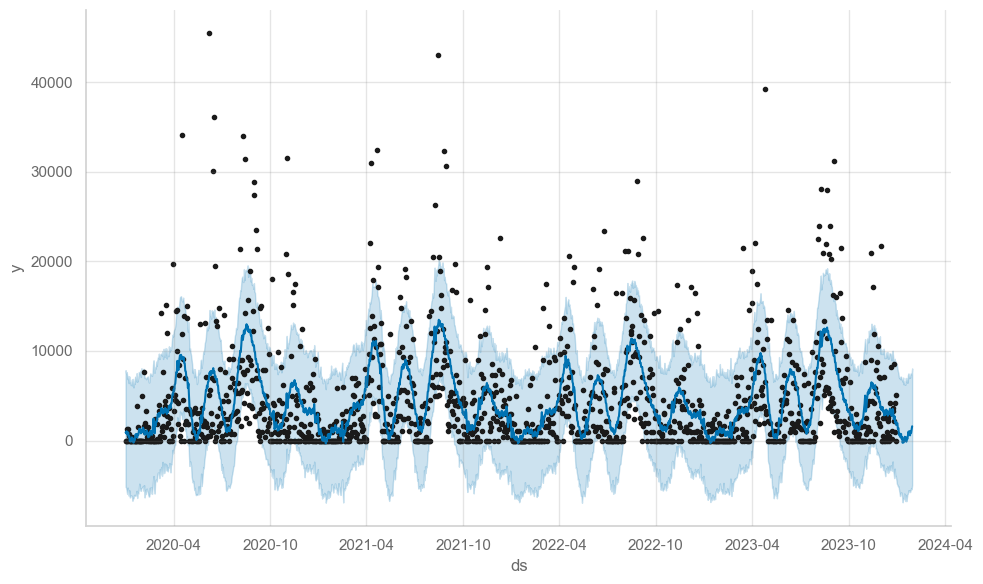

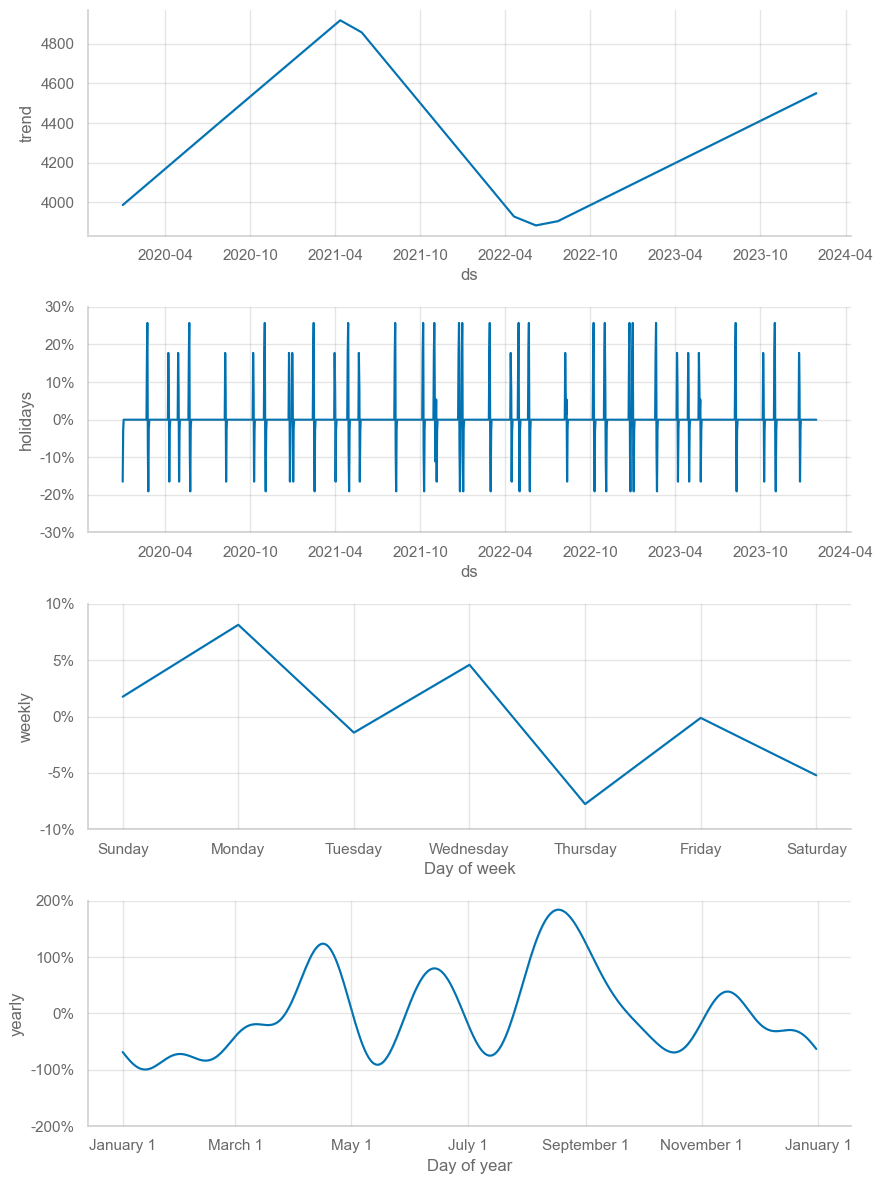

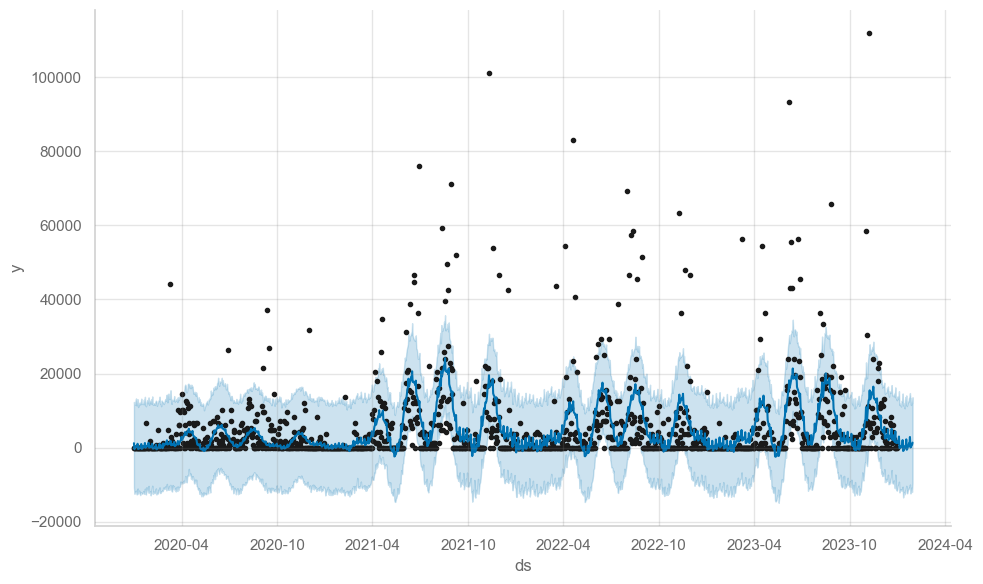

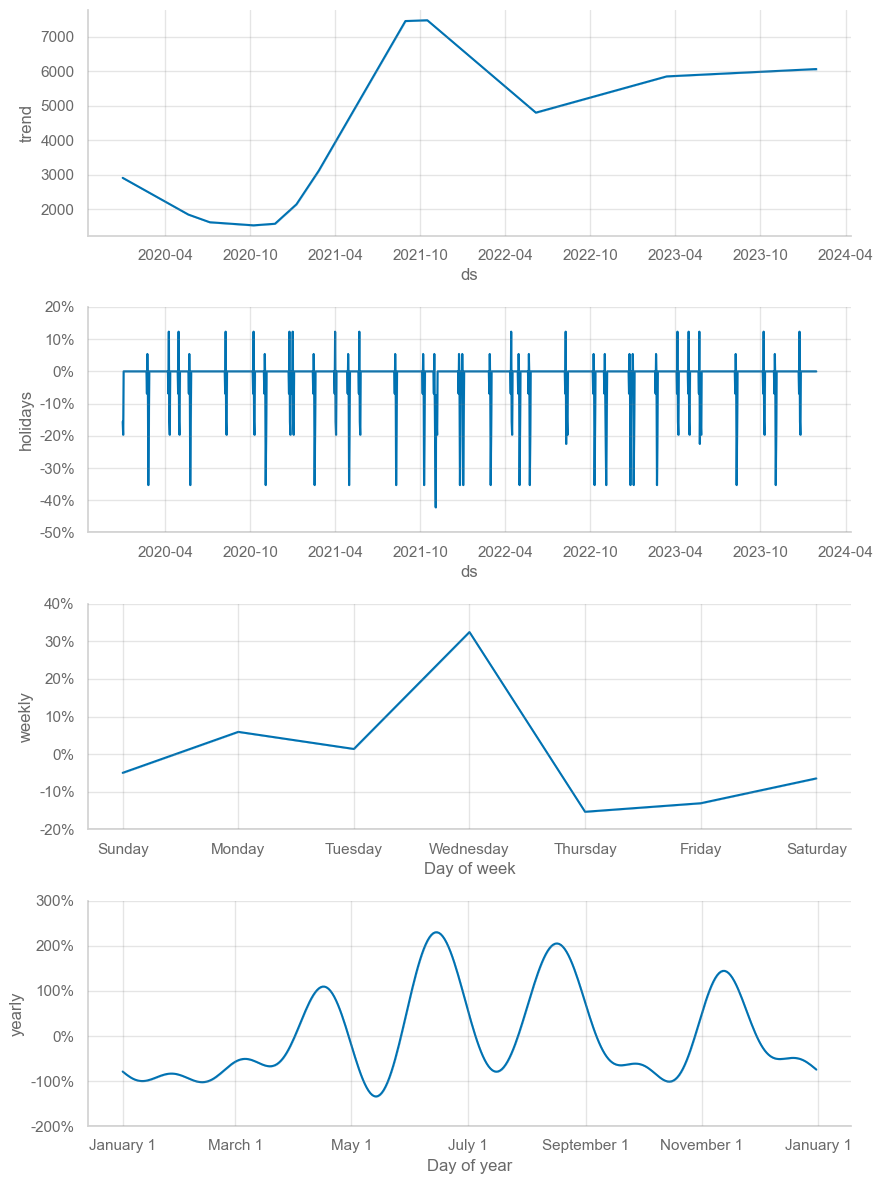

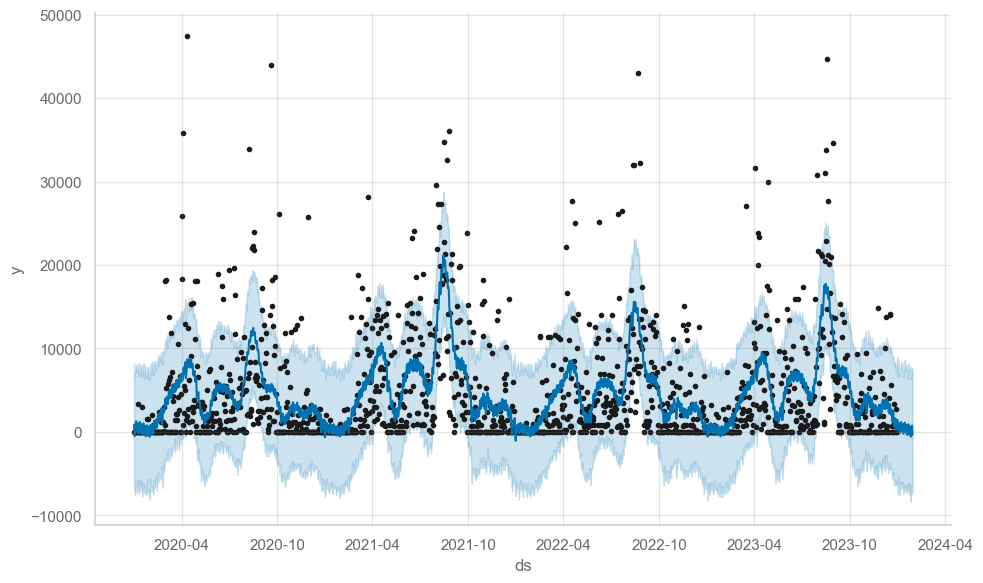

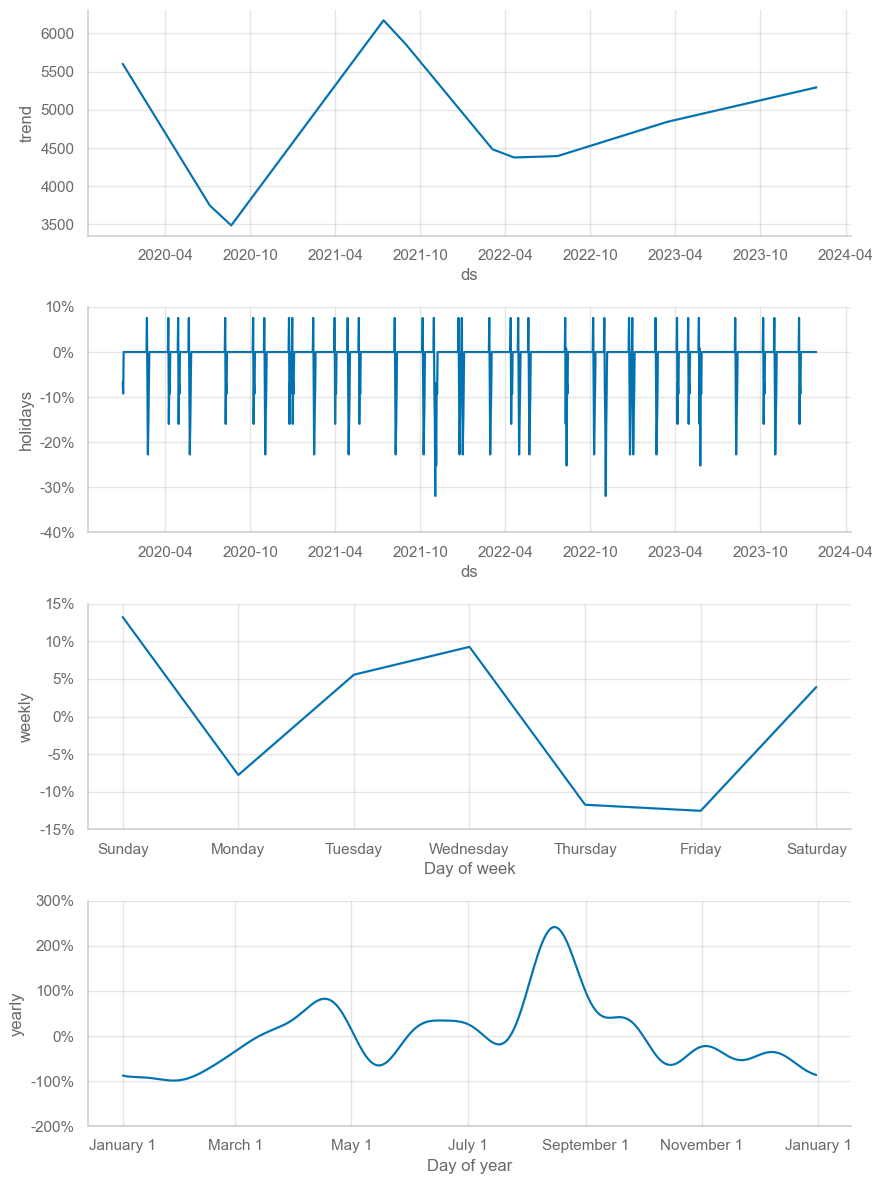

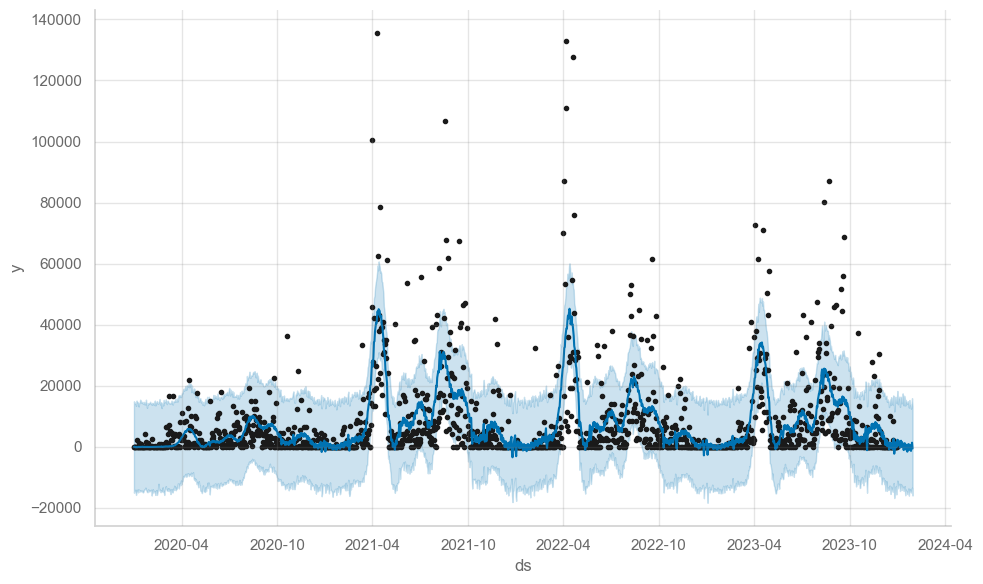

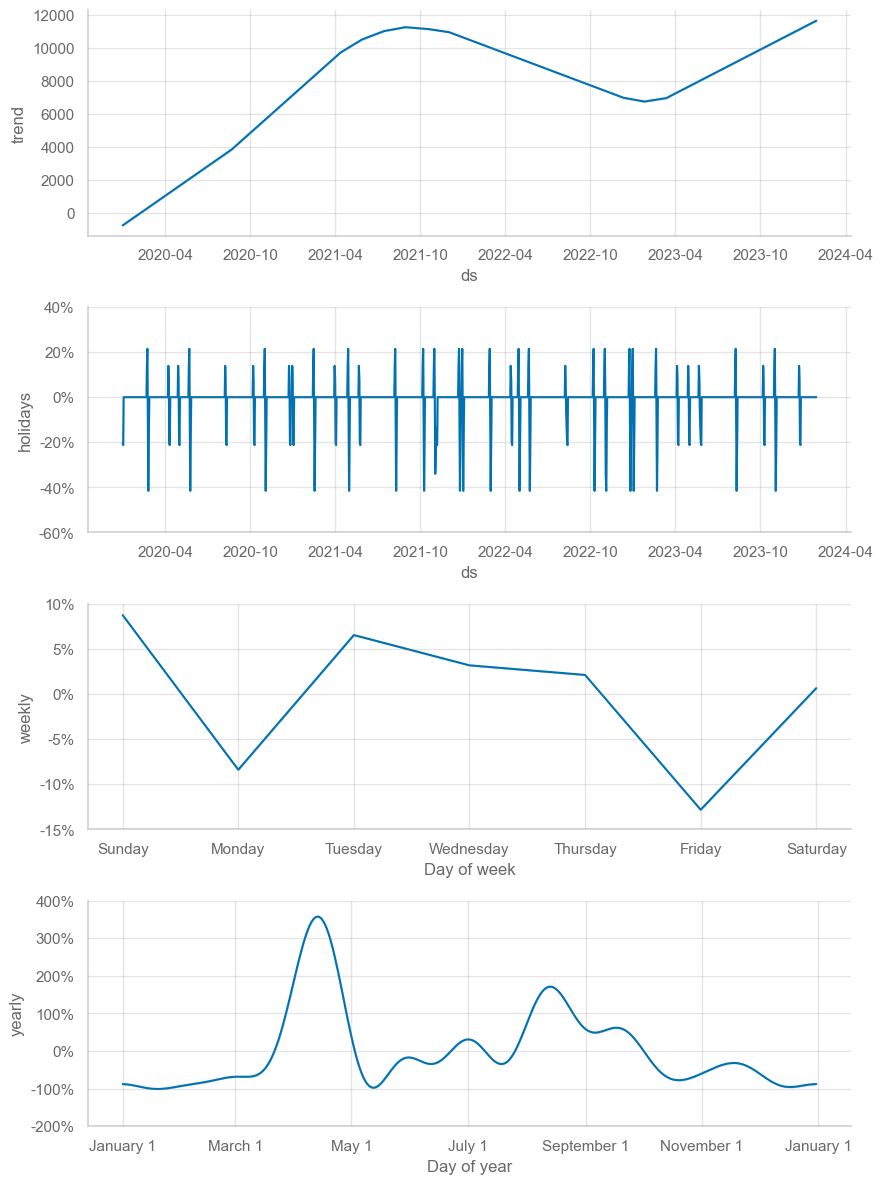

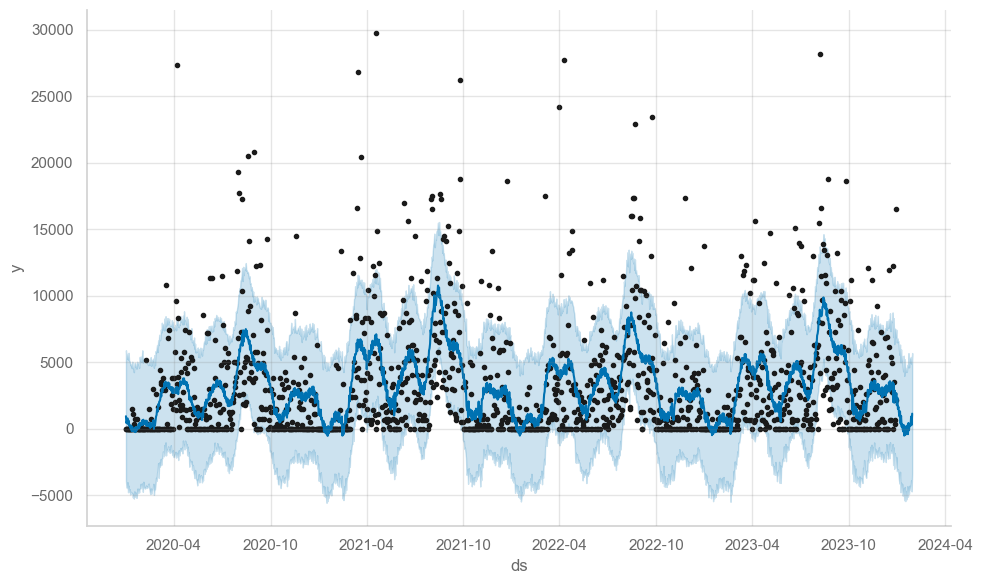

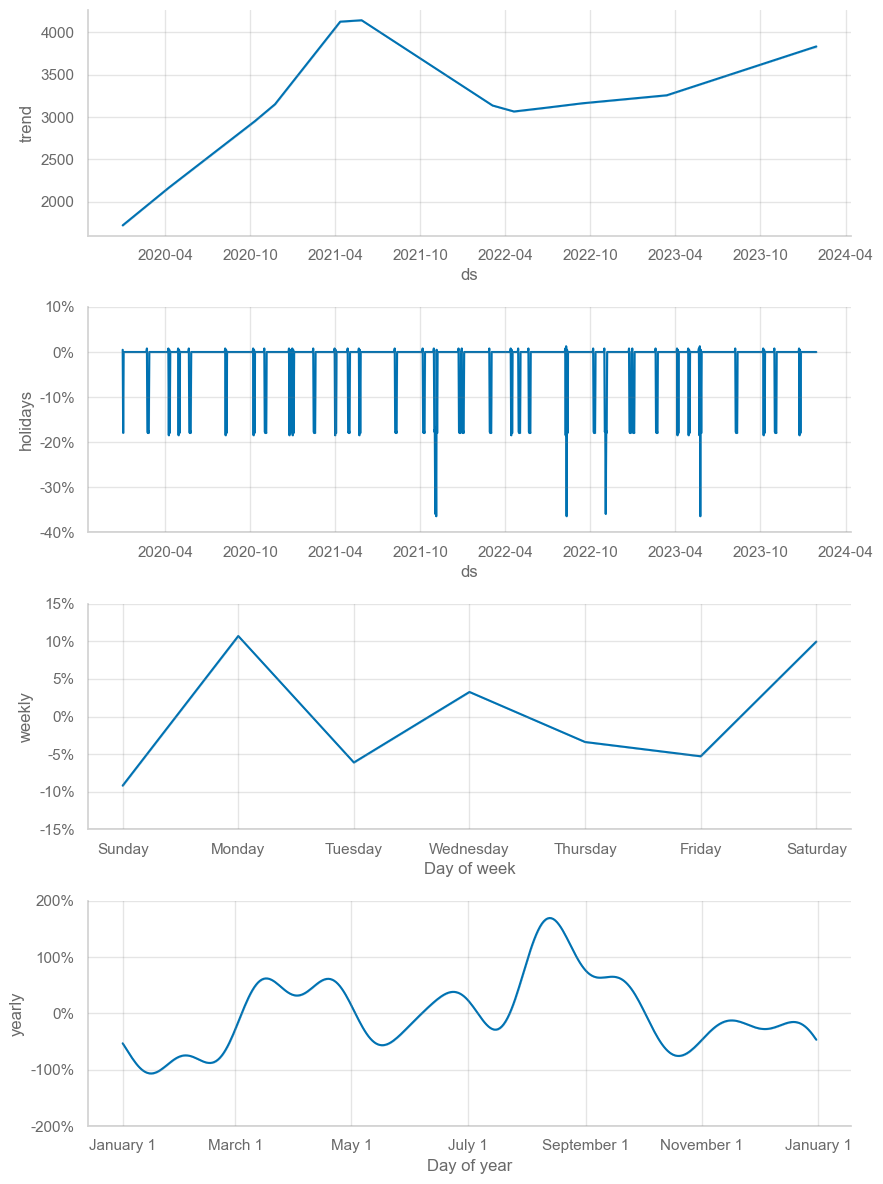

In [35]:
#PROPHET MODEL

forecasted_dfs = []

for feature in total_sales_df.columns[:5]:
    
    #formatting
    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative',
                holidays=holiday
                 )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)
    
    fig1 = m.plot(fcst_prophet_train)
    fig2 = m.plot_components(fcst_prophet_train)

    forecasted_df = fcst_prophet_train[fcst_prophet_train['ds']>=forecast_start_date]
    
    forecasted_dfs.append(forecasted_df)

In [36]:
total_sales_df.columns

Index(['Acnemoist Cream 60GM', 'Androanagen Solution 100Ml',
       'Androanagen Tablets 10S', 'Banatan Cream 50GM', 'Canthex 10 Capsules',
       'Melawash 100 ML', 'Nixiyax 15 'S'],
      dtype='object', name='products')